# Basic imports

In [1]:
%reload_ext autoreload
%autoreload 2
from IPython.display import Math
from tqdm.notebook import tqdm
from dataclasses import dataclass, field, replace
from datetime import datetime
import pickle
import sys
import os
parent_path = os.path.abspath("..")
if parent_path not in sys.path:
    sys.path.append(parent_path)

# For a quick config:
# import logging
# logging.basicConfig(
#     format="%(asctime)s [%(levelname)s] [%(name)s]: %(message)s",
#     level=logging.DEBUG
# )

import matplotlib
import matplotlib.colors
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import pandas as pd

import numpy as np
from numpy.linalg import pinv, svd, norm
from numpy import abs
from numpy.typing import NDArray
import scipy
from scipy.linalg import svdvals
from typing import Callable, Dict, List, Optional, Tuple, Union, Iterable, Literal, Any, Sequence, cast
import qutip

from src.quantum_utils import measure_povm, random_kets, ObservablesType, _make_observables_into_nparray
from src.quantum_utils import QuantumStatesBatch, QuantumKetsBatch, QuantumOperatorsBatch, QuantumState, QuantumKet, QuantumOperator, POVM
from src.shadow_tomography import frame_operator
from src.utils import pp_matrix
from src.povms import sic_povm, mub_povm, random_rank1_povm
from src.QELM import QELM, TrainingData
from src.plotting_utils import logspace, plot_data_with_error_bars
from src.bias2_experiments_utils import MatrixBlocksExtractor, Bias2ExperimentsManager, plot_aggregated_stats

def truncate_svdvals(matrix, num_vals: int):
    """Truncate singular values beyond a given number."""
    U, s, Vt = np.linalg.svd(matrix, full_matrices=False)
    
    # 2) Zero out all but the largest k singular values
    s_trunc = np.zeros_like(s)
    s_trunc[:num_vals] = s[:num_vals]
    
    # 3) Reconstruct the matrix with truncated singular values
    return U @ np.diag(s_trunc) @ Vt

def truncated_pinv(matrix, num_vals: int):
    """Compute the pseudo-inverse of a matrix using truncated SVD."""
    U, s, Vt = np.linalg.svd(matrix, full_matrices=False)
    
    # 2) Zero out all but the largest k singular values
    s_trunc = np.zeros_like(s)
    s_trunc[:num_vals] = 1 / s[:num_vals]
    
    # 3) Compute the pseudo-inverse with truncated singular values
    return Vt.T @ np.diag(s_trunc) @ U.T

def logfit_and_plot(x, y):
    try:
        a, b = np.polyfit(np.log(x), np.log(y), deg=1)
        x_fit = np.logspace(np.log10(x.min()), np.log10(x.max()), num=200)
        y_fit = np.exp(b + a * np.log(x_fit))
        plt.plot(x_fit, y_fit, '--', color="red", label=fr"fit: $y = exp({b:.2f})  x^{{{a:.2f}}}$")
    except Exception as e:
        print(f"Error fitting: {e}")

# New bias2 runs

In [ ]:
seed = np.random.randint(1, 10**4); np.random.seed(seed)
data = Bias2ExperimentsManager(dim=2, n_realizations=10, povm=random_rank1_povm(2, 20, seed=seed),
    test_state=QuantumKet(qutip.rand_ket(2, seed=seed).full().flatten()),
    target_obs=qutip.sigmax().full(),
    train_states=list(logspace(20, 10**2, num=20).astype(int)),
    train_stat=50, savefile='testrun.pkl', seed=seed
)

In [ ]:
seed = np.random.randint(1, 10**4); np.random.seed(seed)
data = Bias2ExperimentsManager(dim=2, n_realizations=300, povm=random_rank1_povm(2, 10, seed=seed),
    test_state=QuantumKet(qutip.rand_ket(2, seed=seed).full().flatten()),
    target_obs=qutip.sigmax().full(),
    train_states=list(logspace(20, 10**4, num=20).astype(int)),
    train_stat=20, savefile='stat20_rndpovm10outs.pkl', seed=seed
)

In [ ]:
seed = np.random.randint(1, 10**6); np.random.seed(seed)
data = Bias2ExperimentsManager(dim=2, n_realizations=300, povm=sic_povm(),
    test_state=QuantumKet(qutip.rand_ket(2, seed=seed).full().flatten()),
    target_obs=qutip.sigmax().full(),
    train_states=list(logspace(20, 10**4, num=20).astype(int)),
    train_stat=20, savefile='stat20_sicpovm_rerun.pkl', seed=seed
)

seed = np.random.randint(1, 10**6); np.random.seed(seed)
data = Bias2ExperimentsManager(dim=2, n_realizations=300, povm=sic_povm(),
    test_state=QuantumKet(qutip.rand_ket(2, seed=seed).full().flatten()),
    target_obs=qutip.sigmax().full(),
    train_states=list(logspace(20, 10**4, num=20).astype(int)),
    train_stat=40, savefile='stat40_sicpovm_rerun.pkl', seed=seed
)

seed = np.random.randint(1, 10**6); np.random.seed(seed)
data = Bias2ExperimentsManager(dim=2, n_realizations=300, povm=sic_povm(),
    test_state=QuantumKet(qutip.rand_ket(2, seed=seed).full().flatten()),
    target_obs=qutip.sigmax().full(),
    train_states=list(logspace(20, 10**4, num=20).astype(int)),
    train_stat=100, savefile='stat100_sicpovm_rerun.pkl', seed=seed
)

In [ ]:
seed = np.random.randint(1, 10**4); np.random.seed(seed)
data = Bias2ExperimentsManager(dim=2, n_realizations=300, povm=random_rank1_povm(2, 10, seed=seed),
    test_state=QuantumKet(qutip.rand_ket(2, seed=seed).full().flatten()),
    target_obs=qutip.sigmax().full(),
    train_states=list(logspace(20, 10**4, num=20).astype(int)),
    train_stat=list(logspace(20, 10**4, num=20).astype(int)),
    savefile='fullscan_rndpovm10outs.pkl', seed=seed
)

# Plotting bias2 runs

In [ ]:
Bias2ExperimentsManager.load_metadata('stat40_sicpovm.pkl')

{'n_realizations': 300,
 'dim': 2,
 'test_state': array([[-0.83318578+0.21536244j, -0.2535863 -0.44171763j]]),
 'povm': array([[[ 0.5       +0.j        ,  0.        +0.j        ],
         [ 0.        +0.j        ,  0.        +0.j        ]],
 
        [[ 0.16666667+0.j        ,  0.23570226+0.j        ],
         [ 0.23570226+0.j        ,  0.33333333+0.j        ]],
 
        [[ 0.16666667+0.j        , -0.11785113-0.20412415j],
         [-0.11785113+0.20412415j,  0.33333333+0.j        ]],
 
        [[ 0.16666667+0.j        , -0.11785113+0.20412415j],
         [-0.11785113-0.20412415j,  0.33333333+0.j        ]]]),
 'target_obs': array([[[0.+0.j, 1.+0.j],
         [1.+0.j, 0.+0.j]]]),
 'start_time': '2025-06-03T19:55:43.177491',
 'end_time': '2025-06-03T20:29:03.629838',
 'seed': 6464}

In [7]:
print(Bias2ExperimentsManager.load_metadata('stat20_sicpovm.pkl')['test_state'])
print(Bias2ExperimentsManager.load_metadata('stat40_sicpovm.pkl')['test_state'])
print(Bias2ExperimentsManager.load_metadata('stat100_sicpovm_20250604.pkl')['test_state'])

[[-0.83318578+0.21536244j -0.2535863 -0.44171763j]]
[[0.0293954-0.29746016j 0.6195534+0.72581468j]]
[[-0.55407797+0.68873994j -0.45616608+0.10270059j]]


## SIC

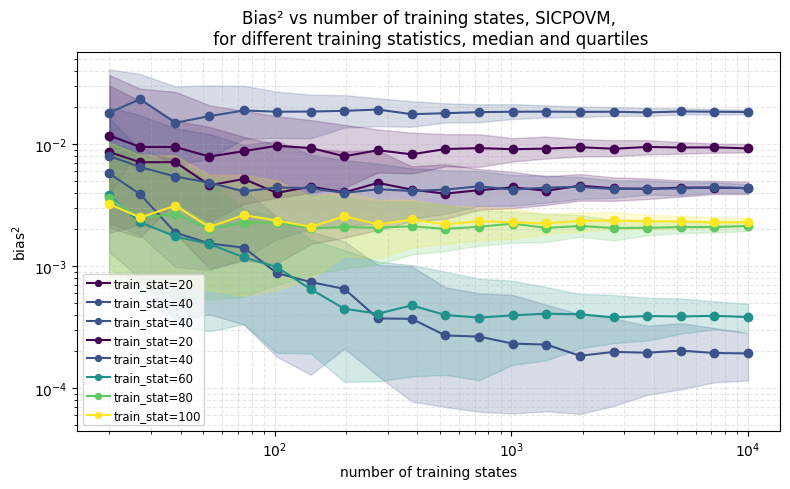

In [ ]:
def _():
    files = ['stat20_sicpovm.pkl', 'stat40_sicpovm.pkl', 'stat40_sicpovm_1.pkl']
    files += [f'stat{s}_sicpovm_20250604.pkl' for s in [20, 40, 60, 80, 100]]
    dfs = [Bias2ExperimentsManager.load_df(f) for f in files]
    plt.figure(figsize=(8, 5))
    train_stats = [df['train_stat'].iloc[0] for df in dfs]
    norm = matplotlib.colors.Normalize(min(train_stats), max(train_stats))
    for df in dfs:
        g = df.groupby('n_train_states')['bias2_real']
        med = g.median()
        q1 = g.quantile(0.25)
        q3 = g.quantile(0.75)
        ts = df['train_stat'].iloc[0]
        color = cm.viridis(norm(ts)) # type: ignore
        plt.plot(med.index, med.values, marker='o', color=color, label=f'train_stat={ts}')
        plt.fill_between(med.index, q1, q3, color=color, alpha=0.2)

    plt.xscale('log'); plt.yscale('log')
    plt.xlabel(r'number of training states'); plt.ylabel(r'$\mathrm{bias}^2$')
    plt.title('Bias² vs number of training states, SICPOVM,\n for different training statistics, median and quartiles')
    plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.legend(fontsize='small', markerscale=0.7, handletextpad=0.3, borderpad=0.3)
    plt.tight_layout(); plt.show()
_()


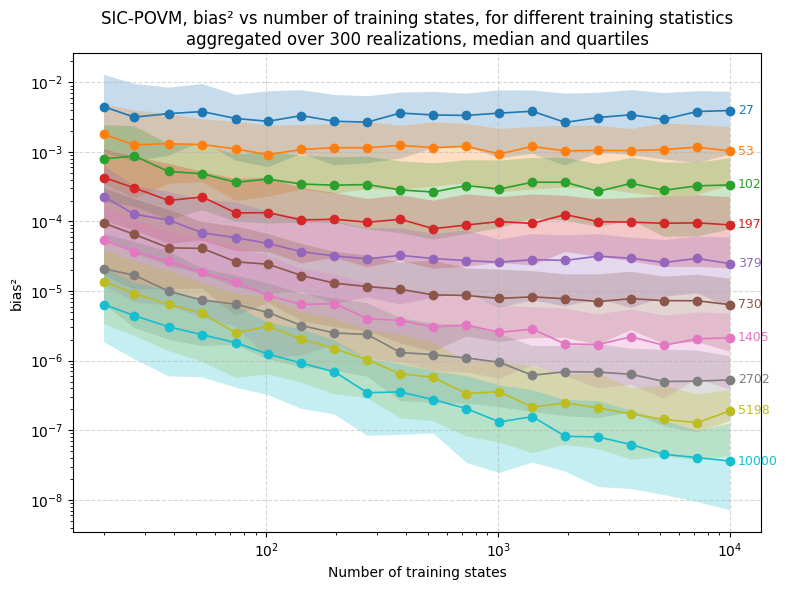

In [ ]:
def _():
    df = Bias2ExperimentsManager.load_df('fullscan_sicpovm_randomall_20250604.pkl')
    grouped = df.groupby(['n_train_states', 'train_stat']).agg(
        median=pd.NamedAgg(column='bias2_real', aggfunc='median'),
        q1=pd.NamedAgg(column='bias2_real', aggfunc=lambda x: x.quantile(0.25)),
        q3=pd.NamedAgg(column='bias2_real', aggfunc=lambda x: x.quantile(0.75)),
    )
    all_train_stats = df['train_stat'].unique()[1::2]
    stat_dict = {}
    for ts in all_train_stats:
        # .xs(ts, level='train_stat') “cross‐sections” out only those rows
        # where train_stat == ts.  The resulting index is just n_train_states.
        df_ts = grouped.xs(ts, level='train_stat').sort_index()
        stat_dict[ts] = df_ts
    plt.figure(figsize=(8,6))

    for ts, df_ts in stat_dict.items():
        x_vals  = df_ts.index.to_numpy()
        y_med   = df_ts['median'].to_numpy()
        y_lower = df_ts['q1'].to_numpy()
        y_upper = df_ts['q3'].to_numpy()
        line, = plt.plot(x_vals, y_med, marker='o', label=f"{ts}", linewidth=1.2)
        plt.fill_between(x_vals, y_lower, y_upper, alpha=0.25)
        # (c) Annotate “ts” at the rightmost point of the median curve.
        #     We shift the text slightly to the right (x + Δ) so it doesn’t sit exactly on the marker.
        x_last = x_vals[-1]
        y_last = y_med[-1]
        plt.text(x_last * 1.08, y_last, str(ts),
            va='center', ha='left', fontsize=9, color=line.get_color())

    plt.xlabel('Number of training states'); plt.ylabel('bias²')
    title = 'SIC-POVM, bias² vs number of training states, for different training statistics'
    title += '\naggregated over 300 realizations, median and quartiles'
    plt.title(title); plt.xscale('log'); plt.yscale('log')
    plt.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()
_()

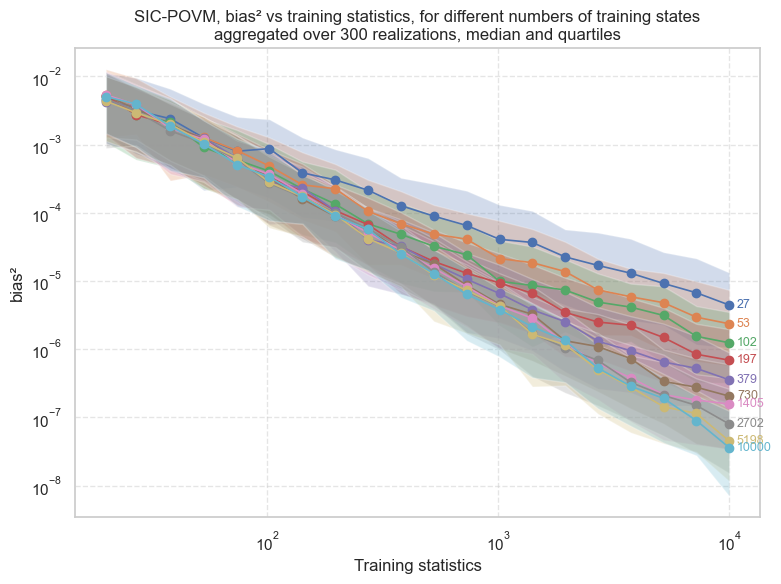

In [20]:
def _():
    df = Bias2ExperimentsManager.load_df('fullscan_sicpovm_randomall_20250604.pkl')
    grouped = df.groupby(['n_train_states', 'train_stat']).agg(
        median=pd.NamedAgg(column='bias2_real', aggfunc='median'),
        q1=pd.NamedAgg(column='bias2_real', aggfunc=lambda x: x.quantile(0.25)),
        q3=pd.NamedAgg(column='bias2_real', aggfunc=lambda x: x.quantile(0.75)),
    )
    all_ntrainstates = df['n_train_states'].unique()[1::2]
    stat_dict = {}
    for ts in all_ntrainstates:
        # .xs(ts, level='train_stat') “cross‐sections” out only those rows
        # where train_stat == ts.  The resulting index is just n_train_states.
        df_ts = grouped.xs(ts, level='n_train_states').sort_index()
        stat_dict[ts] = df_ts
    plt.figure(figsize=(8,6))

    for ts, df_ts in stat_dict.items():
        x_vals  = df_ts.index.to_numpy()
        y_med   = df_ts['median'].to_numpy()
        y_lower = df_ts['q1'].to_numpy()
        y_upper = df_ts['q3'].to_numpy()
        line, = plt.plot(x_vals, y_med, marker='o', label=f"{ts}", linewidth=1.2)
        plt.fill_between(x_vals, y_lower, y_upper, alpha=0.25)
        x_last = x_vals[-1]
        y_last = y_med[-1]
        plt.text(x_last * 1.08, y_last, str(ts),
            va='center', ha='left', fontsize=9, color=line.get_color())

    plt.xlabel('Training statistics'); plt.ylabel('bias²')
    title = 'SIC-POVM, bias² vs training statistics, for different numbers of training states'
    title += '\naggregated over 300 realizations, median and quartiles'
    plt.title(title); plt.xscale('log'); plt.yscale('log')
    plt.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()
_()

In [13]:
np.exp(-2.023)

0.13225809503797206

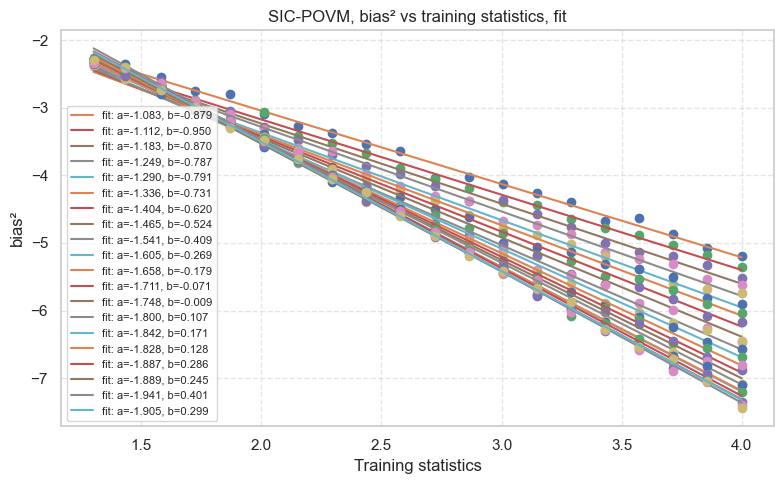

In [36]:
df = Bias2ExperimentsManager.load_df('fullscan_sicpovm_randomall_20250604.pkl')
all_n_trainstates = df['n_train_states'].unique()
plt.figure(figsize=(8, 5))
for n_train_states in all_n_trainstates:
    df_n = df[df['n_train_states'] == n_train_states]

    grouped = df_n.groupby(['n_train_states', 'train_stat']).agg(
        median=pd.NamedAgg(column='bias2_real', aggfunc='median'),
        q1=pd.NamedAgg(column='bias2_real', aggfunc=lambda x: x.quantile(0.25)),
        q3=pd.NamedAgg(column='bias2_real', aggfunc=lambda x: x.quantile(0.75)),
    )

    values = [(np.log10(s[0][1]), np.log10(s[1])) for s in list(grouped['median'].items())]
    # list(grouped['median'].items())
    # do a fit of the values in values
    from scipy.optimize import curve_fit
    def func(x, a, b):
        return a * x + b
    x_vals = np.array([v[0] for v in values])
    y_vals = np.array([v[1] for v in values])
    popt, pcov = curve_fit(func, x_vals, y_vals)
    plt.plot(x_vals, y_vals, 'o')
    plt.plot(x_vals, func(x_vals, *popt), '-', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Training statistics'); plt.ylabel('bias²')
plt.title('SIC-POVM, bias² vs training statistics, fit')
# plt.xscale('log'); plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=8); plt.tight_layout(); plt.show()


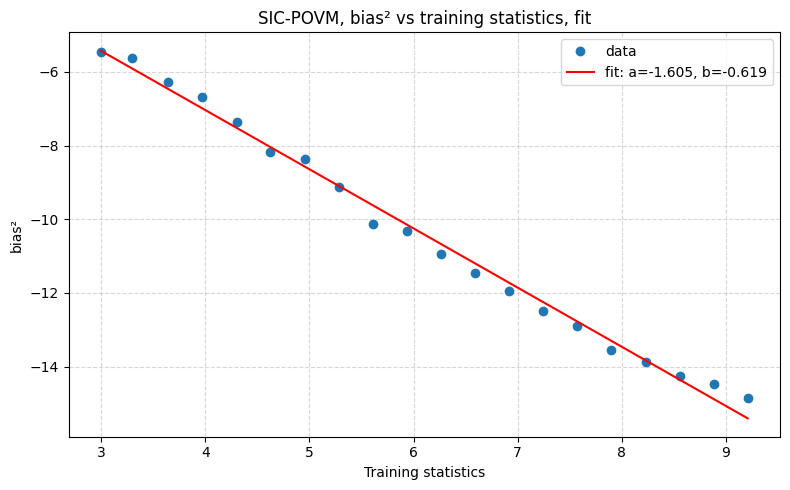

In [ ]:
df = Bias2ExperimentsManager.load_df('fullscan_sicpovm_randomall_20250604.pkl')
df = df[df['n_train_states'] == 379]

grouped = df.groupby(['n_train_states', 'train_stat']).agg(
    median=pd.NamedAgg(column='bias2_real', aggfunc='median'),
    q1=pd.NamedAgg(column='bias2_real', aggfunc=lambda x: x.quantile(0.25)),
    q3=pd.NamedAgg(column='bias2_real', aggfunc=lambda x: x.quantile(0.75)),
)

values = [(np.log(s[0][1]), np.log(s[1])) for s in list(grouped['median'].items())]
# list(grouped['median'].items())
# do a fit of the values in values
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b
x_vals = np.array([v[0] for v in values])
y_vals = np.array([v[1] for v in values])
popt, pcov = curve_fit(func, x_vals, y_vals)
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, 'o', label='data')
plt.plot(x_vals, func(x_vals, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Training statistics'); plt.ylabel('bias²')
plt.title('SIC-POVM, bias² vs training statistics, fit')
# plt.xscale('log'); plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(); plt.tight_layout(); plt.show()


In [82]:
def average_bias_approx(stat, n_states, d):
    b1 = d * (d**2 + d - 2) / (d + 1)
    # b2 = (d-1)**2 * (d + 1)**4 / (d**2 * (n_out - 1))
    # b2 += - (d - 1) * (1 + 4 * d + 2 * d**2) / (d**2 * (d + 1))
    b2 = (d - 1) * (d + 2)**2 / (d + 1)
    return b1 / (stat * n_states) + b2 / (stat**2)

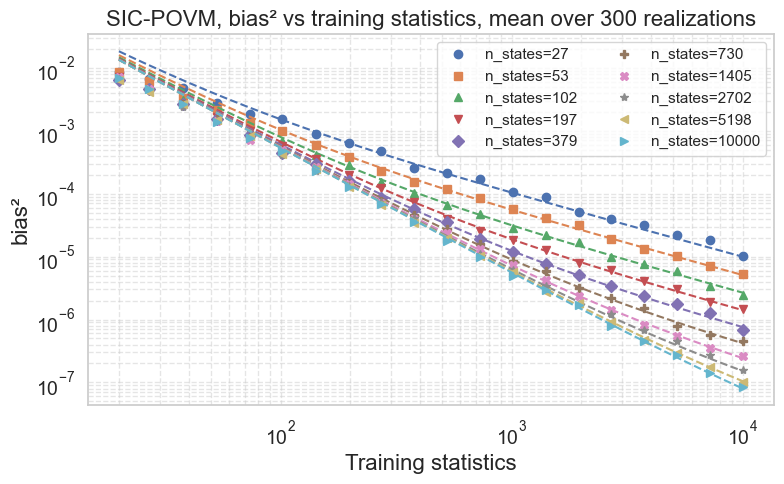

In [133]:
def _():
    datafile = 'fullscan_sicpovm_randomall_20250604.pkl'
    df = Bias2ExperimentsManager.load_df(datafile)
    n_realizations = Bias2ExperimentsManager.load_metadata(datafile)['n_realizations']
    all_n_trainstates = df['n_train_states'].unique()[1::2]
    plt.figure(figsize=(8, 5))

    markers = ['o', 's', '^', 'v', 'D', 'P', 'X', '*', '<', '>']
    for i, n_states in enumerate(all_n_trainstates):
        df_ = df[df['n_train_states'] == n_states]

        # compute mean and quartiles per train_stat
        agg = df_.groupby('train_stat')['bias2_real'].agg(
            median='mean',
            q1=lambda x: x.quantile(0.25),
            q3=lambda x: x.quantile(0.75)
        ).reset_index()

        line = plt.plot(agg['train_stat'], agg['median'],
                        ls='', marker=markers[i], label=f'n_states={n_states}')[0]
        color = line.get_color()

        # overlay theoretical curve
        x_vals = np.logspace(np.log10(agg['train_stat'].min()),
                             np.log10(agg['train_stat'].max()), num=100)
        plt.plot(x_vals,
                 average_bias_approx(x_vals, n_states, d=2),
                 '--', color=color)

    plt.xlabel('Training statistics', fontsize=16)
    plt.ylabel('bias²', fontsize=16)
    plt.title(f'SIC-POVM, bias² vs training statistics, mean over {n_realizations} realizations',
              fontsize=16)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend(fontsize=11, ncol=2)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.tight_layout()
    plt.savefig('sicpovm_bias2_vs_stats_with_fit.pdf', bbox_inches='tight')
    plt.show()
_()

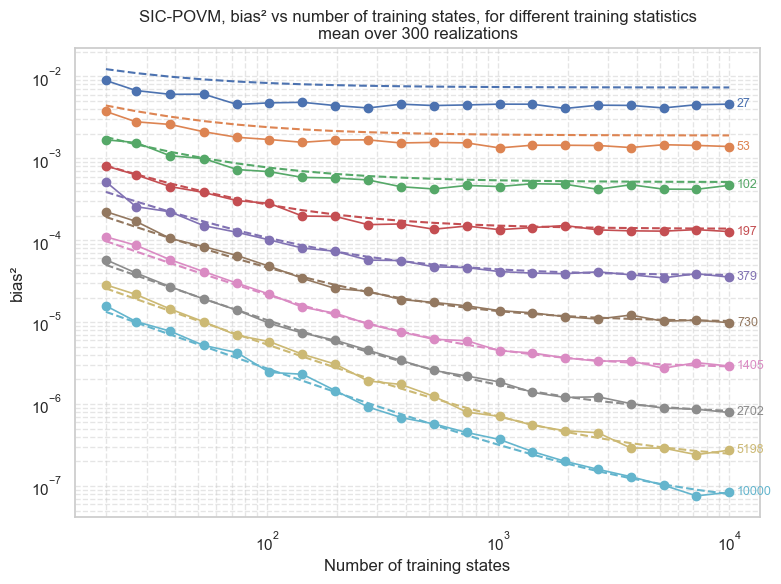

In [101]:
def _():
    df = Bias2ExperimentsManager.load_df('fullscan_sicpovm_randomall_20250604.pkl')
    grouped = df.groupby(['n_train_states', 'train_stat']).agg(
        mean=pd.NamedAgg(column='bias2_real', aggfunc='mean'),
        q1=pd.NamedAgg(column='bias2_real', aggfunc=lambda x: x.quantile(0.25)),
        q3=pd.NamedAgg(column='bias2_real', aggfunc=lambda x: x.quantile(0.75)),
    )
    all_train_stats = df['train_stat'].unique()[1::2]
    stat_dict = {}
    for ts in all_train_stats:
        # .xs(ts, level='train_stat') “cross‐sections” out only those rows
        # where train_stat == ts.  The resulting index is just n_train_states.
        df_ts = grouped.xs(ts, level='train_stat').sort_index()
        stat_dict[ts] = df_ts
    plt.figure(figsize=(8,6))

    for ts, df_ts in stat_dict.items():
        x_vals  = df_ts.index.to_numpy()  # this is n_train_states
        y_med   = df_ts['mean'].to_numpy()
        y_lower = df_ts['q1'].to_numpy()
        y_upper = df_ts['q3'].to_numpy()
        line, = plt.plot(x_vals, y_med, marker='o', label=f"{ts}", linewidth=1.2)
        color = line.get_color()

        # overlay the theoretical curve in the same color
        # x_vals = np.logspace(np.log10(agg['train_stat'].min()),
        #                     np.log10(agg['train_stat'].max()), num=100)
        plt.plot(x_vals,
                average_bias_approx(stat=ts, n_states=x_vals, d=2),
                '--', color=color)
        
        # plt.fill_between(x_vals, y_lower, y_upper, alpha=0.25)
        # (c) Annotate “ts” at the rightmost point of the median curve.
        #     We shift the text slightly to the right (x + Δ) so it doesn’t sit exactly on the marker.
        x_last = x_vals[-1]
        y_last = y_med[-1]
        plt.text(x_last * 1.08, y_last, str(ts),
            va='center', ha='left', fontsize=9, color=line.get_color())

    plt.xlabel('Number of training states'); plt.ylabel('bias²')
    title = 'SIC-POVM, bias² vs number of training states, for different training statistics'
    title += '\nmean over 300 realizations'
    plt.title(title); plt.xscale('log'); plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.5); plt.tight_layout();
    plt.savefig('sicpovm_bias2_vs_ntrainstates_with_fit.pdf', bbox_inches='tight')
    plt.show()
_()

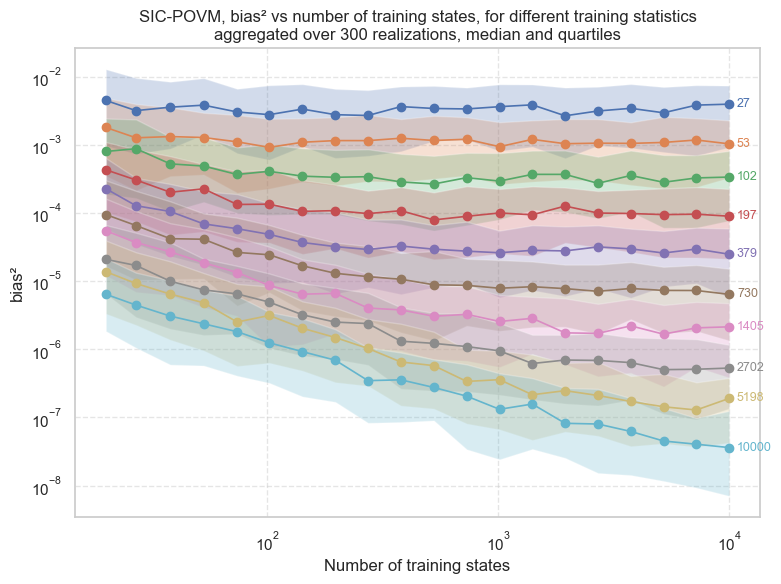

In [ ]:
def _():
    df = Bias2ExperimentsManager.load_df('fullscan_sicpovm_randomall_20250604.pkl')
    grouped = df.groupby(['n_train_states', 'train_stat']).agg(
        median=pd.NamedAgg(column='bias2_real', aggfunc='median'),
        q1=pd.NamedAgg(column='bias2_real', aggfunc=lambda x: x.quantile(0.25)),
        q3=pd.NamedAgg(column='bias2_real', aggfunc=lambda x: x.quantile(0.75)),
    )
    all_train_stats = df['train_stat'].unique()[1::2]
    stat_dict = {}
    for ts in all_train_stats:
        # .xs(ts, level='train_stat') “cross‐sections” out only those rows
        # where train_stat == ts.  The resulting index is just n_train_states.
        df_ts = grouped.xs(ts, level='train_stat').sort_index()
        stat_dict[ts] = df_ts
    plt.figure(figsize=(8,6))

    for ts, df_ts in stat_dict.items():
        x_vals  = df_ts.index.to_numpy()  # this is n_train_states
        y_med   = df_ts['median'].to_numpy()
        y_lower = df_ts['q1'].to_numpy()
        y_upper = df_ts['q3'].to_numpy()
        line, = plt.plot(x_vals, y_med, marker='o', label=f"{ts}", linewidth=1.2)
        plt.fill_between(x_vals, y_lower, y_upper, alpha=0.25)
        # (c) Annotate “ts” at the rightmost point of the median curve.
        #     We shift the text slightly to the right (x + Δ) so it doesn’t sit exactly on the marker.
        x_last = x_vals[-1]
        y_last = y_med[-1]
        plt.text(x_last * 1.08, y_last, str(ts),
            va='center', ha='left', fontsize=9, color=line.get_color())

    plt.xlabel('Number of training states'); plt.ylabel('bias²')
    title = 'SIC-POVM, bias² vs number of training states, for different training statistics'
    title += '\naggregated over 300 realizations, median and quartiles'
    plt.title(title); plt.xscale('log'); plt.yscale('log')
    plt.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()
_()

## MUB

Plot the 20250604 MUB plots

In [ ]:
for stat in [20, 40, 60, 80, 100]:
    plot_aggregated_stats(
        data=Bias2ExperimentsManager.load_df(f'stat{stat}_mubpovm_20250604.pkl'),
        base_cols=['bias2_real', 'bias2_leading_1', 'bias2_leading_3'],
        x_col='n_train_states', figure_split_col='train_stat',
        stats_to_plot=['median'], quantiles=(0.1, 0.9),
        base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
        custom_xlabel=r'$n_{\mathrm{train\_states}}$',
        custom_ylabel=r'$\mathrm{bias}^2$', title_prefix='MUB, bias²'
    )

In [ ]:
df = Bias2ExperimentsManager.load_df('fullscan_mubpovm_randomall_20250604.pkl')
df = df[df['train_stat'] == 10**4]
df = df.groupby('n_train_states')[['bias2_real', 'bias2_leading_1', 'bias2_leading_3']].median().sort_index()
df

bias2_real  bias2_leading_1  bias2_leading_3
n_train_states                                                
20              7.505140e-06     6.219673e-06     6.233515e-06
27              4.932154e-06     4.672886e-06     4.786542e-06
38              3.669440e-06     2.459931e-06     2.526672e-06
53              2.546396e-06     1.942394e-06     2.028652e-06
74              1.879851e-06     1.508202e-06     1.546355e-06
102             1.516019e-06     1.151942e-06     1.245621e-06
142             9.617288e-07     5.940185e-07     6.376210e-07
197             7.033720e-07     4.915108e-07     5.454157e-07
273             5.028743e-07     2.898680e-07     3.285277e-07
379             3.578026e-07     2.258954e-07     2.621142e-07
526             2.793372e-07     1.441135e-07     1.928249e-07
730             1.970921e-07     8.952999e-08     1.195599e-07
1013            1.207419e-07     4.818778e-08     8.804500e-08
1405            9.120459e-08     3.391350e-08     6.548375e-08
1948            1.011609e-07     2.144411e-08     4.888089e-08
2702            8.446255e-08     1.229628e-08     3.320824e-08
3748            6.342055e-08     6.650462e-09     2.621364e-08
5198            5.323080e-08     4.826749e-09     1.608538e-08
7210            4.129764e-08     1.404767e-09     8.728161e-09
10000           5.397248e-08     1.228227e-09     7.196254e-09

In [ ]:
plot_aggregated_stats(
    data=Bias2ExperimentsManager.load_df('fullscan_mubpovm_randomall_20250604.pkl'),
    base_cols=['bias2_real', 'bias2_leading_1', 'bias2_leading_3'],
    x_col='n_train_states', figure_split_col='train_stat',
    stats_to_plot=['median'], quantiles=(0.1, 0.9),
    base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
    custom_xlabel=r'$n_{\mathrm{train\_states}}$',
    custom_ylabel=r'$\mathrm{bias}^2$', title_prefix='MUB, bias²'
)

In [ ]:
plot_aggregated_stats(
    data=Bias2ExperimentsManager.load_df('fullscan_rndpovm10outs_randomall_20250604.pkl'),
    base_cols=['bias2_real', 'bias2_leading_1', 'bias2_leading_3'],
    x_col='n_train_states', figure_split_col='train_stat',
    stats_to_plot=['median'], quantiles=(0.1, 0.9),
    base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
    custom_xlabel=r'$n_{\mathrm{train\_states}}$',
    custom_ylabel=r'$\mathrm{bias}^2$', title_prefix='random 10 outs, bias²'
)

In [ ]:
states = QuantumKetsBatch(random_kets(dim=2, num_kets=2 * 10**3))
true_P = states.measure_povm(mub_povm(), statistics=np.inf)
dirty_P = states.measure_povm(mub_povm(), statistics=100)
mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=100)
svdvals(mb.scX @ mb.true_Pinv @ mb.scX - mb.X12 @ mb.Pi2 @ mb.X12.T @ mb.true_Pinv.T @ mb.Y)

array([5.06081588e+01, 4.47412310e+01, 2.34828224e+00, 2.97164578e-04,
       4.30209755e-05, 1.08265132e-07])

In [111]:
Bias2ExperimentsManager.load_metadata('fullscan_mubpovm_randomall_20250604.pkl')['n_realizations']

300

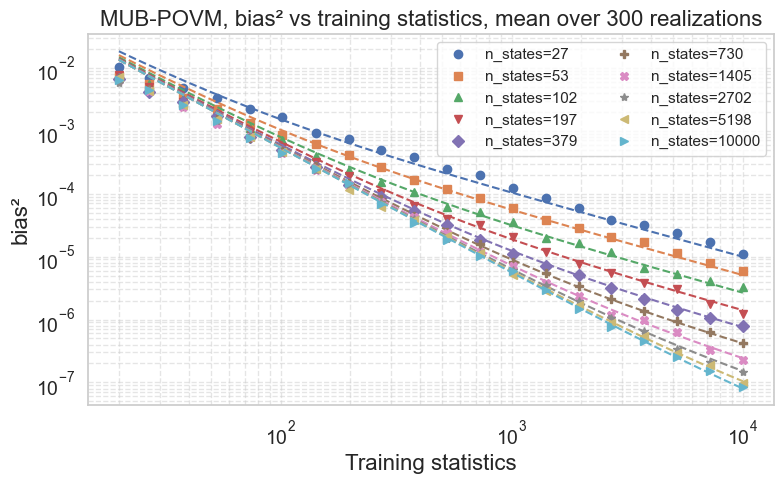

In [134]:
def _():
    datafile = 'fullscan_mubpovm_randomall_20250604.pkl'
    df = Bias2ExperimentsManager.load_df(datafile)
    n_realizations = Bias2ExperimentsManager.load_metadata(datafile)['n_realizations']
    all_n_trainstates = df['n_train_states'].unique()[1::2]
    plt.figure(figsize=(8, 5))

    markers = ['o', 's', '^', 'v', 'D', 'P', 'X', '*', '<', '>']
    for i, n_states in enumerate(all_n_trainstates):
        df_ = df[df['n_train_states'] == n_states]

        # compute mean and quartiles per train_stat
        agg = df_.groupby('train_stat')['bias2_real'].agg(
            mean='mean',
            q1=lambda x: x.quantile(0.25),
            q3=lambda x: x.quantile(0.75)
        ).reset_index()

        # plot markers and capture the color
        line = plt.plot(agg['train_stat'], agg['mean'], ls='', label=f'n_states={n_states}', marker=markers[i])[0]
        color = line.get_color()

        # overlay the theoretical curve in the same color
        x_vals = np.logspace(np.log10(agg['train_stat'].min()),
                            np.log10(agg['train_stat'].max()), num=100)
        plt.plot(x_vals,
                average_bias_approx(x_vals, n_states, d=2),
                '--', color=color)

    plt.xlabel('Training statistics', fontsize=16)
    plt.ylabel('bias²', fontsize=16)
    plt.title(fr'MUB-POVM, bias² vs training statistics, mean over {n_realizations} realizations', fontsize=16)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend(fontsize=11, ncol=2)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.tight_layout()
    plt.savefig('mubpovm_bias2_vs_stats_with_fit.pdf', bbox_inches='tight')
    plt.show()
_()


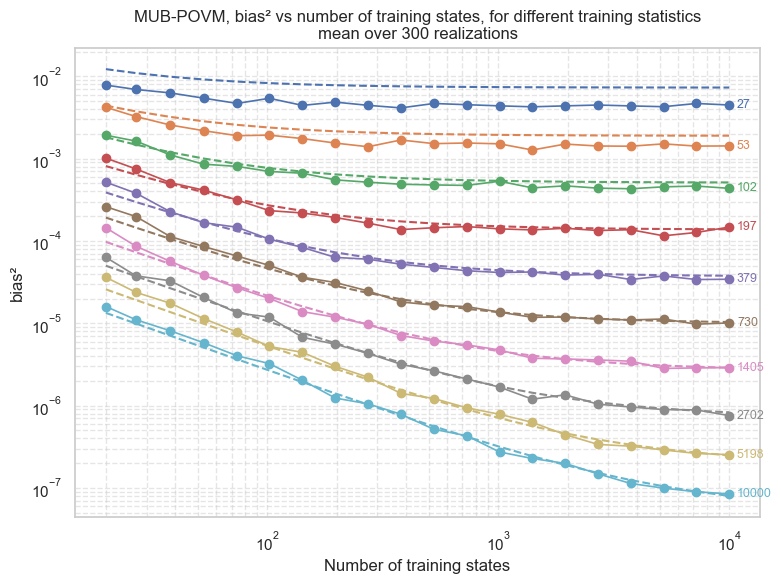

In [100]:
def _():
    df = Bias2ExperimentsManager.load_df('fullscan_mubpovm_randomall_20250604.pkl')
    grouped = df.groupby(['n_train_states', 'train_stat']).agg(
        mean=pd.NamedAgg(column='bias2_real', aggfunc='mean'),
        q1=pd.NamedAgg(column='bias2_real', aggfunc=lambda x: x.quantile(0.25)),
        q3=pd.NamedAgg(column='bias2_real', aggfunc=lambda x: x.quantile(0.75)),
    )
    all_train_stats = df['train_stat'].unique()[1::2]
    stat_dict = {}
    for ts in all_train_stats:
        # .xs(ts, level='train_stat') “cross‐sections” out only those rows
        # where train_stat == ts.  The resulting index is just n_train_states.
        df_ts = grouped.xs(ts, level='train_stat').sort_index()
        stat_dict[ts] = df_ts
    plt.figure(figsize=(8,6))

    for ts, df_ts in stat_dict.items():
        x_vals  = df_ts.index.to_numpy()  # this is n_train_states
        y_med   = df_ts['mean'].to_numpy()
        y_lower = df_ts['q1'].to_numpy()
        y_upper = df_ts['q3'].to_numpy()
        line, = plt.plot(x_vals, y_med, marker='o', label=f"{ts}", linewidth=1.2)
        color = line.get_color()

        # overlay the theoretical curve in the same color
        # x_vals = np.logspace(np.log10(agg['train_stat'].min()),
        #                     np.log10(agg['train_stat'].max()), num=100)
        plt.plot(x_vals,
                average_bias_approx(stat=ts, n_states=x_vals, d=2),
                '--', color=color)
        
        # plt.fill_between(x_vals, y_lower, y_upper, alpha=0.25)
        # (c) Annotate “ts” at the rightmost point of the median curve.
        #     We shift the text slightly to the right (x + Δ) so it doesn’t sit exactly on the marker.
        x_last = x_vals[-1]
        y_last = y_med[-1]
        plt.text(x_last * 1.08, y_last, str(ts),
            va='center', ha='left', fontsize=9, color=line.get_color())

    plt.xlabel('Number of training states'); plt.ylabel('bias²')
    title = 'MUB-POVM, bias² vs number of training states, for different training statistics'
    title += '\nmean over 300 realizations'
    plt.title(title); plt.xscale('log'); plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.5); plt.tight_layout();
    plt.savefig('mubpovm_bias2_vs_ntrainstates_with_fit.pdf', bbox_inches='tight')
    plt.show()
_()

## Random rank-1

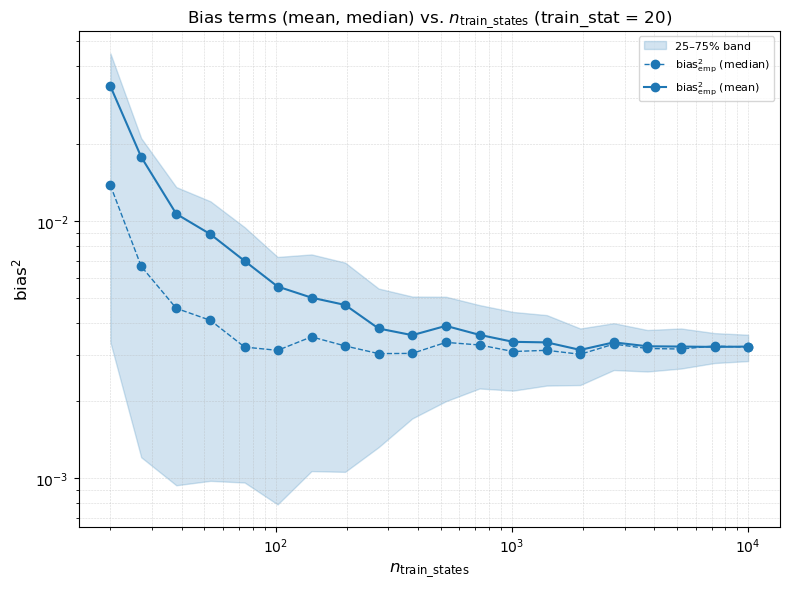

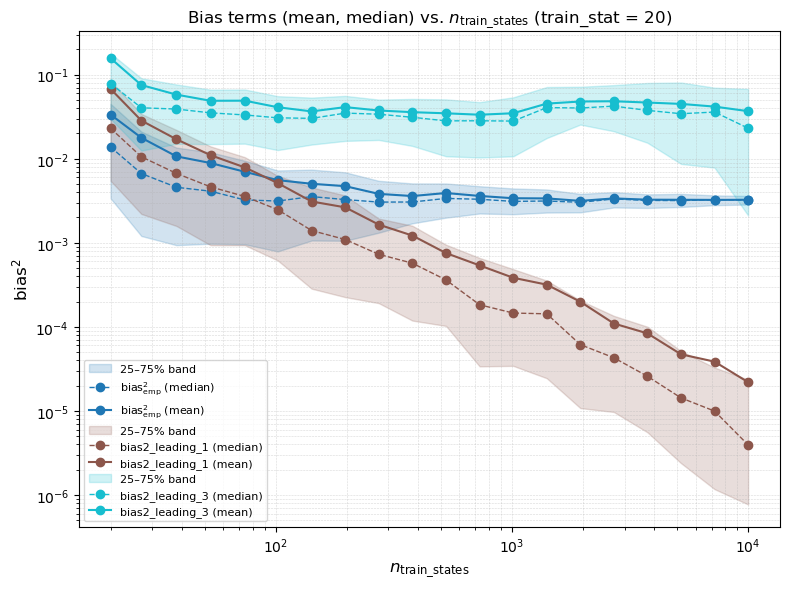

In [ ]:
plot_aggregated_stats(
    data=Bias2ExperimentsManager.load_df('stat20_rndpovm10outs.pkl'),
    base_cols=['bias2_real'],
    x_col='n_train_states', figure_split_col='train_stat',
    stats_to_plot=['mean', 'median'], quantiles=(0.25, 0.75),
    base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
    custom_xlabel=r'$n_{\mathrm{train\_states}}$',
    custom_ylabel=r'$\mathrm{bias}^2$'
)

plot_aggregated_stats(
    data=Bias2ExperimentsManager.load_df('stat20_rndpovm10outs.pkl'),
    base_cols=['bias2_real', 'bias2_leading_1', 'bias2_leading_3'],
    x_col='n_train_states', figure_split_col='train_stat',
    stats_to_plot=['mean', 'median'], quantiles=(0.25, 0.75),
    base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
    custom_xlabel=r'$n_{\mathrm{train\_states}}$',
    custom_ylabel=r'$\mathrm{bias}^2$'
)

This was saved with an old version of the code, no metadata is available.


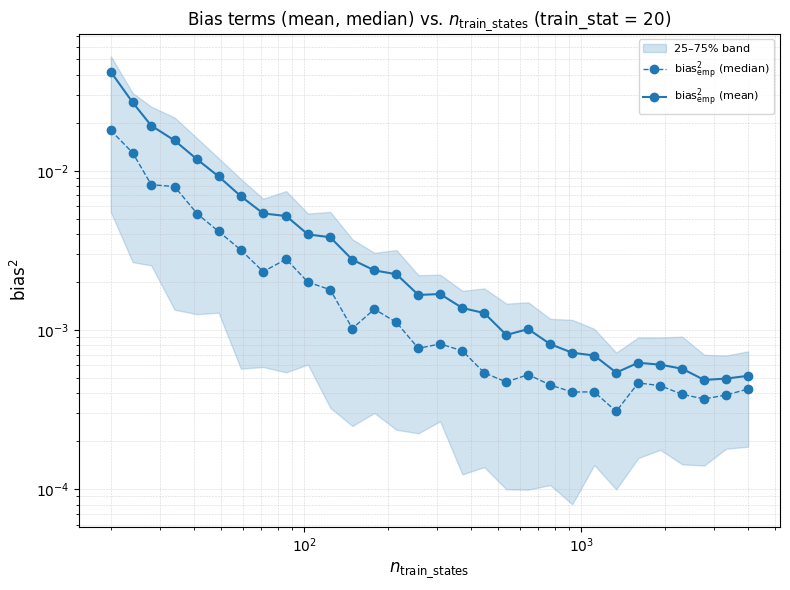

This was saved with an old version of the code, no metadata is available.


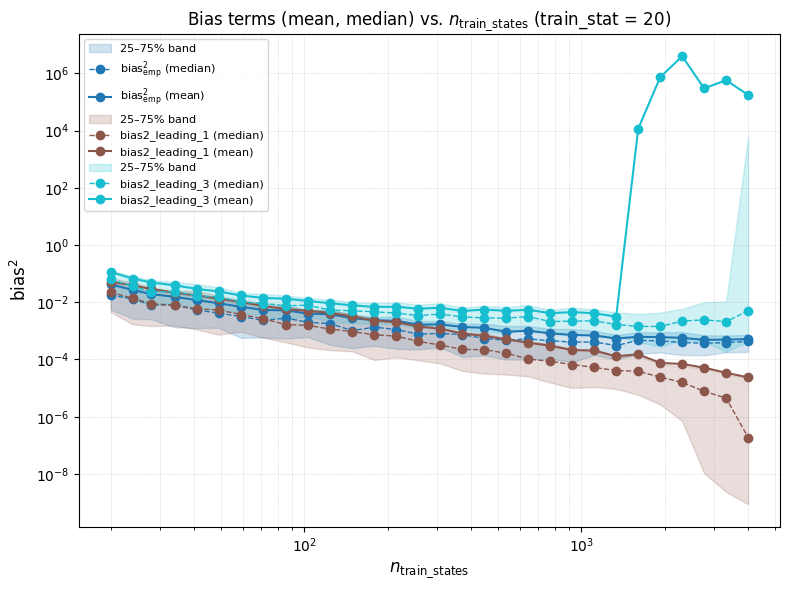

In [ ]:
plot_aggregated_stats(
    data=Bias2ExperimentsManager.load_df('data_20trainstat.pkl'),
    base_cols=['bias2_real'],
    x_col='n_train_states', figure_split_col='train_stat',
    stats_to_plot=['mean', 'median'], quantiles=(0.25, 0.75),
    base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
    custom_xlabel=r'$n_{\mathrm{train\_states}}$',
    custom_ylabel=r'$\mathrm{bias}^2$'
)

plot_aggregated_stats(
    data=Bias2ExperimentsManager.load_df('data_20trainstat.pkl'),
    base_cols=['bias2_real', 'bias2_leading_1', 'bias2_leading_3'],
    x_col='n_train_states', figure_split_col='train_stat',
    stats_to_plot=['mean', 'median'], quantiles=(0.25, 0.75),
    base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
    custom_xlabel=r'$n_{\mathrm{train\_states}}$',
    custom_ylabel=r'$\mathrm{bias}^2$'
)

This was saved with an old version of the code, no metadata is available.


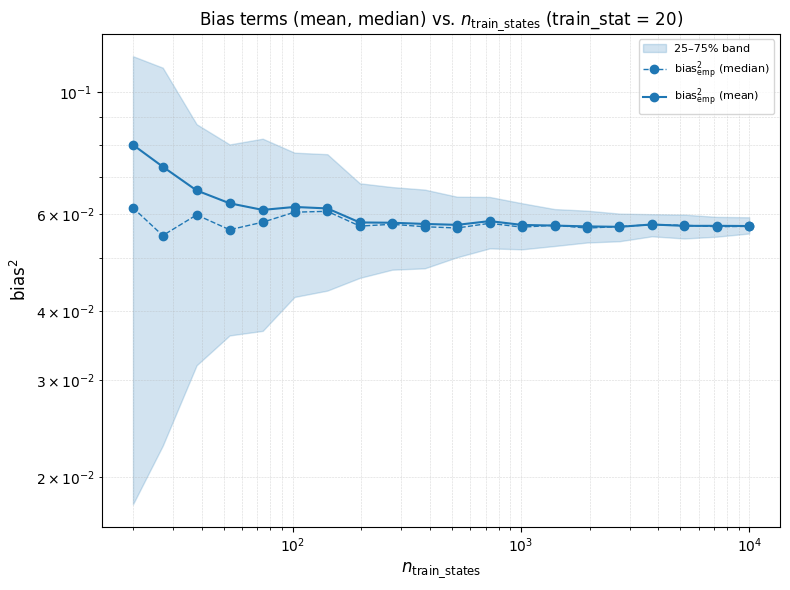

This was saved with an old version of the code, no metadata is available.


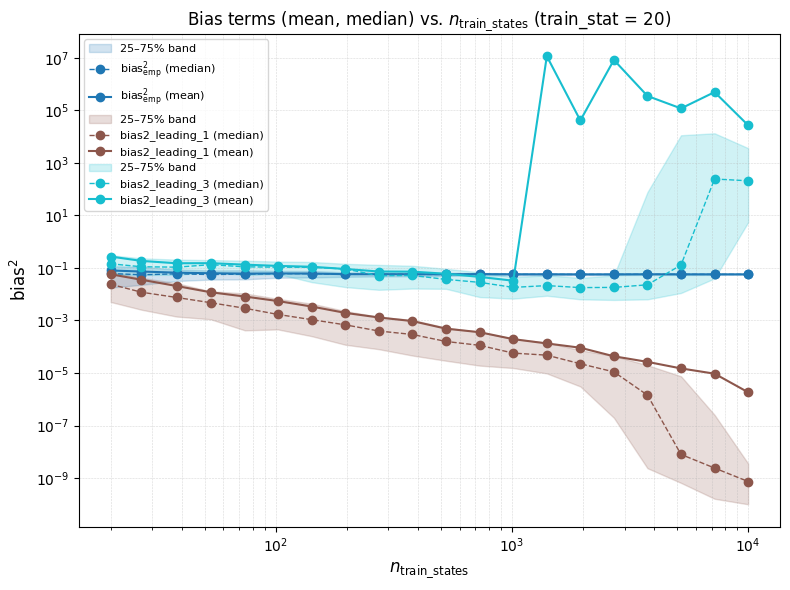

In [ ]:
plot_aggregated_stats(
    data=Bias2ExperimentsManager.load_df('data_20trainstat_2.pkl'),
    base_cols=['bias2_real'],
    x_col='n_train_states', figure_split_col='train_stat',
    stats_to_plot=['mean', 'median'], quantiles=(0.25, 0.75),
    base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
    custom_xlabel=r'$n_{\mathrm{train\_states}}$',
    custom_ylabel=r'$\mathrm{bias}^2$'
)

plot_aggregated_stats(
    data=Bias2ExperimentsManager.load_df('data_20trainstat_2.pkl'),
    base_cols=['bias2_real', 'bias2_leading_1', 'bias2_leading_3'],
    x_col='n_train_states', figure_split_col='train_stat',
    stats_to_plot=['mean', 'median'], quantiles=(0.25, 0.75),
    base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
    custom_xlabel=r'$n_{\mathrm{train\_states}}$',
    custom_ylabel=r'$\mathrm{bias}^2$'
)

This was saved with an old version of the code, no metadata is available.


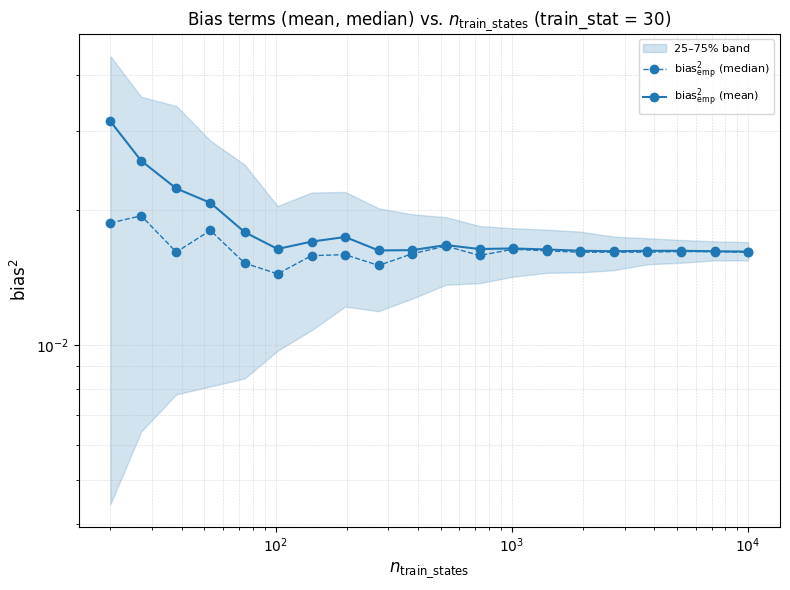

This was saved with an old version of the code, no metadata is available.


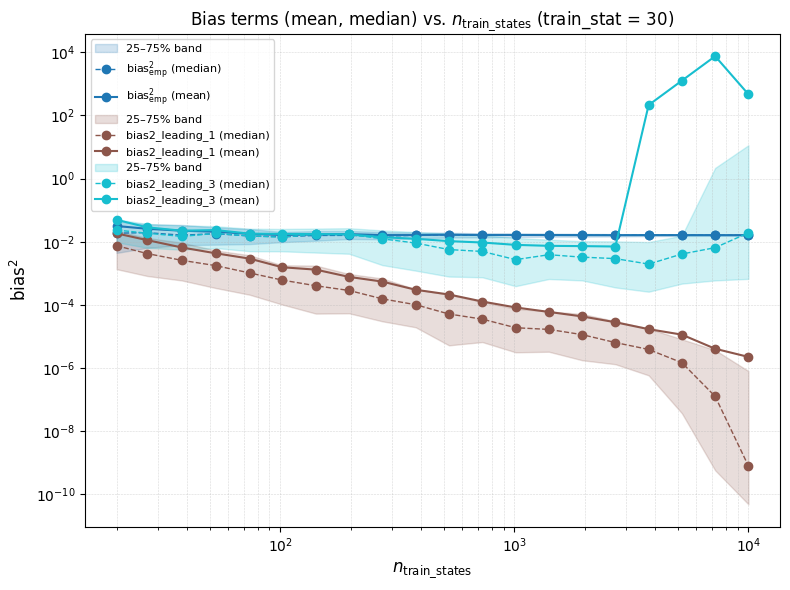

In [ ]:
plot_aggregated_stats(
    data=Bias2ExperimentsManager.load_df('data_30trainstat.pkl'),
    base_cols=['bias2_real'],
    x_col='n_train_states', figure_split_col='train_stat',
    stats_to_plot=['mean', 'median'], quantiles=(0.25, 0.75),
    base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
    custom_xlabel=r'$n_{\mathrm{train\_states}}$',
    custom_ylabel=r'$\mathrm{bias}^2$'
)

plot_aggregated_stats(
    data=Bias2ExperimentsManager.load_df('data_30trainstat.pkl'),
    base_cols=['bias2_real', 'bias2_leading_1', 'bias2_leading_3'],
    x_col='n_train_states', figure_split_col='train_stat',
    stats_to_plot=['mean', 'median'], quantiles=(0.25, 0.75),
    base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
    custom_xlabel=r'$n_{\mathrm{train\_states}}$',
    custom_ylabel=r'$\mathrm{bias}^2$'
)

In [ ]:
pinv(np.random.randn(20, 10**4))

array([[-2.24567102e-04,  9.06870806e-05,  1.57460305e-04, ...,
        -4.40586491e-05,  4.41739204e-05,  4.52482580e-05],
       [-1.44378619e-04, -5.22629025e-06, -1.66287000e-05, ...,
         1.23300180e-04, -2.44922898e-04, -2.61328719e-05],
       [ 1.30077301e-05,  2.40974980e-04, -1.09958378e-04, ...,
         7.05766372e-05,  5.84608435e-06,  3.61440530e-05],
       ...,
       [ 5.60151345e-06,  7.52873848e-05, -1.04590222e-04, ...,
        -2.32339705e-04,  1.37345021e-04,  9.07217920e-05],
       [ 1.40779781e-05,  2.10164876e-04, -6.04842402e-05, ...,
        -1.87996457e-05, -2.00640693e-05,  4.71482783e-05],
       [-1.04753013e-04,  8.08904235e-05, -5.45161045e-05, ...,
         1.09726725e-04, -4.76187126e-05,  6.58375298e-05]])

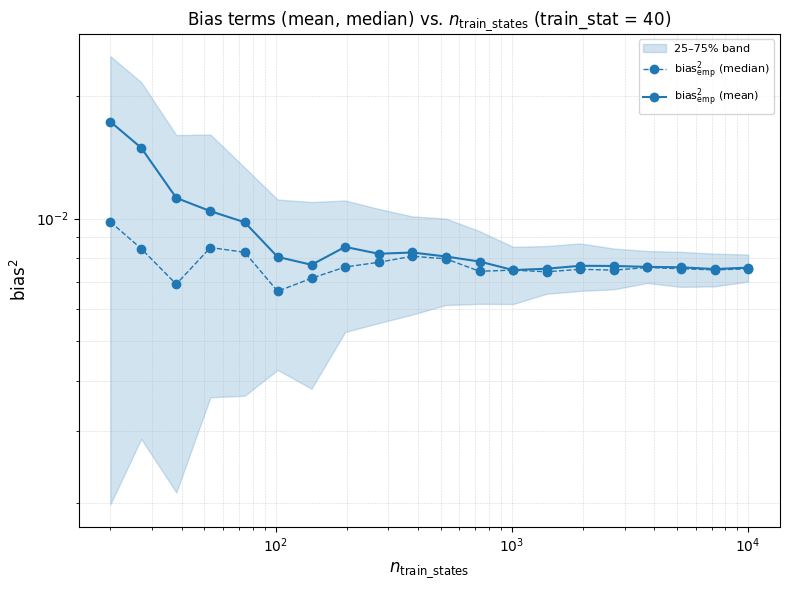

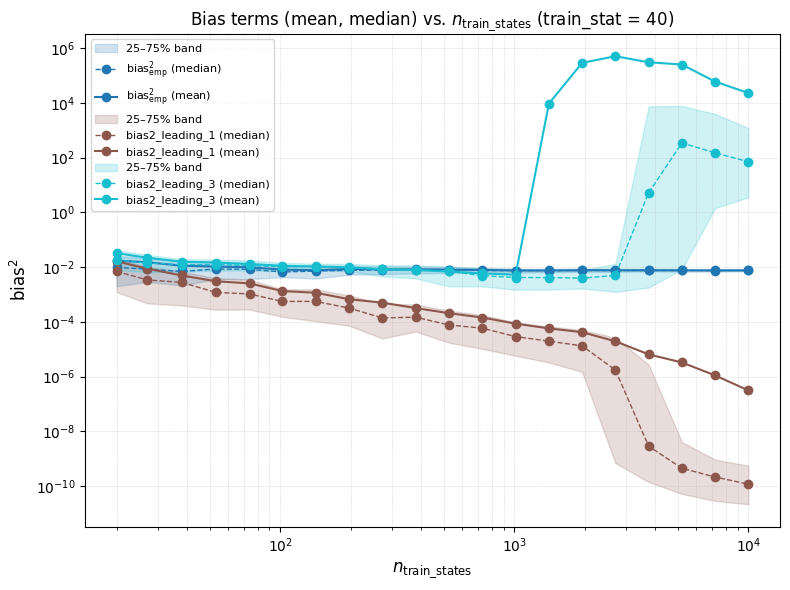

In [ ]:
plot_aggregated_stats(
    data=Bias2ExperimentsManager.load_df('data_40trainstat.pkl'),
    base_cols=['bias2_real'],
    x_col='n_train_states', figure_split_col='train_stat',
    stats_to_plot=['mean', 'median'], quantiles=(0.25, 0.75),
    base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
    custom_xlabel=r'$n_{\mathrm{train\_states}}$',
    custom_ylabel=r'$\mathrm{bias}^2$'
)

plot_aggregated_stats(
    data=Bias2ExperimentsManager.load_df('data_40trainstat.pkl'),
    base_cols=['bias2_real', 'bias2_leading_1', 'bias2_leading_3'],
    x_col='n_train_states', figure_split_col='train_stat',
    # y_value_filter_max=1,
    stats_to_plot=['mean', 'median'], quantiles=(0.25, 0.75),
    base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
    custom_xlabel=r'$n_{\mathrm{train\_states}}$',
    custom_ylabel=r'$\mathrm{bias}^2$'
)

In [ ]:
Bias2ExperimentsManager.load_df('data_50trainstat20outcomes.pkl')['n_train_states'].unique()

This was saved with an old version of the code, no metadata is available.


array([   20,    27,    38,    53,    74,   102,   142,   197,   273,
         379,   526,   730,  1013,  1405,  1948,  2702,  3748,  5198,
        7210, 10000], dtype=int64)

This was saved with an old version of the code, no metadata is available.


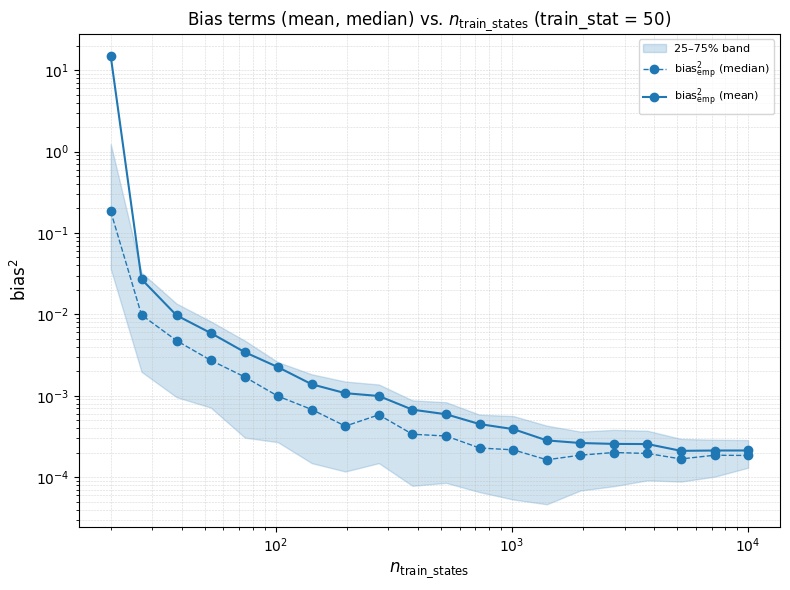

This was saved with an old version of the code, no metadata is available.


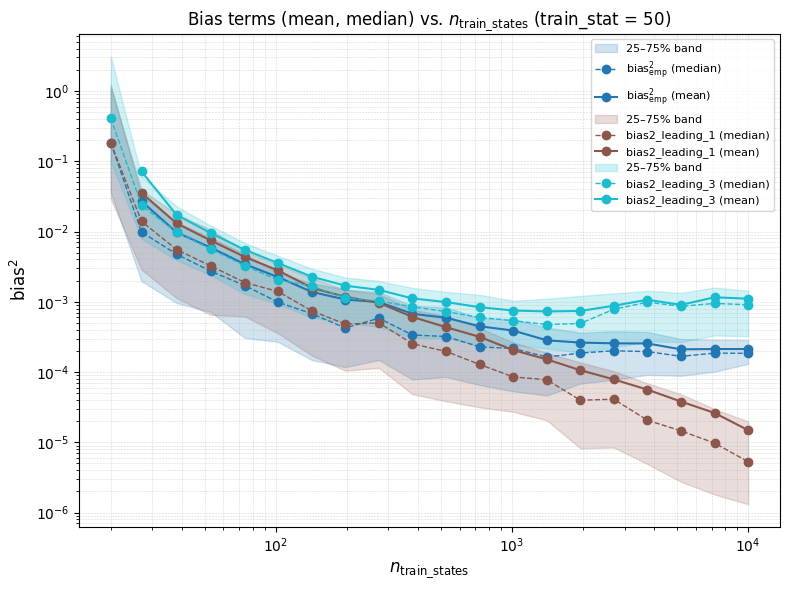

In [ ]:
plot_aggregated_stats(
    data=Bias2ExperimentsManager.load_df('data_50trainstat20outcomes.pkl'),
    base_cols=['bias2_real'],
    x_col='n_train_states', figure_split_col='train_stat',
    stats_to_plot=['mean', 'median'], quantiles=(0.25, 0.75),
    base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
    custom_xlabel=r'$n_{\mathrm{train\_states}}$',
    custom_ylabel=r'$\mathrm{bias}^2$'
)

plot_aggregated_stats(
    data=Bias2ExperimentsManager.load_df('data_50trainstat20outcomes.pkl'),
    base_cols=['bias2_real', 'bias2_leading_1', 'bias2_leading_3'],
    x_col='n_train_states', figure_split_col='train_stat',
    y_value_filter_max=0.1,
    stats_to_plot=['mean', 'median'], quantiles=(0.25, 0.75),
    base_labels={'bias2_real': r'$\mathrm{bias}^2_{\rm emp}$'},
    custom_xlabel=r'$n_{\mathrm{train\_states}}$',
    custom_ylabel=r'$\mathrm{bias}^2$'
)

In [ ]:
np.linalg.svd(QuantumKetsBatch(random_kets(dim=2, num_kets=10**4)).vectorise(), compute_uv=False)

array([70.71730557, 41.06576208, 40.72874062, 40.66737715])

In [ ]:
train_stat = 20
random_povm = random_rank1_povm(2, 10)
random_states = QuantumKetsBatch(random_kets(dim=2, num_kets=10**4))
test_state = QuantumKet(qutip.rand_ket(2).full().flatten())
true_P = random_states.measure_povm(random_povm, statistics=np.inf, return_frequencies=True)
dirty_P = random_states.measure_povm(random_povm, statistics=20, return_frequencies=True)
mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)

vO = test_state.vectorise().flatten()
vsigma = QuantumOperator(qutip.sigmax().full()).vectorise().flatten()
Mmu = random_povm.vectorise()
Mrho = random_states.vectorise()

(vO @ pinv(Mmu).T @ mb.X11 @ pinv(Mrho) @ vsigma) ** 2 / train_stat

1.6706895216228887e-06

# Old shit

Training with different statistics: 100%|██████████| 20/20 [00:03<00:00,  6.09it/s]


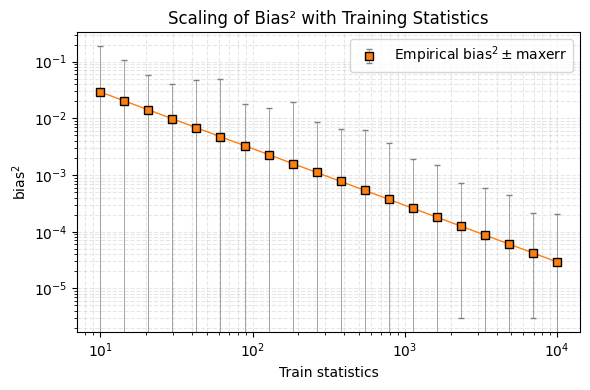

In [ ]:
def theoretical_bias2(training_states, test_state, target_obs, povm, statistics=1):
    qelm_inf = QELM.QELM.train_from_observables_and_states(
        training_states=training_states,
        test_states=[test_state],
        target_observables=[target_obs],
        povm=povm,
        statistics=np.inf
    )
    w_true = qelm_inf.w.flatten()
    # True outcome probabilities at infinite stats
    P = measure_povm(training_states, povm, statistics=np.inf, return_frequencies=True)
    # Vectorised test state mapping
    Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
    vrho = np.linalg.pinv(Mrho) @ QuantumState(test_state).vectorise()

    term1 = np.dot(w_true**2, P).dot(vrho**2)
    term2 = (np.dot(w_true, P)**2).dot(vrho**2)
    return (term1 - term2) / statistics

dim = 2
n_states = 50
n_outcomes = 10
stats_list = logspace(10, 10000, num=20)
n_realizations = 40  # number of independent runs per shot count
# Prepare states, POVM, and tomography ingredients
training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
test_state = qutip.rand_ket(dim)
target_obs = qutip.sigmax()
povm = random_rank1_povm(dim, n_outcomes)

# Pre-train at infinite statistics to get the “true” weights and test labels

base_th_bias2 = theoretical_bias2(training_states, test_state, target_obs, povm, statistics=1)
# Containers for results
bias2_th = []
bias2_emp = []
bias2_emp_err = []
for stats in tqdm(stats_list, desc="Training with different statistics"):
    bias2_theory = base_th_bias2 / stats
    # empirical bias^2 over multiple realizations
    bias2_vals : List[float] = []
    for _ in tqdm(range(n_realizations), desc=f"Training with {stats} statistics", leave=False):
        qelm_fin = QELM.QELM.train_from_observables_and_states(
            training_states=training_states,
            test_states=[test_state],
            target_observables=[target_obs],
            povm=povm,
            statistics=(stats, np.inf)
        )
        bias2_vals.append(qelm_fin.bias2()[0])
    bias2_vals_arr = np.array(bias2_vals)
    mean_emp = bias2_vals_arr.mean()
    bias2_th.append(bias2_theory)
    bias2_emp.append(mean_emp)
    bias2_emp_err.append((mean_emp - bias2_vals_arr.min(), bias2_vals_arr.max() - mean_emp))

# Assemble DataFrame
df = pd.DataFrame({
    'stats_list': stats_list,
    'bias2_theory': bias2_th,
    'bias2_empirical': bias2_emp,
    'bias2_emp_err': bias2_emp_err
})

plot_data_with_error_bars(
    df=df,
    x_col='stats_list', y_col='bias2_theory', y_err_col='bias2_emp_err',
    title='Scaling of Bias² with Training Statistics',
    xlabel='Train statistics',
    ylabel=r'$\mathrm{bias}^2$',
    legend=True, xscale='log', yscale='log'
)

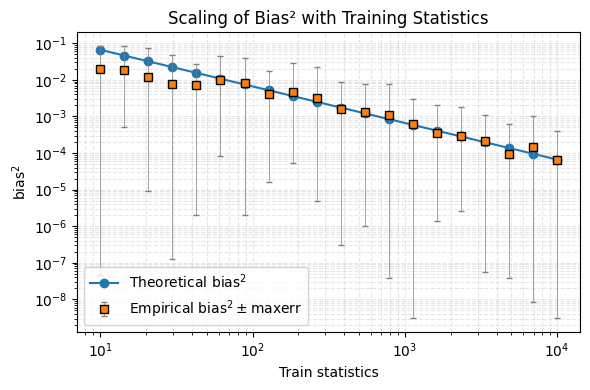

In [ ]:
def theoretical_bias2(training_states, test_state, povm, w_true, statistics=1):
    # True outcome probabilities at infinite stats
    P = measure_povm(training_states, povm, statistics=np.inf, return_frequencies=True)
    # Vectorised test state mapping
    Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
    vrho = np.linalg.pinv(Mrho) @ QuantumState(test_state).vectorise()

    term1 = np.dot(w_true**2, P).dot(vrho**2)
    term2 = (np.dot(w_true, P)**2).dot(vrho**2)
    return (term1 - term2) / statistics

dim = 2
n_states = 50
n_outcomes = 10
stats_list = logspace(10, 10000, num=20)
n_realizations = 40  # number of independent runs per shot count
# Prepare states, POVM, and tomography ingredients
training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
test_state = qutip.rand_ket(dim)
povm = random_rank1_povm(dim, n_outcomes)

true_P = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)


# Pre-train at infinite statistics to get the “true” weights and test labels
qelm_inf = QELM.QELM.train_from_observables_and_states(
    training_states=training_states,
    test_states=[test_state],
    target_observables=[qutip.sigmax()],
    povm=povm,
    statistics=np.inf
)
w_true    = qelm_inf.w.flatten()
freq_inf  = qelm_inf.test.frequencies.flatten()
label_inf = qelm_inf.test.labels.flatten()
base_th_bias2 = theoretical_bias2(training_states, test_state, povm, w_true, statistics=1)

# Containers for results
bias2_th = []
bias2_emp = []
bias2_emp_err_low = []
bias2_emp_err_high = []

for n in stats_list:
    bias2_theory = base_th_bias2 / n

    # empirical bias^2 over multiple realizations
    emp_vals = []
    for _ in range(n_realizations):
        qelm_fin = QELM.QELM.train_from_observables_and_states(
            training_states=training_states,
            test_states=[test_state],
            target_observables=[qutip.sigmax()],
            povm=povm,
            statistics=(n, np.inf)
        )
        emp_vals.append(qelm_fin.bias2()[0])

    emp_vals = np.array(emp_vals)
    mean_emp = emp_vals.mean()
    # se_emp   = emp_vals.std(ddof=1) / np.sqrt(n_realizations)

    # store
    bias2_th.append(bias2_theory)
    bias2_emp.append(mean_emp)
    bias2_emp_err_high.append(emp_vals.max() - mean_emp)
    bias2_emp_err_low.append(mean_emp - emp_vals.min())

# Assemble DataFrame
df = pd.DataFrame({
    'stats_list': stats_list,
    'bias2_theory': bias2_th,
    'bias2_empirical': bias2_emp,
    'bias2_emp_err_high': bias2_emp_err_high,
    'bias2_emp_err_low': bias2_emp_err_low
})

# Plot with error bars
plt.figure(figsize=(6,4))
# theoretical curve
plt.plot(df['stats_list'], df['bias2_theory'],
         marker='o', label=r'Theoretical $\mathrm{bias}^2$')
# empirical mean ± standard error
plt.errorbar(
    df['stats_list'], df['bias2_empirical'],
    yerr=[df['bias2_emp_err_low'], df['bias2_emp_err_high']],
    marker='s', ls='none',
    markersize=6,           # larger markers
    markeredgewidth=1,
    markeredgecolor='black',
    markerfacecolor='C1',
    alpha=1.0,              # fully opaque points
    ecolor='gray',          # error bars in gray
    elinewidth=0.5,         # thinner error bars
    capsize=2,              # small caps
    capthick=0.5,
    label=r'Empirical $\mathrm{bias}^2 \pm{\rm maxerr}$'
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Train statistics')
plt.ylabel(r'$\mathrm{bias}^2$')
plt.title('Scaling of Bias² with Training Statistics')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


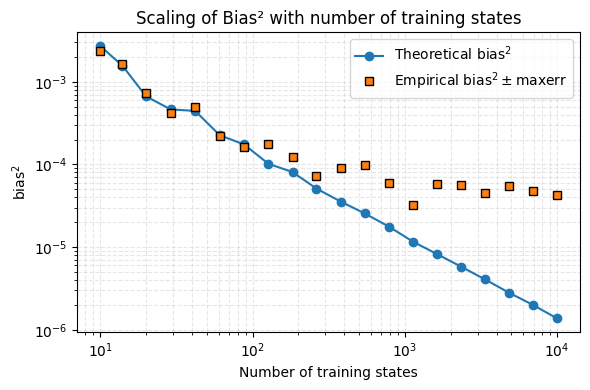

In [ ]:
def theoretical_bias2(training_states, test_state, povm, w_true, statistics=1):
    # true outcome probabilities (infinite train stats)
    P = measure_povm(training_states, povm, statistics=np.inf, return_frequencies=True)
    # vectorised train states and test state
    Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
    vrho = np.linalg.pinv(Mrho) @ QuantumState(test_state).vectorise()

    term1 = np.dot(w_true**2, P).dot(vrho**2)
    term2 = (np.dot(w_true, P)**2).dot(vrho**2)
    return (term1 - term2) / statistics

dim = 2
# n_states = 50
n_outcomes = 20
train_stat = 10**3
n_realizations = 50  # number of independent runs per shot count
# Prepare states, POVM, and tomography ingredients
test_state = qutip.rand_ket(dim)
povm = sic_povm()

# Containers for results
bias2_th = []
bias2_emp = []
bias2_emp_err_low = []
bias2_emp_err_high = []

n_states_list = logspace(10, 10000, num=20).astype(int)
for n_states in n_states_list:
    training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
    true_P = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
    qelm_inf = QELM.QELM.train_from_observables_and_states(
        training_states=training_states,
        test_states=[test_state],
        target_observables=[qutip.sigmax()],
        povm=povm,
        statistics=np.inf
    )
    w_true    = qelm_inf.w.flatten()
    freq_inf  = qelm_inf.test.frequencies.flatten()
    label_inf = qelm_inf.test.labels.flatten()
    bias2_theory = theoretical_bias2(training_states, test_state, povm, w_true, statistics=train_stat)

    # empirical bias^2 over multiple realizations
    emp_vals = []
    for _ in range(n_realizations):
        qelm_fin = QELM.QELM.train_from_observables_and_states(
            training_states=training_states,
            test_states=[test_state],
            target_observables=[qutip.sigmax()],
            povm=povm,
            statistics=(train_stat, np.inf)
        )
        emp_vals.append(qelm_fin.bias2()[0])

    emp_vals = np.array(emp_vals)
    mean_emp = emp_vals.mean()
    # se_emp   = emp_vals.std(ddof=1) / np.sqrt(n_realizations)

    # store
    bias2_th.append(bias2_theory)
    bias2_emp.append(mean_emp)
    bias2_emp_err_high.append(emp_vals.max() - mean_emp)
    bias2_emp_err_low.append(mean_emp - emp_vals.min())

# Assemble DataFrame
df = pd.DataFrame({
    'n_states_list': n_states_list,
    'bias2_theory': bias2_th,
    'bias2_empirical': bias2_emp,
    'bias2_emp_err_high': bias2_emp_err_high,
    'bias2_emp_err_low': bias2_emp_err_low
})

# Plot with error bars
plt.figure(figsize=(6,4))
# theoretical curve
plt.plot(df['n_states_list'], df['bias2_theory'],
         marker='o', label=r'Theoretical $\mathrm{bias}^2$')
# empirical mean ± standard error
plt.errorbar(
    df['n_states_list'], df['bias2_empirical'],
    # yerr=[df['bias2_emp_err_low'], df['bias2_emp_err_high']],
    marker='s', ls='none',
    markersize=6,           # larger markers
    markeredgewidth=1,
    markeredgecolor='black',
    markerfacecolor='C1',
    alpha=1.0,              # fully opaque points
    ecolor='gray',          # error bars in gray
    elinewidth=0.5,         # thinner error bars
    capsize=2,              # small caps
    capthick=0.5,
    label=r'Empirical $\mathrm{bias}^2 \pm{\rm maxerr}$'
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of training states')
plt.ylabel(r'$\mathrm{bias}^2$')
plt.title('Scaling of Bias² with number of training states')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Training with different number of states: 100%|██████████| 20/20 [06:33<00:00, 19.66s/it]


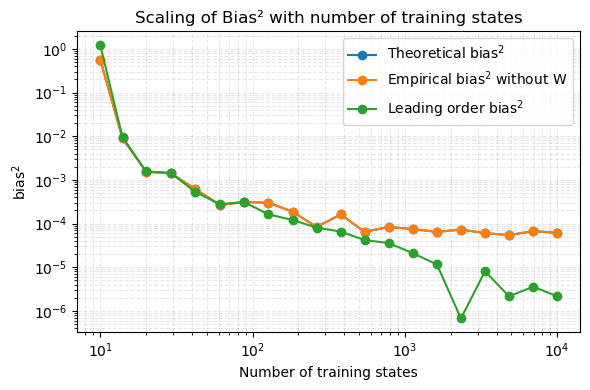

In [ ]:
dim = 2
# n_states = 50
n_outcomes = 10
train_stat = 10**3
n_realizations = 50  # number of independent runs per shot count
# Prepare states, POVM, and tomography ingredients
test_state = qutip.rand_ket(dim)
# povm = sic_povm()
povm = random_rank1_povm(dim, n_outcomes)
target_obs = qutip.sigmax()
vO = QuantumState(target_obs).vectorise()
# vectorized representation of the POVM (each column an effect)
Mmu = np.array([QuantumState(mu).vectorise() for mu in povm]).T

# Containers for results
# bias2_th = []
bias2_real_mean_list = []
bias2_real_err_low = []
bias2_real_err_high = []

bias2_real_mean_list_2 = []  # same but computed without passing through the W
bias2_real_err_low_2 = []
bias2_real_err_high_2 = []

bias2_leading_mean_list = []

n_states_list = logspace(10, 10**4, num=20).astype(int)
for n_states in tqdm(n_states_list, desc="Training with different number of states"):
    training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
    # true_P = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
    qelm_inf = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state],
                                                           target_observables=[target_obs], povm=povm, statistics=np.inf)
    true_w = qelm_inf.w.flatten()
    true_P = qelm_inf.train.frequencies
    true_test_P = qelm_inf.test.frequencies
    Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
    vsigma = QuantumState(test_state).vectorise()
    # label_inf = qelm_inf.test.labels.flatten()
    # bias2_theory = theoretical_bias2(training_states, test_state, povm, w_true, statistics=train_stat)
    # check that true_P is the same as freq_inf
    # empirical bias^2 over multiple realizations
    bias2_real_vals = []
    bias2_real_vals_2 = [] # same but computed without passing through the W
    bias2_leading_vals = []
    for _ in tqdm(range(n_realizations), desc=f"Training with {n_states} states", leave=False):
        # dirty_P = measure_povm(states=training_states, povm=povm, statistics=train_stat, return_frequencies=True)
        qelm_fin = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state], sampling_method='poisson',
                                                               target_observables=[target_obs], povm=povm, statistics=(train_stat, np.inf))
        dirty_w = qelm_fin.w.flatten()
        dirty_P = qelm_fin.train.frequencies
        # extract and process the X matrix
        X = (dirty_P - true_P) * np.sqrt(train_stat)
        # project onto support and image of the true P
        pi_supp = np.linalg.pinv(true_P) @ true_P
        pi_im = true_P @ np.linalg.pinv(true_P)
        # print(true_P.shape, dirty_P.shape, pi_supp.shape, pi_im.shape)
        X11 = pi_im @ X @ pi_supp
        X12 = pi_im @ X @ (np.eye(true_P.shape[1]) - pi_supp)
        X21 = (np.eye(len(true_P)) - pi_im) @ X @ pi_supp
        X22 = (np.eye(len(true_P)) - pi_im) @ X @ (np.eye(true_P.shape[1]) - pi_supp)
        # compute the Schur complement
        scX = X11 - X12 @ np.linalg.pinv(X22) @ X21
        # print(X11, X12 @ np.linalg.pinv(X22) @ X21, X22)
        # print('X12', X12)
        # print('X22inv', np.linalg.pinv(X22))
        # print(scX)
        # raise NotImplementedError("Schur complement computation not implemented yet")
        # compute exact bias^2 (for this training realization)
        bias2_real = ((dirty_w - true_w) @ true_test_P) ** 2
        bias2_real_vals.append(bias2_real)
        # same but computed without passing through the W
        bias2_real_2 = vO.T @ Mrho @ (np.linalg.pinv(dirty_P) - np.linalg.pinv(true_P)) @ Mmu.T @ vsigma
        bias2_real_2 = bias2_real_2 ** 2
        bias2_real_vals_2.append(bias2_real_2)
        # compute bias^2 from the expansion formula
        bias2_leading = vO.T @ np.linalg.pinv(Mmu).T @ scX @ np.linalg.pinv(Mrho) @ vsigma
        bias2_leading = bias2_leading ** 2 / train_stat
        bias2_leading_vals.append(bias2_leading)




    bias2_real_vals = np.array(bias2_real_vals)
    bias2_real_mean = bias2_real_vals.mean()
    bias2_real_mean_list.append(bias2_real_mean)
    bias2_real_err_high.append(bias2_real_vals.max() - bias2_real_mean)
    bias2_real_err_low.append(bias2_real_mean - bias2_real_vals.min())

    bias2_real_vals_2 = np.array(bias2_real_vals_2)
    bias2_real_mean_2 = bias2_real_vals_2.mean()
    bias2_real_mean_list_2.append(bias2_real_mean_2)
    bias2_real_err_high_2 = bias2_real_vals_2.max() - bias2_real_mean_2
    bias2_real_err_low_2 = bias2_real_mean_2 - bias2_real_vals_2.min()

    bias2_leading_mean = np.array(bias2_leading_vals).mean()
    bias2_leading_mean_list.append(bias2_leading_mean)


# Assemble DataFrame
df = pd.DataFrame({
    'n_states_list': n_states_list,
    'bias2_real': bias2_real_mean_list,
    'bias2_real_err_high': bias2_real_err_high,
    'bias2_real_err_low': bias2_real_err_low,
    'bias2_real_2': bias2_real_mean_list_2,
    'bias2_real_err_high_2': bias2_real_err_high_2,
    'bias2_real_err_low_2': bias2_real_err_low_2,
    'bias2_leading': bias2_leading_mean_list
})

# Plot with error bars
plt.figure(figsize=(6,4))
# theoretical curve
plt.plot(df['n_states_list'], df['bias2_real'], marker='o', label=r'Theoretical $\mathrm{bias}^2$')
plt.plot(df['n_states_list'], df['bias2_real_2'], marker='o', label=r'Empirical $\mathrm{bias}^2$ without W')
plt.plot(df['n_states_list'], df['bias2_leading'], marker='o', label=r'Leading order $\mathrm{bias}^2$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of training states')
plt.ylabel(r'$\mathrm{bias}^2$')
plt.title('Scaling of Bias² with number of training states')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Training with different number of states: 100%|██████████| 20/20 [04:29<00:00, 13.49s/it]


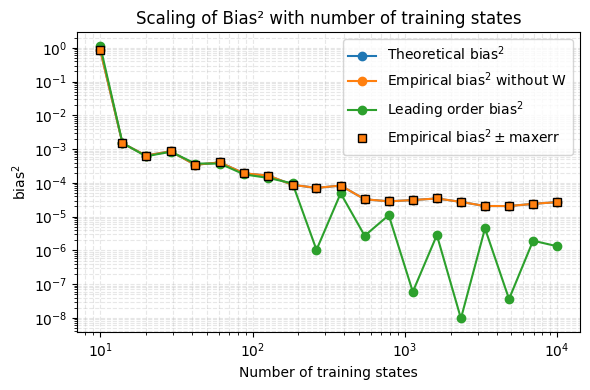

In [ ]:
dim = 2
# n_states = 50
n_outcomes = 10
train_stat = 10**3
n_realizations = 50  # number of independent runs per shot count
# Prepare states, POVM, and tomography ingredients
test_state = qutip.rand_ket(dim)
# povm = sic_povm()
povm = random_rank1_povm(dim, n_outcomes)
target_obs = qutip.sigmax()
vO = QuantumState(target_obs).vectorise()
# vectorized representation of the POVM (each column an effect)
Mmu = np.array([QuantumState(mu).vectorise() for mu in povm]).T

# Containers for results
# bias2_th = []
bias2_real_mean_list = []
bias2_real_err_low = []
bias2_real_err_high = []

bias2_real_mean_list_2 = []  # same but computed without passing through the W
bias2_real_err_low_2 = []
bias2_real_err_high_2 = []

bias2_leading_mean_list = []

n_states_list = logspace(10, 10**4, num=20).astype(int)
for n_states in tqdm(n_states_list, desc="Training with different number of states"):
    training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
    # true_P = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
    qelm_inf = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state],
                                                           target_observables=[target_obs], povm=povm, statistics=np.inf)
    true_w = qelm_inf.w.flatten()
    true_P = qelm_inf.train.frequencies
    true_test_P = qelm_inf.test.frequencies
    Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
    vsigma = QuantumState(test_state).vectorise()
    # label_inf = qelm_inf.test.labels.flatten()
    # bias2_theory = theoretical_bias2(training_states, test_state, povm, w_true, statistics=train_stat)
    # check that true_P is the same as freq_inf
    # empirical bias^2 over multiple realizations
    bias2_real_vals = []
    bias2_real_vals_2 = [] # same but computed without passing through the W
    bias2_leading_vals = []
    for _ in tqdm(range(n_realizations), desc=f"Training with {n_states} states", leave=False):
        # dirty_P = measure_povm(states=training_states, povm=povm, statistics=train_stat, return_frequencies=True)
        qelm_fin = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state],
                                                               target_observables=[target_obs], povm=povm, statistics=(train_stat, np.inf))
        dirty_w = qelm_fin.w.flatten()
        dirty_P = qelm_fin.train.frequencies
        # extract and process the X matrix
        X = (dirty_P - true_P) * np.sqrt(train_stat)
        # project onto support and image of the true P
        pi_supp = np.linalg.pinv(true_P) @ true_P
        pi_im = true_P @ np.linalg.pinv(true_P)
        # print(true_P.shape, dirty_P.shape, pi_supp.shape, pi_im.shape)
        X11 = pi_im @ X @ pi_supp
        X12 = pi_im @ X @ (np.eye(true_P.shape[1]) - pi_supp)
        X21 = (np.eye(len(true_P)) - pi_im) @ X @ pi_supp
        X22 = (np.eye(len(true_P)) - pi_im) @ X @ (np.eye(true_P.shape[1]) - pi_supp)
        # compute the Schur complement
        scX = X11 - X12 @ np.linalg.pinv(X22) @ X21
        # print(X11, X12 @ np.linalg.pinv(X22) @ X21, X22)
        # print('X12', X12)
        # print('X22inv', np.linalg.pinv(X22))
        # print(scX)
        # raise NotImplementedError("Schur complement computation not implemented yet")
        # compute exact bias^2 (for this training realization)
        bias2_real = ((dirty_w - true_w) @ true_test_P) ** 2
        bias2_real_vals.append(bias2_real)
        # same but computed without passing through the W
        bias2_real_2 = vO.T @ Mrho @ (np.linalg.pinv(dirty_P) - np.linalg.pinv(true_P)) @ Mmu.T @ vsigma
        bias2_real_2 = bias2_real_2 ** 2
        bias2_real_vals_2.append(bias2_real_2)
        # compute bias^2 from the expansion formula
        bias2_leading = vO.T @ np.linalg.pinv(Mmu).T @ scX @ np.linalg.pinv(Mrho) @ vsigma
        bias2_leading = bias2_leading ** 2 / train_stat
        bias2_leading_vals.append(bias2_leading)




    bias2_real_vals = np.array(bias2_real_vals)
    bias2_real_mean = bias2_real_vals.mean()
    bias2_real_mean_list.append(bias2_real_mean)
    bias2_real_err_high.append(bias2_real_vals.max() - bias2_real_mean)
    bias2_real_err_low.append(bias2_real_mean - bias2_real_vals.min())

    bias2_real_vals_2 = np.array(bias2_real_vals_2)
    bias2_real_mean_2 = bias2_real_vals_2.mean()
    bias2_real_mean_list_2.append(bias2_real_mean_2)
    bias2_real_err_high_2 = bias2_real_vals_2.max() - bias2_real_mean_2
    bias2_real_err_low_2 = bias2_real_mean_2 - bias2_real_vals_2.min()

    bias2_leading_mean = np.array(bias2_leading_vals).mean()
    bias2_leading_mean_list.append(bias2_leading_mean)


# Assemble DataFrame
df = pd.DataFrame({
    'n_states_list': n_states_list,
    'bias2_real': bias2_real_mean_list,
    'bias2_real_err_high': bias2_real_err_high,
    'bias2_real_err_low': bias2_real_err_low,
    'bias2_real_2': bias2_real_mean_list_2,
    'bias2_real_err_high_2': bias2_real_err_high_2,
    'bias2_real_err_low_2': bias2_real_err_low_2,
    'bias2_leading': bias2_leading_mean_list
})

# Plot with error bars
plt.figure(figsize=(6,4))
# theoretical curve
plt.plot(df['n_states_list'], df['bias2_real'], marker='o', label=r'Theoretical $\mathrm{bias}^2$')
plt.plot(df['n_states_list'], df['bias2_real_2'], marker='o', label=r'Empirical $\mathrm{bias}^2$ without W')
plt.plot(df['n_states_list'], df['bias2_leading'], marker='o', label=r'Leading order $\mathrm{bias}^2$')
# empirical mean ± standard error
plt.errorbar(
    df['n_states_list'], df['bias2_real'],
    # yerr=[df['bias2_real_err_low'], df['bias2_real_err_high']],
    marker='s', ls='none',
    markersize=6,           # larger markers
    markeredgewidth=1,
    markeredgecolor='black',
    markerfacecolor='C1',
    alpha=1.0,              # fully opaque points
    ecolor='gray',          # error bars in gray
    elinewidth=0.5,         # thinner error bars
    capsize=2,              # small caps
    capthick=0.5,
    label=r'Empirical $\mathrm{bias}^2 \pm{\rm maxerr}$'
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of training states')
plt.ylabel(r'$\mathrm{bias}^2$')
plt.title('Scaling of Bias² with number of training states')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


as above but trying to differentiate the terms of the leading order bias2 correction

Training with different number of states: 100%|██████████| 20/20 [02:23<00:00,  7.17s/it]


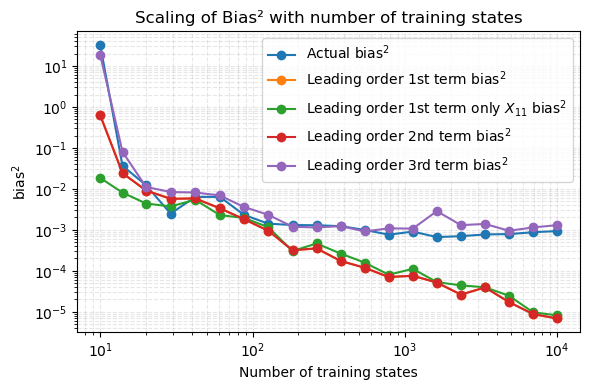

In [ ]:
def _():
    dim = 2
    # n_states = 50
    n_outcomes = 10
    train_stat = 10**2
    n_realizations = 10  # number of independent runs per shot count
    training_states_all = [qutip.rand_ket(dim) for _ in range(10**4)]
    test_state = qutip.rand_ket(dim)
    # povm = sic_povm()
    povm = random_rank1_povm(dim, n_outcomes)
    target_obs = qutip.sigmax()
    vO = QuantumState(target_obs).vectorise()
    # vectorized representation of the POVM (each column an effect)
    Mmu = np.array([QuantumState(mu).vectorise() for mu in povm]).T

    # Containers for results
    # bias2_th = []
    data = []

    n_states_list = logspace(10, 10**4, num=20).astype(int)
    for n_states in tqdm(n_states_list, desc="Training with different number of states"):
        training_states = training_states_all[:n_states]
        # true_P = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
        qelm_inf = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state],
                                                            target_observables=[target_obs], povm=povm, statistics=np.inf)
        true_w = qelm_inf.w.flatten()
        true_P = qelm_inf.train.frequencies
        true_test_P = qelm_inf.test.frequencies
        Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
        vsigma = QuantumState(test_state).vectorise()
        # empirical bias^2 over multiple realizations
        for realization in tqdm(range(n_realizations), desc=f"Training with {n_states} states", leave=False):
            # dirty_P = measure_povm(states=training_states, povm=povm, statistics=train_stat, return_frequencies=True)
            qelm_fin = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state], sampling_method='poisson',
                                                                target_observables=[target_obs], povm=povm, statistics=(train_stat, np.inf))
            dirty_w = qelm_fin.w.flatten()
            dirty_P = qelm_fin.train.frequencies
            Pinv = np.linalg.pinv(true_P)
            # extract and process the X matrix
            X = (dirty_P - true_P) * np.sqrt(train_stat)
            # project onto support and image of the true P
            pi_supp = Pinv @ true_P
            pi_im = true_P @ Pinv
            X11 = pi_im @ X @ pi_supp
            X12 = pi_im @ X @ (np.eye(true_P.shape[1]) - pi_supp)
            X21 = (np.eye(len(true_P)) - pi_im) @ X @ pi_supp
            X22 = (np.eye(len(true_P)) - pi_im) @ X @ (np.eye(true_P.shape[1]) - pi_supp)
            scX_2 = X12 @ np.linalg.pinv(X22) @ X21
            scX = X11 - scX_2 # Schur complement
            Pi2 = np.eye(X22.shape[1]) - np.linalg.pinv(X22) @ X22
            Y = np.eye(X21.shape[1]) + X21.T @ np.linalg.pinv(X22 @ X22.T) @ X21
            Mmuinv = np.linalg.pinv(Mmu)
            Mrhoinv = np.linalg.pinv(Mrho)
            # compute exact bias^2 (for this training realization)
            bias2_real = ((dirty_w - true_w) @ true_test_P) ** 2
            # compute bias^2 from the expansion formula
            bias2_leading_core_1 = vO.T @ Mmuinv.T @ scX @ Mrhoinv @ vsigma
            bias2_leading_1 = bias2_leading_core_1 ** 2 / train_stat
            bias2_leading_1_onlyX11 = (vO.T @ Mmuinv.T @ X11 @ Mrhoinv @ vsigma) ** 2 / train_stat
            bias2_leading_2 = scX @ Pinv @ scX - X12 @ Pi2 @ X12.T @ Pinv.T @ Y
            bias2_leading_core_2 = vO.T @ Mmuinv.T @ bias2_leading_2 @ Mrhoinv @ vsigma
            bias2_leading_2 = - 2 * bias2_leading_core_1 * bias2_leading_core_2 / train_stat**(3/2)
            bias2_leading_2 =+ bias2_leading_1

            bias2_leading_3 = bias2_leading_core_2 ** 2 / (train_stat ** 2)
            bias2_leading_3 += bias2_leading_1

            data.append({
                'n_states': n_states,
                'realization': realization,
                'bias2_real': bias2_real,
                'bias2_leading_1': bias2_leading_1,
                'bias2_leading_1_onlyX11': bias2_leading_1_onlyX11,
                'bias2_leading_2': bias2_leading_2,
                'bias2_leading_3': bias2_leading_3
            })

    df = pd.DataFrame(data)
    summary = df.groupby('n_states').agg(
        bias2_real_mean = ('bias2_real', 'mean'),
        bias2_lead1_mean = ('bias2_leading_1', 'mean'),
        bias2_lead1_onlyX11_mean = ('bias2_leading_1_onlyX11', 'mean'),
        bias2_lead2_mean = ('bias2_leading_2', 'mean'),
        bias2_lead3_mean = ('bias2_leading_3', 'mean')
    ).reset_index()

    # Plot with error bars
    plt.figure(figsize=(6,4))
    plt.plot(summary['n_states'], summary['bias2_real_mean'], marker='o', label=r'Actual $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead1_mean'], marker='o', label=r'Leading order 1st term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead1_onlyX11_mean'], marker='o', label=r'Leading order 1st term only $X_{11}$ $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead2_mean'], marker='o', label=r'Leading order 2nd term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_mean'], marker='o', label=r'Leading order 3rd term $\mathrm{bias}^2$')
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Number of training states'); plt.ylabel(r'$\mathrm{bias}^2$')
    plt.title('Scaling of Bias² with number of training states')
    plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.legend(); plt.tight_layout(); plt.show()
_()


Training with different number of states: 100%|██████████| 20/20 [06:40<00:00, 20.03s/it]


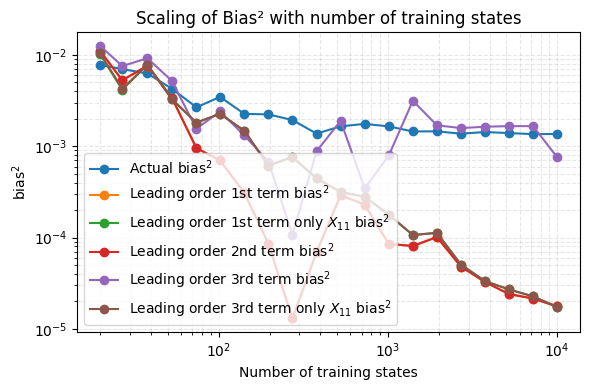

In [ ]:
def _():
    dim = 2
    n_outcomes = 10
    train_stat = 100
    n_realizations = 50  # number of independent runs per shot count
    training_states_all = [qutip.rand_ket(dim) for _ in range(10**4)]
    test_state = qutip.rand_ket(dim)
    povm = random_rank1_povm(dim, n_outcomes)
    target_obs = qutip.sigmax()
    vO = QuantumState(target_obs).vectorise()
    Mmu = np.array([QuantumState(mu).vectorise() for mu in povm]).T
    data = []
    n_states_list = logspace(20, len(training_states_all), num=20).astype(int)
    for n_states in tqdm(n_states_list, desc="Training with different number of states"):
        training_states = training_states_all[:n_states]
        # true_P = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
        qelm_inf = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state],
                                                            target_observables=[target_obs], povm=povm, statistics=np.inf)
        true_w = qelm_inf.w.flatten()
        true_P = qelm_inf.train.frequencies
        true_test_P = qelm_inf.test.frequencies
        Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
        vsigma = QuantumState(test_state).vectorise()
        # empirical bias^2 over multiple realizations
        for realization in tqdm(range(n_realizations), desc=f"Training with {n_states} states", leave=False):
            # dirty_P = measure_povm(states=training_states, povm=povm, statistics=train_stat, return_frequencies=True)
            qelm_fin = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state], sampling_method='standard',
                                                                target_observables=[target_obs], povm=povm, statistics=(train_stat, np.inf))
            dirty_w = qelm_fin.w.flatten()
            dirty_P = qelm_fin.train.frequencies
            Pinv = np.linalg.pinv(true_P)
            # extract and process the X matrix
            X = (dirty_P - true_P) * np.sqrt(train_stat)
            # project onto support and image of the true P
            pi_supp = Pinv @ true_P
            pi_im = true_P @ Pinv
            X11 = pi_im @ X @ pi_supp
            X12 = pi_im @ X @ (np.eye(true_P.shape[1]) - pi_supp)
            X21 = (np.eye(len(true_P)) - pi_im) @ X @ pi_supp
            X22 = (np.eye(len(true_P)) - pi_im) @ X @ (np.eye(true_P.shape[1]) - pi_supp)
            scX_2 = X12 @ np.linalg.pinv(X22) @ X21
            scX = X11 - scX_2 # Schur complement
            Pi2 = np.eye(X22.shape[1]) - np.linalg.pinv(X22) @ X22
            Y = np.eye(X21.shape[1]) + X21.T @ np.linalg.pinv(X22 @ X22.T) @ X21
            Mmuinv = np.linalg.pinv(Mmu)
            Mrhoinv = np.linalg.pinv(Mrho)
            # compute exact bias^2 (for this training realization)
            bias2_real = ((dirty_w - true_w) @ true_test_P) ** 2
            # compute bias^2 from the expansion formula
            bias2_leading_core_1 = vO.T @ Mmuinv.T @ scX @ Mrhoinv @ vsigma
            bias2_leading_1 = bias2_leading_core_1 ** 2 / train_stat
            bias2_leading_1_onlyX11 = (vO.T @ Mmuinv.T @ X11 @ Mrhoinv @ vsigma) ** 2 / train_stat

            bias2_leading_core_2 = scX @ Pinv @ scX - X12 @ Pi2 @ X12.T @ Pinv.T @ Y
            bias2_leading_core_2 = vO.T @ Mmuinv.T @ bias2_leading_core_2 @ Mrhoinv @ vsigma
            bias2_leading_2 = - 2 * bias2_leading_core_1 * bias2_leading_core_2 / train_stat**(3/2)
            bias2_leading_2 =+ bias2_leading_1

            bias2_leading_3 = bias2_leading_core_2 ** 2 / (train_stat ** 2)
            bias2_leading_3 += bias2_leading_1

            bias2_leading_3_onlyX11 = (vO.T @ Mmuinv.T @ (X11 @ Pinv @ X11) @ Mrhoinv @ vsigma) ** 2 / (train_stat ** 2)
            bias2_leading_3_onlyX11 += bias2_leading_1_onlyX11

            data.append({
                'n_states': n_states,
                'realization': realization,
                'bias2_real': bias2_real,
                'bias2_leading_1': bias2_leading_1,
                'bias2_leading_1_onlyX11': bias2_leading_1_onlyX11,
                'bias2_leading_2': bias2_leading_2,
                'bias2_leading_3': bias2_leading_3,
                'bias2_leading_3_onlyX11': bias2_leading_3_onlyX11
            })

    df = pd.DataFrame(data)
    summary = df.groupby('n_states').agg(
        bias2_real_mean = ('bias2_real', 'mean'),
        bias2_lead1_mean = ('bias2_leading_1', 'mean'),
        bias2_lead1_onlyX11_mean = ('bias2_leading_1_onlyX11', 'mean'),
        bias2_lead2_mean = ('bias2_leading_2', 'mean'),
        bias2_lead3_mean = ('bias2_leading_3', 'mean'),
        bias2_lead3_onlyX11_mean = ('bias2_leading_3_onlyX11', 'mean')
    ).reset_index()

    # Plot with error bars
    plt.figure(figsize=(6,4))
    plt.plot(summary['n_states'], summary['bias2_real_mean'], marker='o', label=r'Actual $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead1_mean'], marker='o', label=r'Leading order 1st term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead1_onlyX11_mean'], marker='o', label=r'Leading order 1st term only $X_{11}$ $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead2_mean'], marker='o', label=r'Leading order 2nd term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_mean'], marker='o', label=r'Leading order 3rd term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_onlyX11_mean'], marker='o', label=r'Leading order 3rd term only $X_{11}$ $\mathrm{bias}^2$')
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Number of training states'); plt.ylabel(r'$\mathrm{bias}^2$')
    plt.title('Scaling of Bias² with number of training states')
    plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.legend(); plt.tight_layout(); plt.show()
_()


Training with different number of states: 100%|██████████| 20/20 [05:36<00:00, 16.82s/it]


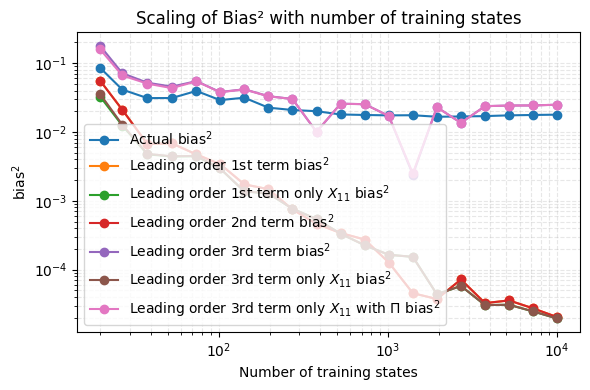

In [ ]:
def _():
    dim = 2
    n_outcomes = 10
    train_stat = 100
    n_realizations = 40  # number of independent runs per shot count
    training_states_all = [qutip.rand_ket(dim) for _ in range(10**4)]
    test_state = qutip.rand_ket(dim)
    povm = random_rank1_povm(dim, n_outcomes)
    target_obs = qutip.sigmax()
    vO = QuantumState(target_obs).vectorise()
    Mmu = np.array([QuantumState(mu).vectorise() for mu in povm]).T
    data = []
    n_states_list = logspace(20, len(training_states_all), num=20).astype(int)
    for n_states in tqdm(n_states_list, desc="Training with different number of states"):
        training_states = training_states_all[:n_states]
        # true_P = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
        qelm_inf = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state],
                                                            target_observables=[target_obs], povm=povm, statistics=np.inf)
        true_w = qelm_inf.w.flatten()
        true_P = qelm_inf.train.frequencies
        true_test_P = qelm_inf.test.frequencies
        Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
        vsigma = QuantumState(test_state).vectorise()
        # empirical bias^2 over multiple realizations
        for realization in tqdm(range(n_realizations), desc=f"Training with {n_states} states", leave=False):
            # dirty_P = measure_povm(states=training_states, povm=povm, statistics=train_stat, return_frequencies=True)
            qelm_fin = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state], sampling_method='standard',
                                                                target_observables=[target_obs], povm=povm, statistics=(train_stat, np.inf))
            dirty_w = qelm_fin.w.flatten()
            dirty_P = qelm_fin.train.frequencies
            Pinv = np.linalg.pinv(true_P)
            # extract and process the X matrix
            X = (dirty_P - true_P) * np.sqrt(train_stat)
            # project onto support and image of the true P
            pi_supp = Pinv @ true_P
            pi_im = true_P @ Pinv
            X11 = pi_im @ X @ pi_supp
            X12 = pi_im @ X @ (np.eye(true_P.shape[1]) - pi_supp)
            X21 = (np.eye(len(true_P)) - pi_im) @ X @ pi_supp
            X22 = (np.eye(len(true_P)) - pi_im) @ X @ (np.eye(true_P.shape[1]) - pi_supp)
            scX_2 = X12 @ np.linalg.pinv(X22) @ X21
            scX = X11 - scX_2 # Schur complement
            Pi2 = np.eye(X22.shape[1]) - np.linalg.pinv(X22) @ X22
            Y = np.eye(X21.shape[1]) + X21.T @ np.linalg.pinv(X22 @ X22.T) @ X21
            Mmuinv = np.linalg.pinv(Mmu)
            Mrhoinv = np.linalg.pinv(Mrho)
            # compute exact bias^2 (for this training realization)
            bias2_real = ((dirty_w - true_w) @ true_test_P) ** 2
            # compute bias^2 from the expansion formula
            bias2_leading_core_1 = vO.T @ Mmuinv.T @ scX @ Mrhoinv @ vsigma
            bias2_leading_1 = bias2_leading_core_1 ** 2 / train_stat
            bias2_leading_1_onlyX11 = (vO.T @ Mmuinv.T @ X11 @ Mrhoinv @ vsigma) ** 2 / train_stat

            bias2_leading_core_2 = scX @ Pinv @ scX - X12 @ Pi2 @ X12.T @ Pinv.T @ Y
            bias2_leading_core_2 = vO.T @ Mmuinv.T @ bias2_leading_core_2 @ Mrhoinv @ vsigma
            bias2_leading_2 = - 2 * bias2_leading_core_1 * bias2_leading_core_2 / train_stat**(3/2)
            bias2_leading_2 =+ bias2_leading_1

            bias2_leading_3 = bias2_leading_core_2 ** 2 / (train_stat ** 2)
            bias2_leading_3 += bias2_leading_1

            bias2_leading_3_onlyX11 = (vO.T @ Mmuinv.T @ (X11 @ Pinv @ X11) @ Mrhoinv @ vsigma) ** 2 / (train_stat ** 2)
            bias2_leading_3_onlyX11 += bias2_leading_1_onlyX11

            bias2_leading_3_onlyX11withPi = (vO.T @ Mmuinv.T @ (X11 @ Pinv @ X11 - X12 @ Pi2 @ X12.T @ Pinv.T @ Y) @ Mrhoinv @ vsigma) ** 2 / (train_stat ** 2)
            bias2_leading_3_onlyX11withPi += bias2_leading_1_onlyX11

            data.append({
                'n_states': n_states,
                'realization': realization,
                'bias2_real': bias2_real,
                'bias2_leading_1': bias2_leading_1,
                'bias2_leading_1_onlyX11': bias2_leading_1_onlyX11,
                'bias2_leading_2': bias2_leading_2,
                'bias2_leading_3': bias2_leading_3,
                'bias2_leading_3_onlyX11': bias2_leading_3_onlyX11,
                'bias2_leading_3_onlyX11withPi': bias2_leading_3_onlyX11withPi
            })

    df = pd.DataFrame(data)
    summary = df.groupby('n_states').agg(
        bias2_real_mean = ('bias2_real', 'mean'),
        bias2_lead1_mean = ('bias2_leading_1', 'mean'),
        bias2_lead1_onlyX11_mean = ('bias2_leading_1_onlyX11', 'mean'),
        bias2_lead2_mean = ('bias2_leading_2', 'mean'),
        bias2_lead3_mean = ('bias2_leading_3', 'mean'),
        bias2_lead3_onlyX11_mean = ('bias2_leading_3_onlyX11', 'mean'),
        bias2_lead3_onlyX11withPi_mean = ('bias2_leading_3_onlyX11withPi', 'mean')
    ).reset_index()

    # Plot with error bars
    plt.figure(figsize=(6,4))
    plt.plot(summary['n_states'], summary['bias2_real_mean'], marker='o', label=r'Actual $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead1_mean'], marker='o', label=r'Leading order 1st term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead1_onlyX11_mean'], marker='o', label=r'Leading order 1st term only $X_{11}$ $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead2_mean'], marker='o', label=r'Leading order 2nd term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_mean'], marker='o', label=r'Leading order 3rd term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_onlyX11_mean'], marker='o', label=r'Leading order 3rd term only $X_{11}$ $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_onlyX11withPi_mean'], marker='o', label=r'Leading order 3rd term only $X_{11}$ with $\Pi$ $\mathrm{bias}^2$')
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Number of training states'); plt.ylabel(r'$\mathrm{bias}^2$')
    plt.title('Scaling of Bias² with number of training states')
    plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.legend(); plt.tight_layout(); plt.show()
_()


In [ ]:
povm = random_rank1_povm(dim, n_outcomes)

Training with different number of states: 100%|██████████| 20/20 [06:06<00:00, 18.34s/it]


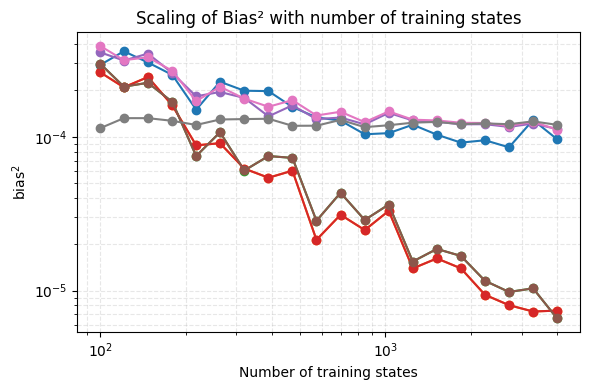

In [ ]:
def _():
    dim = 2
    n_outcomes = 20
    train_stat = 500
    n_realizations = 40  # number of independent runs per shot count
    # training_states_all = [qutip.rand_ket(dim) for _ in range(10**4)]
    test_state = qutip.rand_ket(dim)
    povm = random_rank1_povm(dim, n_outcomes)
    target_obs = qutip.sigmax()
    vO = QuantumState(target_obs).vectorise()
    Mmu = np.array([QuantumState(mu).vectorise() for mu in povm]).T
    data = []
    n_states_list = logspace(100, 4 * 10**3, num=20).astype(int)
    for n_states in tqdm(n_states_list, desc="Training with different number of states"):
        # empirical bias^2 over multiple realizations
        for realization in tqdm(range(n_realizations), desc=f"Training with {n_states} states", leave=False):
            training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
            # true_P = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
            qelm_inf = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state],
                                                                target_observables=[target_obs], povm=povm, statistics=np.inf)
            true_w = qelm_inf.w.flatten()
            true_P = qelm_inf.train.frequencies
            true_test_P = qelm_inf.test.frequencies
            Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
            vsigma = QuantumState(test_state).vectorise()
            # dirty_P = measure_povm(states=training_states, povm=povm, statistics=train_stat, return_frequencies=True)
            qelm_fin = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state], sampling_method='poisson',
                                                                target_observables=[target_obs], povm=povm, statistics=(train_stat, np.inf))
            dirty_w = qelm_fin.w.flatten()
            dirty_P = qelm_fin.train.frequencies
            Pinv = np.linalg.pinv(true_P)
            # extract and process the X matrix
            X = (dirty_P - true_P) * np.sqrt(train_stat)
            # project onto support and image of the true P
            pi_supp = Pinv @ true_P
            pi_im = true_P @ Pinv
            X11 = pi_im @ X @ pi_supp
            X12 = pi_im @ X @ (np.eye(true_P.shape[1]) - pi_supp)
            X21 = (np.eye(len(true_P)) - pi_im) @ X @ pi_supp
            X22 = (np.eye(len(true_P)) - pi_im) @ X @ (np.eye(true_P.shape[1]) - pi_supp)
            scX_2 = X12 @ np.linalg.pinv(X22) @ X21
            scX = X11 - scX_2 # Schur complement
            Pi2 = np.eye(X22.shape[1]) - np.linalg.pinv(X22) @ X22
            Y = np.eye(X21.shape[1]) + X21.T @ np.linalg.pinv(X22 @ X22.T) @ X21
            Mmuinv = np.linalg.pinv(Mmu)
            Mrhoinv = np.linalg.pinv(Mrho)
            # compute exact bias^2 (for this training realization)
            bias2_real = ((dirty_w - true_w) @ true_test_P) ** 2
            # compute bias^2 from the expansion formula
            bias2_leading_core_1 = vO.T @ Mmuinv.T @ scX @ Mrhoinv @ vsigma
            bias2_leading_1 = bias2_leading_core_1 ** 2 / train_stat
            bias2_leading_1_onlyX11 = (vO.T @ Mmuinv.T @ X11 @ Mrhoinv @ vsigma) ** 2 / train_stat

            bias2_leading_core_2 = scX @ Pinv @ scX - X12 @ Pi2 @ X12.T @ Pinv.T @ Y
            bias2_leading_core_2 = vO.T @ Mmuinv.T @ bias2_leading_core_2 @ Mrhoinv @ vsigma
            bias2_leading_2 = - 2 * bias2_leading_core_1 * bias2_leading_core_2 / train_stat**(3/2)
            bias2_leading_2 =+ bias2_leading_1

            bias2_leading_3 = bias2_leading_core_2 ** 2 / (train_stat ** 2)
            bias2_leading_3 += bias2_leading_1

            bias2_leading_3_onlyX11 = (vO.T @ Mmuinv.T @ (X11 @ Pinv @ X11) @ Mrhoinv @ vsigma) ** 2 / (train_stat ** 2)
            bias2_leading_3_onlyX11 += bias2_leading_1_onlyX11

            bias2_leading_3_onlyX11withPi = (vO.T @ Mmuinv.T @ (X11 @ Pinv @ X11 - X12 @ Pi2 @ X12.T @ Pinv.T @ Y) @ Mrhoinv @ vsigma) ** 2 / (train_stat ** 2)
            bias2_leading_3_onlyX11withPi += bias2_leading_1_onlyX11

            bias2_leading_3_true = (vO.T @ Mmuinv.T @ (X12 @ np.eye(X22.shape[1]) @ X12.T @ Pinv.T) @ Mrhoinv @ vsigma) ** 2 / (train_stat ** 2)

            data.append({
                'n_states': n_states,
                'realization': realization,
                'bias2_real': bias2_real,
                'bias2_leading_1': bias2_leading_1,
                'bias2_leading_1_onlyX11': bias2_leading_1_onlyX11,
                'bias2_leading_2': bias2_leading_2,
                'bias2_leading_3': bias2_leading_3,
                'bias2_leading_3_onlyX11': bias2_leading_3_onlyX11,
                'bias2_leading_3_onlyX11withPi': bias2_leading_3_onlyX11withPi,
                'bias2_leading_3_true': bias2_leading_3_true
            })

    df = pd.DataFrame(data)
    summary = df.groupby('n_states').agg(
        bias2_real_mean = ('bias2_real', 'mean'),
        bias2_lead1_mean = ('bias2_leading_1', 'mean'),
        bias2_lead1_onlyX11_mean = ('bias2_leading_1_onlyX11', 'mean'),
        bias2_lead2_mean = ('bias2_leading_2', 'mean'),
        bias2_lead3_mean = ('bias2_leading_3', 'mean'),
        bias2_lead3_onlyX11_mean = ('bias2_leading_3_onlyX11', 'mean'),
        bias2_lead3_onlyX11withPi_mean = ('bias2_leading_3_onlyX11withPi', 'mean'),
        bias2_lead3_true_mean = ('bias2_leading_3_true', 'mean')
    ).reset_index()

    # Plot with error bars
    plt.figure(figsize=(6,4))
    plt.plot(summary['n_states'], summary['bias2_real_mean'], marker='o', label=r'Actual $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead1_mean'], marker='o', label=r'Leading order 1st term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead1_onlyX11_mean'], marker='o', label=r'Leading order 1st term only $X_{11}$ $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead2_mean'], marker='o', label=r'Leading order 2nd term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_mean'], marker='o', label=r'Leading order 3rd term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_onlyX11_mean'], marker='o', label=r'Leading order 3rd term only $X_{11}$ $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_onlyX11withPi_mean'], marker='o', label=r'Leading order 3rd term only $X_{11}$ with $\Pi$ $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_true_mean'], marker='o', label=r'Leading order 3rd term true $\mathrm{bias}^2$')
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Number of training states'); plt.ylabel(r'$\mathrm{bias}^2$')
    plt.title('Scaling of Bias² with number of training states')
    plt.grid(True, which='both', ls='--', alpha=0.3)
    # plt.legend();
    plt.tight_layout(); plt.show()
_()


In [ ]:
sic_povm().elements

[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[0.5 0. ]
  [0.  0. ]],
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[0.16666667 0.23570226]
  [0.23570226 0.33333333]],
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[ 0.16666667+0.j         -0.11785113-0.20412415j]
  [-0.11785113+0.20412415j  0.33333333+0.j        ]],
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[ 0.16666667+0.j         -0.11785113+0.20412415j]
  [-0.11785113-0.20412415j  0.33333333+0.j        ]]]

In [ ]:
measure_povm(states=np.eye(2),
             povm=sic_povm(),
             statistics=10000, return_frequencies=True, sampling_method='poisson')

array([[0.5011, 0.    ],
       [0.1643, 0.334 ],
       [0.1715, 0.3328],
       [0.1715, 0.3255]])

Training with different number of states: 100%|██████████| 20/20 [03:31<00:00, 10.60s/it]


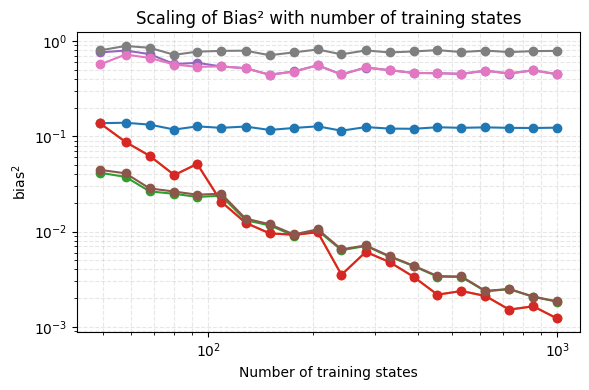

In [ ]:
def _():
    dim = 2
    n_outcomes = 20
    train_stat = 10
    n_realizations = 100  # number of independent runs per shot count
    # training_states_all = [qutip.rand_ket(dim) for _ in range(10**4)]
    test_state = qutip.rand_ket(dim)
    povm = random_rank1_povm(dim, n_outcomes)
    target_obs = qutip.sigmax()
    vO = QuantumState(target_obs).vectorise()
    Mmu = np.array([QuantumState(mu).vectorise() for mu in povm]).T
    data = []
    n_states_list = logspace(50, 10**3, num=20).astype(int)
    for n_states in tqdm(n_states_list, desc="Training with different number of states"):
        # empirical bias^2 over multiple realizations
        for realization in tqdm(range(n_realizations), desc=f"Training with {n_states} states", leave=False):
            training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
            # true_P = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
            qelm_inf = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state],
                                                                target_observables=[target_obs], povm=povm, statistics=np.inf)
            true_w = qelm_inf.w.flatten()
            true_P = qelm_inf.train.frequencies
            true_test_P = qelm_inf.test.frequencies
            Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
            vsigma = QuantumState(test_state).vectorise()
            # dirty_P = measure_povm(states=training_states, povm=povm, statistics=train_stat, return_frequencies=True)
            qelm_fin = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state], sampling_method='poisson',
                                                                target_observables=[target_obs], povm=povm, statistics=(train_stat, np.inf))
            dirty_w = qelm_fin.w.flatten()
            dirty_P = qelm_fin.train.frequencies
            Pinv = np.linalg.pinv(true_P)
            # extract and process the X matrix
            X = (dirty_P - true_P) * np.sqrt(train_stat)
            # project onto support and image of the true P
            pi_supp = Pinv @ true_P
            pi_im = true_P @ Pinv
            X11 = pi_im @ X @ pi_supp
            X12 = pi_im @ X @ (np.eye(true_P.shape[1]) - pi_supp)
            X21 = (np.eye(len(true_P)) - pi_im) @ X @ pi_supp
            X22 = (np.eye(len(true_P)) - pi_im) @ X @ (np.eye(true_P.shape[1]) - pi_supp)
            scX_2 = X12 @ np.linalg.pinv(X22) @ X21
            scX = X11 - scX_2 # Schur complement
            Pi2 = np.eye(X22.shape[1]) - np.linalg.pinv(X22) @ X22
            Y = np.eye(X21.shape[1]) + X21.T @ np.linalg.pinv(X22 @ X22.T) @ X21
            Mmuinv = np.linalg.pinv(Mmu)
            Mrhoinv = np.linalg.pinv(Mrho)
            # compute exact bias^2 (for this training realization)
            bias2_real = ((dirty_w - true_w) @ true_test_P) ** 2
            # compute bias^2 from the expansion formula
            bias2_leading_core_1 = vO.T @ Mmuinv.T @ scX @ Mrhoinv @ vsigma
            bias2_leading_1 = bias2_leading_core_1 ** 2 / train_stat
            bias2_leading_1_onlyX11 = (vO.T @ Mmuinv.T @ X11 @ Mrhoinv @ vsigma) ** 2 / train_stat

            bias2_leading_core_2 = scX @ Pinv @ scX - X12 @ Pi2 @ X12.T @ Pinv.T @ Y
            bias2_leading_core_2 = vO.T @ Mmuinv.T @ bias2_leading_core_2 @ Mrhoinv @ vsigma
            bias2_leading_2 = - 2 * bias2_leading_core_1 * bias2_leading_core_2 / train_stat**(3/2)
            bias2_leading_2 =+ bias2_leading_1

            bias2_leading_3 = bias2_leading_core_2 ** 2 / (train_stat ** 2)
            bias2_leading_3 += bias2_leading_1

            bias2_leading_3_onlyX11 = (vO.T @ Mmuinv.T @ (X11 @ Pinv @ X11) @ Mrhoinv @ vsigma) ** 2 / (train_stat ** 2)
            bias2_leading_3_onlyX11 += bias2_leading_1_onlyX11

            bias2_leading_3_onlyX11withPi = (vO.T @ Mmuinv.T @ (X11 @ Pinv @ X11 - X12 @ Pi2 @ X12.T @ Pinv.T @ Y) @ Mrhoinv @ vsigma) ** 2 / (train_stat ** 2)
            bias2_leading_3_onlyX11withPi += bias2_leading_1_onlyX11

            bias2_leading_3_true = (vO.T @ Mmuinv.T @ (X12 @ np.eye(X22.shape[1]) @ X12.T @ Pinv.T) @ Mrhoinv @ vsigma) ** 2 / (train_stat ** 2)

            data.append({
                'n_states': n_states,
                'realization': realization,
                'bias2_real': bias2_real,
                'bias2_leading_1': bias2_leading_1,
                'bias2_leading_1_onlyX11': bias2_leading_1_onlyX11,
                'bias2_leading_2': bias2_leading_2,
                'bias2_leading_3': bias2_leading_3,
                'bias2_leading_3_onlyX11': bias2_leading_3_onlyX11,
                'bias2_leading_3_onlyX11withPi': bias2_leading_3_onlyX11withPi,
                'bias2_leading_3_true': bias2_leading_3_true
            })

    df = pd.DataFrame(data)
    summary = df.groupby('n_states').agg(
        bias2_real_mean = ('bias2_real', 'mean'),
        bias2_lead1_mean = ('bias2_leading_1', 'mean'),
        bias2_lead1_onlyX11_mean = ('bias2_leading_1_onlyX11', 'mean'),
        bias2_lead2_mean = ('bias2_leading_2', 'mean'),
        bias2_lead3_mean = ('bias2_leading_3', 'mean'),
        bias2_lead3_onlyX11_mean = ('bias2_leading_3_onlyX11', 'mean'),
        bias2_lead3_onlyX11withPi_mean = ('bias2_leading_3_onlyX11withPi', 'mean'),
        bias2_lead3_true_mean = ('bias2_leading_3_true', 'mean')
    ).reset_index()

    # Plot with error bars
    plt.figure(figsize=(6,4))
    plt.plot(summary['n_states'], summary['bias2_real_mean'], marker='o', label=r'Actual $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead1_mean'], marker='o', label=r'Leading order 1st term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead1_onlyX11_mean'], marker='o', label=r'Leading order 1st term only $X_{11}$ $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead2_mean'], marker='o', label=r'Leading order 2nd term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_mean'], marker='o', label=r'Leading order 3rd term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_onlyX11_mean'], marker='o', label=r'Leading order 3rd term only $X_{11}$ $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_onlyX11withPi_mean'], marker='o', label=r'Leading order 3rd term only $X_{11}$ with $\Pi$ $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_true_mean'], marker='o', label=r'Leading order 3rd term true $\mathrm{bias}^2$')
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Number of training states'); plt.ylabel(r'$\mathrm{bias}^2$')
    plt.title('Scaling of Bias² with number of training states')
    plt.grid(True, which='both', ls='--', alpha=0.3)
    # plt.legend();
    plt.tight_layout(); plt.show()
_()


Training with different number of states: 100%|██████████| 20/20 [03:45<00:00, 11.27s/it]


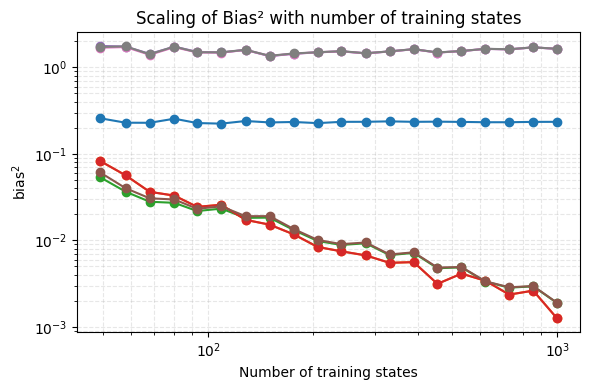

In [ ]:
def _():
    dim = 2
    n_outcomes = 20
    train_stat = 10
    n_realizations = 100  # number of independent runs per shot count
    # training_states_all = [qutip.rand_ket(dim) for _ in range(10**4)]
    test_state = qutip.rand_ket(dim)
    povm = random_rank1_povm(dim, n_outcomes)
    target_obs = qutip.sigmax()
    vO = QuantumState(target_obs).vectorise()
    Mmu = np.array([QuantumState(mu).vectorise() for mu in povm]).T
    data = []
    n_states_list = logspace(50, 10**3, num=20).astype(int)
    for n_states in tqdm(n_states_list, desc="Training with different number of states"):
        # empirical bias^2 over multiple realizations
        for realization in tqdm(range(n_realizations), desc=f"Training with {n_states} states", leave=False):
            training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
            # true_P = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
            qelm_inf = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state],
                                                                target_observables=[target_obs], povm=povm, statistics=np.inf)
            true_w = qelm_inf.w.flatten()
            true_P = qelm_inf.train.frequencies
            true_test_P = qelm_inf.test.frequencies
            Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
            vsigma = QuantumState(test_state).vectorise()
            # dirty_P = measure_povm(states=training_states, povm=povm, statistics=train_stat, return_frequencies=True)
            qelm_fin = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state], sampling_method='poisson',
                                                                target_observables=[target_obs], povm=povm, statistics=(train_stat, np.inf))
            dirty_w = qelm_fin.w.flatten()
            dirty_P = qelm_fin.train.frequencies
            Pinv = np.linalg.pinv(true_P)
            # extract and process the X matrix
            X = (dirty_P - true_P) * np.sqrt(train_stat)
            # project onto support and image of the true P
            pi_supp = Pinv @ true_P
            pi_im = true_P @ Pinv
            X11 = pi_im @ X @ pi_supp
            X12 = pi_im @ X @ (np.eye(true_P.shape[1]) - pi_supp)
            X21 = (np.eye(len(true_P)) - pi_im) @ X @ pi_supp
            X22 = (np.eye(len(true_P)) - pi_im) @ X @ (np.eye(true_P.shape[1]) - pi_supp)
            scX_2 = X12 @ np.linalg.pinv(X22) @ X21
            scX = X11 - scX_2 # Schur complement
            Pi2 = np.eye(X22.shape[1]) - np.linalg.pinv(X22) @ X22
            Y = np.eye(X21.shape[1]) + X21.T @ np.linalg.pinv(X22 @ X22.T) @ X21
            Mmuinv = np.linalg.pinv(Mmu)
            Mrhoinv = np.linalg.pinv(Mrho)
            # compute exact bias^2 (for this training realization)
            bias2_real = ((dirty_w - true_w) @ true_test_P) ** 2
            # compute bias^2 from the expansion formula
            bias2_leading_core_1 = vO.T @ Mmuinv.T @ scX @ Mrhoinv @ vsigma
            bias2_leading_1 = bias2_leading_core_1 ** 2 / train_stat
            bias2_leading_1_onlyX11 = (vO.T @ Mmuinv.T @ X11 @ Mrhoinv @ vsigma) ** 2 / train_stat

            bias2_leading_core_2 = scX @ Pinv @ scX - X12 @ Pi2 @ X12.T @ Pinv.T @ Y
            bias2_leading_core_2 = vO.T @ Mmuinv.T @ bias2_leading_core_2 @ Mrhoinv @ vsigma
            bias2_leading_2 = - 2 * bias2_leading_core_1 * bias2_leading_core_2 / train_stat**(3/2)
            bias2_leading_2 =+ bias2_leading_1

            bias2_leading_3 = bias2_leading_core_2 ** 2 / (train_stat ** 2)
            bias2_leading_3 += bias2_leading_1

            bias2_leading_3_onlyX11 = (vO.T @ Mmuinv.T @ (X11 @ Pinv @ X11) @ Mrhoinv @ vsigma) ** 2 / (train_stat ** 2)
            bias2_leading_3_onlyX11 += bias2_leading_1_onlyX11

            bias2_leading_3_onlyX11withPi = (vO.T @ Mmuinv.T @ (X11 @ Pinv @ X11 - X12 @ Pi2 @ X12.T @ Pinv.T @ Y) @ Mrhoinv @ vsigma) ** 2 / (train_stat ** 2)
            bias2_leading_3_onlyX11withPi += bias2_leading_1_onlyX11

            bias2_leading_3_true = (vO.T @ Mmuinv.T @ (X12 @ Pi2 @ X12.T @ Pinv.T @ Y) @ Mrhoinv @ vsigma) ** 2 / (train_stat ** 2)

            data.append({
                'n_states': n_states,
                'realization': realization,
                'bias2_real': bias2_real,
                'bias2_leading_1': bias2_leading_1,
                'bias2_leading_1_onlyX11': bias2_leading_1_onlyX11,
                'bias2_leading_2': bias2_leading_2,
                'bias2_leading_3': bias2_leading_3,
                'bias2_leading_3_onlyX11': bias2_leading_3_onlyX11,
                'bias2_leading_3_onlyX11withPi': bias2_leading_3_onlyX11withPi,
                'bias2_leading_3_true': bias2_leading_3_true
            })

    df = pd.DataFrame(data)
    summary = df.groupby('n_states').agg(
        bias2_real_mean = ('bias2_real', 'mean'),
        bias2_lead1_mean = ('bias2_leading_1', 'mean'),
        bias2_lead1_onlyX11_mean = ('bias2_leading_1_onlyX11', 'mean'),
        bias2_lead2_mean = ('bias2_leading_2', 'mean'),
        bias2_lead3_mean = ('bias2_leading_3', 'mean'),
        bias2_lead3_onlyX11_mean = ('bias2_leading_3_onlyX11', 'mean'),
        bias2_lead3_onlyX11withPi_mean = ('bias2_leading_3_onlyX11withPi', 'mean'),
        bias2_lead3_true_mean = ('bias2_leading_3_true', 'mean')
    ).reset_index()

    # Plot with error bars
    plt.figure(figsize=(6,4))
    plt.plot(summary['n_states'], summary['bias2_real_mean'], marker='o', label=r'Actual $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead1_mean'], marker='o', label=r'Leading order 1st term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead1_onlyX11_mean'], marker='o', label=r'Leading order 1st term only $X_{11}$ $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead2_mean'], marker='o', label=r'Leading order 2nd term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_mean'], marker='o', label=r'Leading order 3rd term $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_onlyX11_mean'], marker='o', label=r'Leading order 3rd term only $X_{11}$ $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_onlyX11withPi_mean'], marker='o', label=r'Leading order 3rd term only $X_{11}$ with $\Pi$ $\mathrm{bias}^2$')
    plt.plot(summary['n_states'], summary['bias2_lead3_true_mean'], marker='o', label=r'Leading order 3rd term true $\mathrm{bias}^2$')
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Number of training states'); plt.ylabel(r'$\mathrm{bias}^2$')
    plt.title('Scaling of Bias² with number of training states')
    plt.grid(True, which='both', ls='--', alpha=0.3)
    # plt.legend();
    plt.tight_layout(); plt.show()
_()


Train statistics: 100%|██████████| 20/20 [08:18<00:00, 24.94s/it] 


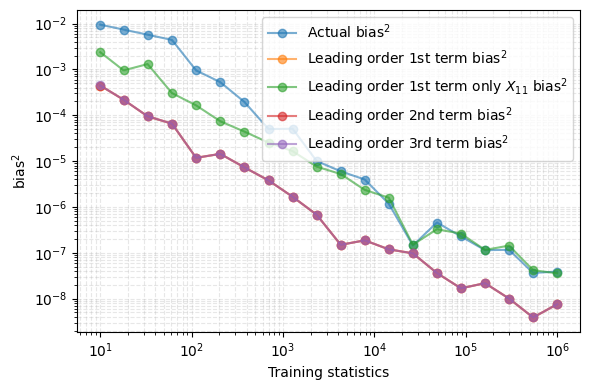

In [ ]:
def _():
    dim = 2
    n_outcomes = 10
    n_realizations = 10  # number of independent runs per shot count
    # Prepare states, POVM, and tomography ingredients
    training_states = [qutip.rand_ket(dim) for _ in range(10**3)]
    test_state = qutip.rand_ket(dim)
    # povm = sic_povm()
    povm = random_rank1_povm(dim, n_outcomes)
    target_obs = qutip.sigmax()
    vO = QuantumState(target_obs).vectorise()
    vsigma = QuantumState(test_state).vectorise()
    # vectorized representation of the POVM (each column an effect)
    Mmu = np.array([QuantumState(mu).vectorise() for mu in povm]).T
    Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
    Mmuinv = np.linalg.pinv(Mmu)
    Mrhoinv = np.linalg.pinv(Mrho)
    qelm_inf = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state],
                                                            target_observables=[target_obs], povm=povm, statistics=np.inf)
    true_w = qelm_inf.w.flatten()
    true_P = qelm_inf.train.frequencies
    Pinv = np.linalg.pinv(true_P)
    true_test_P = qelm_inf.test.frequencies
    # print('vO shape', vO.shape)
    # print('Mmu shape', Mmu.shape)
    # print('Mrho shape', Mrho.shape)
    # print('Pinv shape', Pinv.shape)
    # print('true_P shape', true_P.shape)
    # print('Mrhoinv shape', Mrhoinv.shape)
    # print('vsigma shape', vsigma.shape)
    data = []
    train_stats_list = logspace(10, 10**6, num=20).astype(int)
    for train_stat in tqdm(train_stats_list, desc="Train statistics"):
        # empirical bias^2 over multiple realizations
        for realization in tqdm(range(n_realizations), desc=f"Testing realizations", leave=False):
            qelm_fin = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state],
                                                                target_observables=[target_obs], povm=povm, statistics=(train_stat, np.inf))
            dirty_w = qelm_fin.w.flatten()
            dirty_P = qelm_fin.train.frequencies
            # extract and process the X matrix
            X = (dirty_P - true_P) * np.sqrt(train_stat)
            # project onto support and image of the true P
            pi_supp = Pinv @ true_P
            pi_im = true_P @ Pinv
            X11 = pi_im @ X @ pi_supp
            X12 = pi_im @ X @ (np.eye(true_P.shape[1]) - pi_supp)
            X21 = (np.eye(true_P.shape[0]) - pi_im) @ X @ pi_supp
            X22 = (np.eye(true_P.shape[0]) - pi_im) @ X @ (np.eye(true_P.shape[1]) - pi_supp)
            scX_2 = X12 @ np.linalg.pinv(X22) @ X21
            scX = X11 - scX_2 # Schur complement
            # print('scX shape', scX.shape)
            Pi2 = np.eye(X22.shape[1]) - np.linalg.pinv(X22) @ X22
            Y = np.eye(X21.shape[1]) + X21.T @ np.linalg.pinv(X22 @ X22.T) @ X21
            # compute exact bias^2 (for this training realization)
            bias2_real = ((dirty_w - true_w) @ true_test_P) ** 2
            # compute bias^2 from the expansion formula
            bias2_leading_core_1 = vO.T @ Mmuinv.T @ scX @ Mrhoinv @ vsigma
            bias2_leading_1 = bias2_leading_core_1 ** 2 / train_stat
            bias2_leading_1_onlyX11 = (vO.T @ Mmuinv.T @ X11 @ Mrhoinv @ vsigma) ** 2 / train_stat

            # bias2_leading_1 = (vO.T @ np.linalg.pinv(Mmu).T @ X11 @ np.linalg.pinv(Mrho) @ vsigma) ** 2 / train_stat
            # bias2_leading_2 = (vO.T @ np.linalg.pinv(Mmu).T @ scX_2 @ np.linalg.pinv(Mrho) @ vsigma) ** 2 / train_stat
            # bias2_leading_1_vals.append(bias2_leading_1)
            # bias2_leading_2_vals.append(bias2_leading_2)
            
            bias2_leading_2 = scX @ Pinv @ scX - X12 @ Pi2 @ X12.T @ Pinv.T @ Y
            bias2_leading_core_2 = vO.T @ Mmuinv.T @ bias2_leading_2 @ Mrhoinv @ vsigma
            bias2_leading_2 = - 2 * bias2_leading_core_1 * bias2_leading_core_2 / train_stat**(3/2)
            bias2_leading_2 =+ bias2_leading_1

            bias2_leading_3 = bias2_leading_core_2 ** 2 / (train_stat ** 2)
            bias2_leading_3 += bias2_leading_1

            data.append({
                'train_stat': train_stat,
                'realization': realization,
                'bias2_real': bias2_real,
                'bias2_leading_1': bias2_leading_1,
                'bias2_leading_1_onlyX11': bias2_leading_1_onlyX11,
                'bias2_leading_2': bias2_leading_2,
                'bias2_leading_3': bias2_leading_3
            })

    df = pd.DataFrame(data)
    summary = df.groupby('train_stat').agg(
        bias2_real_mean = ('bias2_real', 'mean'),
        bias2_lead1_mean = ('bias2_leading_1', 'mean'),
        bias2_lead1_onlyX11_mean = ('bias2_leading_1_onlyX11', 'mean'),
        bias2_lead2_mean = ('bias2_leading_2', 'mean'),
        bias2_lead3_mean = ('bias2_leading_3', 'mean')
    ).reset_index()

    # Plot with error bars
    plt.figure(figsize=(6,4))
    plt.plot(summary['train_stat'], summary['bias2_real_mean'], marker='o', alpha=0.6, label=r'Actual $\mathrm{bias}^2$')
    plt.plot(summary['train_stat'], summary['bias2_lead1_mean'], marker='o', alpha=0.6, label=r'Leading order 1st term $\mathrm{bias}^2$')
    plt.plot(summary['train_stat'], summary['bias2_lead1_onlyX11_mean'], marker='o', alpha=0.6, label=r'Leading order 1st term only $X_{11}$ $\mathrm{bias}^2$')
    plt.plot(summary['train_stat'], summary['bias2_lead2_mean'], marker='o', alpha=0.6, label=r'Leading order 2nd term $\mathrm{bias}^2$')
    plt.plot(summary['train_stat'], summary['bias2_lead3_mean'], marker='o', alpha=0.6, label=r'Leading order 3rd term $\mathrm{bias}^2$')
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Training statistics'); plt.ylabel(r'$\mathrm{bias}^2$')
    # plt.title('Scaling of Bias² with number of training states')
    plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.legend(); plt.tight_layout(); plt.show()
_()

Training with different number of states: 100%|██████████| 20/20 [06:39<00:00, 19.96s/it]


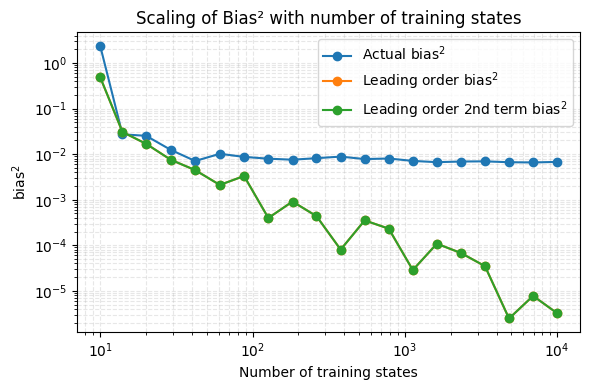

In [ ]:
dim = 2
# n_states = 50
n_outcomes = 10
train_stat = 10**2
n_realizations = 60  # number of independent runs per shot count
# Prepare states, POVM, and tomography ingredients
training_states_all = [qutip.rand_ket(dim) for _ in range(n_states)]
test_state = qutip.rand_ket(dim)
# povm = sic_povm()
povm = random_rank1_povm(dim, n_outcomes)
target_obs = qutip.sigmax()
vO = QuantumState(target_obs).vectorise()
# vectorized representation of the POVM (each column an effect)
Mmu = np.array([QuantumState(mu).vectorise() for mu in povm]).T

# Containers for results
# bias2_th = []
bias2_real_mean_list = []
bias2_real_err_low = []
bias2_real_err_high = []

bias2_real_mean_list_2 = []  # same but computed without passing through the W
bias2_real_err_low_2 = []
bias2_real_err_high_2 = []

bias2_leading_means = []
bias2_leading_1_means = []
bias2_leading_2_means = []

n_states_list = logspace(10, 10**4, num=20).astype(int)
for n_states in tqdm(n_states_list, desc="Training with different number of states"):
    training_states = training_states_all[:n_states]
    # true_P = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
    qelm_inf = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state],
                                                           target_observables=[target_obs], povm=povm, statistics=np.inf)
    true_w = qelm_inf.w.flatten()
    true_P = qelm_inf.train.frequencies
    true_test_P = qelm_inf.test.frequencies
    Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
    vsigma = QuantumState(test_state).vectorise()
    # label_inf = qelm_inf.test.labels.flatten()
    # bias2_theory = theoretical_bias2(training_states, test_state, povm, w_true, statistics=train_stat)
    # check that true_P is the same as freq_inf
    # empirical bias^2 over multiple realizations
    bias2_real_vals = []
    bias2_real_vals_2 = [] # same but computed without passing through the W
    bias2_leading_vals = []
    bias2_leading_1_vals = []
    bias2_leading_2_vals = []
    for _ in tqdm(range(n_realizations), desc=f"Training with {n_states} states", leave=False):
        # dirty_P = measure_povm(states=training_states, povm=povm, statistics=train_stat, return_frequencies=True)
        qelm_fin = QELM.QELM.train_from_observables_and_states(training_states=training_states, test_states=[test_state],
                                                               target_observables=[target_obs], povm=povm, statistics=(train_stat, np.inf))
        dirty_w = qelm_fin.w.flatten()
        dirty_P = qelm_fin.train.frequencies
        Pinv = np.linalg.pinv(true_P)
        # extract and process the X matrix
        X = (dirty_P - true_P) * np.sqrt(train_stat)
        # project onto support and image of the true P
        pi_supp = Pinv @ true_P
        pi_im = true_P @ Pinv
        # print(true_P.shape, dirty_P.shape, pi_supp.shape, pi_im.shape)
        X11 = pi_im @ X @ pi_supp
        X12 = pi_im @ X @ (np.eye(true_P.shape[1]) - pi_supp)
        X21 = (np.eye(len(true_P)) - pi_im) @ X @ pi_supp
        X22 = (np.eye(len(true_P)) - pi_im) @ X @ (np.eye(true_P.shape[1]) - pi_supp)
        # compute the Schur complement
        scX_2 = X12 @ np.linalg.pinv(X22) @ X21
        scX = X11 - scX_2
        # compute exact bias^2 (for this training realization)
        bias2_real = ((dirty_w - true_w) @ true_test_P) ** 2
        bias2_real_vals.append(bias2_real)
        # compute bias^2 from the expansion formula
        bias2_leading_core_1 = vO.T @ np.linalg.pinv(Mmu).T @ scX @ np.linalg.pinv(Mrho) @ vsigma
        bias2_leading = bias2_leading_core_1 ** 2 / train_stat
        bias2_leading_vals.append(bias2_leading)

        # bias2_leading_1 = (vO.T @ np.linalg.pinv(Mmu).T @ X11 @ np.linalg.pinv(Mrho) @ vsigma) ** 2 / train_stat
        # bias2_leading_2 = (vO.T @ np.linalg.pinv(Mmu).T @ scX_2 @ np.linalg.pinv(Mrho) @ vsigma) ** 2 / train_stat
        # bias2_leading_1_vals.append(bias2_leading_1)
        # bias2_leading_2_vals.append(bias2_leading_2)
        Pi2 = np.eye(X22.shape[1]) - np.linalg.pinv(X22) @ X22
        Y = X21.T @ np.linalg.pinv(X22 @ X22.T) @ X21
        bias2_leading_2 = scX @ Pinv @ scX - X12 @ Pi2 @ X12.T @ Pinv.T @ Y
        bias2_leading_2 = vO.T @ np.linalg.pinv(Mmu).T @ bias2_leading_2 @ np.linalg.pinv(Mrho) @ vsigma
        bias2_leading_2 = - 2 * bias2_leading_core_1 * bias2_leading_2 / train_stat**(3/2)
        bias2_leading_2 =+ bias2_leading

        bias2_leading_2_vals.append(bias2_leading_2)




    bias2_real_vals = np.array(bias2_real_vals)
    bias2_real_mean = bias2_real_vals.mean()
    bias2_real_mean_list.append(bias2_real_mean)
    bias2_real_err_high.append(bias2_real_vals.max() - bias2_real_mean)
    bias2_real_err_low.append(bias2_real_mean - bias2_real_vals.min())

    bias2_leading_means.append(np.array(bias2_leading_vals).mean())
    # bias2_leading_1_means.append(np.array(bias2_leading_1_vals).mean())
    bias2_leading_2_means.append(np.array(bias2_leading_2_vals).mean())

# Assemble DataFrame
df = pd.DataFrame({
    'n_states_list': n_states_list,
    'bias2_real': bias2_real_mean_list,
    'bias2_leading': bias2_leading_means,
    # 'bias2_leading_1': bias2_leading_1_means,
    'bias2_leading_2': bias2_leading_2_means
})

# Plot with error bars
plt.figure(figsize=(6,4))
# theoretical curve
plt.plot(df['n_states_list'], df['bias2_real'], marker='o', label=r'Actual $\mathrm{bias}^2$')
plt.plot(df['n_states_list'], df['bias2_leading'], marker='o', label=r'Leading order $\mathrm{bias}^2$')
# plt.plot(df['n_states_list'], df['bias2_leading_1'], marker='o', label=r'Leading order 1st term $\mathrm{bias}^2$')
plt.plot(df['n_states_list'], df['bias2_leading_2'], marker='o', label=r'Leading order 2nd term $\mathrm{bias}^2$')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Number of training states'); plt.ylabel(r'$\mathrm{bias}^2$')
plt.title('Scaling of Bias² with number of training states')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend(); plt.tight_layout(); plt.show()


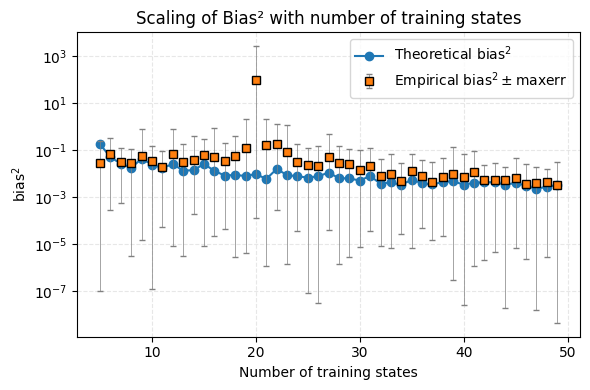

In [ ]:
def theoretical_bias2(training_states, test_state, povm, w_true, statistics=1):
    # True outcome probabilities at infinite stats
    P = measure_povm(training_states, povm, statistics=np.inf, return_frequencies=True)
    # Vectorised test state mapping
    Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
    vrho = np.linalg.pinv(Mrho) @ QuantumState(test_state).vectorise()

    term1 = np.dot(w_true**2, P).dot(vrho**2)
    term2 = (np.dot(w_true, P)**2).dot(vrho**2)
    return (term1 - term2) / statistics

dim = 2
n_states = 50
n_outcomes = 20
train_stat = 10**2
n_realizations = 40  # number of independent runs per shot count
# Prepare states, POVM, and tomography ingredients
test_state = qutip.rand_ket(dim)
povm = random_rank1_povm(dim, n_outcomes)

# Containers for results
bias2_th = []
bias2_emp = []
bias2_emp_err_low = []
bias2_emp_err_high = []

n_states_list = range(5, 50)
for n_states in n_states_list:
    training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
    true_P = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
    qelm_inf = QELM.QELM.train_from_observables_and_states(
        training_states=training_states,
        test_states=[test_state],
        target_observables=[qutip.sigmax()],
        povm=povm,
        statistics=np.inf
    )
    w_true    = qelm_inf.w.flatten()
    freq_inf  = qelm_inf.test.frequencies.flatten()
    label_inf = qelm_inf.test.labels.flatten()
    bias2_theory = theoretical_bias2(training_states, test_state, povm, w_true, statistics=train_stat)

    # empirical bias^2 over multiple realizations
    emp_vals = []
    for _ in range(n_realizations):
        qelm_fin = QELM.QELM.train_from_observables_and_states(
            training_states=training_states,
            test_states=[test_state],
            target_observables=[qutip.sigmax()],
            povm=povm,
            statistics=(train_stat, np.inf)
        )
        emp_vals.append(qelm_fin.bias2()[0])

    emp_vals = np.array(emp_vals)
    mean_emp = emp_vals.mean()
    # se_emp   = emp_vals.std(ddof=1) / np.sqrt(n_realizations)

    # store
    bias2_th.append(bias2_theory)
    bias2_emp.append(mean_emp)
    bias2_emp_err_high.append(emp_vals.max() - mean_emp)
    bias2_emp_err_low.append(mean_emp - emp_vals.min())

# Assemble DataFrame
df = pd.DataFrame({
    'n_states_list': n_states_list,
    'bias2_theory': bias2_th,
    'bias2_empirical': bias2_emp,
    'bias2_emp_err_high': bias2_emp_err_high,
    'bias2_emp_err_low': bias2_emp_err_low
})

# Plot with error bars
plt.figure(figsize=(6,4))
# theoretical curve
plt.plot(df['n_states_list'], df['bias2_theory'],
         marker='o', label=r'Theoretical $\mathrm{bias}^2$')
# empirical mean ± standard error
plt.errorbar(
    df['n_states_list'], df['bias2_empirical'],
    yerr=[df['bias2_emp_err_low'], df['bias2_emp_err_high']],
    marker='s', ls='none',
    markersize=6,           # larger markers
    markeredgewidth=1,
    markeredgecolor='black',
    markerfacecolor='C1',
    alpha=1.0,              # fully opaque points
    ecolor='gray',          # error bars in gray
    elinewidth=0.5,         # thinner error bars
    capsize=2,              # small caps
    capthick=0.5,
    label=r'Empirical $\mathrm{bias}^2 \pm{\rm maxerr}$'
)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of training states')
plt.ylabel(r'$\mathrm{bias}^2$')
plt.title('Scaling of Bias² with number of training states')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [264]:
def theoretical_bias2(training_states, test_state, povm, w_true, statistics=1):
    # True outcome probabilities at infinite stats
    P = measure_povm(training_states, povm, statistics=np.inf, return_frequencies=True)
    # Vectorised test state mapping
    Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
    vrho = np.linalg.pinv(Mrho) @ QuantumState(test_state).vectorise()

    term1 = np.dot(w_true**2, P).dot(vrho**2)
    term2 = (np.dot(w_true, P)**2).dot(vrho**2)
    return (term1 - term2) / statistics

dim = 2
n_states = 50
n_outcomes = 10
train_stat = 10**3
n_realizations = 40  # number of independent runs per shot count
# Prepare states, POVM, and tomography ingredients
test_state = qutip.rand_ket(dim)
povm = random_rank1_povm(dim, n_outcomes)

# Containers for results
bias2_th = []
bias2_emp = []
bias2_emp_err_low = []
bias2_emp_err_high = []

n_states_list = range(5, 50)
for n_states in n_states_list:
    training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
    true_P = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
    qelm_inf = QELM.QELM.train_from_observables_and_states(
        training_states=training_states,
        test_states=[test_state],
        target_observables=[qutip.sigmax()],
        povm=povm,
        statistics=np.inf
    )
    w_true    = qelm_inf.w.flatten()
    freq_inf  = qelm_inf.test.frequencies.flatten()
    label_inf = qelm_inf.test.labels.flatten()
    bias2_theory = theoretical_bias2(training_states, test_state, povm, w_true, statistics=train_stat)

    # empirical bias^2 over multiple realizations
    emp_vals = []
    for _ in range(n_realizations):
        qelm_fin = QELM.QELM.train_from_observables_and_states(
            training_states=training_states,
            test_states=[test_state],
            target_observables=[qutip.sigmax()],
            povm=povm,
            statistics=(train_stat, np.inf)
        )
        emp_vals.append(qelm_fin.bias2()[0])

    emp_vals = np.array(emp_vals)
    mean_emp = emp_vals.mean()
    # se_emp   = emp_vals.std(ddof=1) / np.sqrt(n_realizations)

    # store
    bias2_th.append(bias2_theory)
    bias2_emp.append(mean_emp)
    bias2_emp_err_high.append(emp_vals.max() - mean_emp)
    bias2_emp_err_low.append(mean_emp - emp_vals.min())

# Assemble DataFrame
df = pd.DataFrame({
    'n_states_list': n_states_list,
    'bias2_theory': bias2_th,
    'bias2_empirical': bias2_emp,
    'bias2_emp_err_high': bias2_emp_err_high,
    'bias2_emp_err_low': bias2_emp_err_low
})

# Plot with error bars
plt.figure(figsize=(6,4))
# theoretical curve
plt.plot(df['n_states_list'], df['bias2_theory'],
         marker='o', label=r'Theoretical $\mathrm{bias}^2$')
# empirical mean ± standard error
plt.errorbar(
    df['n_states_list'], df['bias2_empirical'],
    yerr=[df['bias2_emp_err_low'], df['bias2_emp_err_high']],
    marker='s', ls='none',
    markersize=6,           # larger markers
    markeredgewidth=1,
    markeredgecolor='black',
    markerfacecolor='C1',
    alpha=1.0,              # fully opaque points
    ecolor='gray',          # error bars in gray
    elinewidth=0.5,         # thinner error bars
    capsize=2,              # small caps
    capthick=0.5,
    label=r'Empirical $\mathrm{bias}^2 \pm{\rm maxerr}$'
)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of training states')
plt.ylabel(r'$\mathrm{bias}^2$')
plt.title('Scaling of Bias² with number of training states')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


TypeError: must be real number, not Qobj

# Tests

## $\mathbb E[\Pi_{\rm im}\hat{\bf X}\hat{\bf X}^T]$

Double check that $\mathbb E[\Pi_{\rm im}\hat{\bf X}\hat{\bf X}^T] = n_{\rm tr} {\bf PP}^+ \operatorname{diag}(\operatorname{Tr}(\boldsymbol\mu\bar\rho)) - {\bf PP}^T$ holds.

For the MUB: It oscillates around 0 with increasingly large variations (ie variance $n$).
For random rank-1 POVMs, it scales as $O(n_{\rm tr})$

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

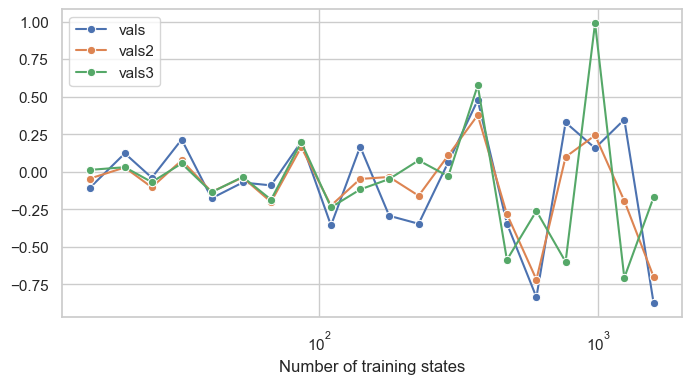

In [21]:
d = 2
# povm = random_rank1_povm(dim=2, num_outcomes=50)
povm = mub_povm()
def quantifier(matrix): return matrix[0, 4]
vals = []; vals2 = []; vals3 = []
n_states_list = np.logspace(1.2, 3.2, num=20, dtype=int)
for n_states in tqdm(n_states_list, leave=False):
    states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
    train_stat = 100
    true_P = states.measure_povm(povm=povm, statistics=np.inf)
    realizations = []; realizations2 = []; realizations3 = []
    for _ in tqdm(range(80), leave=False):
        dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
        mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
        realizations.append(quantifier(mb.pi_im @ mb.X @ mb.X.T))
        rhobar = states.todm().data.sum(axis=0) / len(states)
        diagmuterm = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), rhobar).real)
        diagmuterm2 = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), np.eye(2) / 2).real)
        realizations2.append(quantifier(mb.pi_im @ diagmuterm - true_P @ true_P.T))
        realizations3.append(quantifier(mb.pi_im @ diagmuterm2 - true_P @ true_P.T))
    vals.append(np.mean(realizations)); vals2.append(np.mean(realizations2)); vals3.append(np.mean(realizations3))
vals = np.array(vals); vals2 = np.array(vals2); vals3 = np.array(vals3)
plt.figure(figsize=(8, 4))
sns.lineplot(x=n_states_list, y=vals, marker="o", label="vals")
sns.lineplot(x=n_states_list, y=vals2, marker="o", label="vals2")
sns.lineplot(x=n_states_list, y=vals3, marker="o", label="vals3")
plt.xscale("log");
# plt.yscale("log");
plt.legend(); plt.xlabel("Number of training states");

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

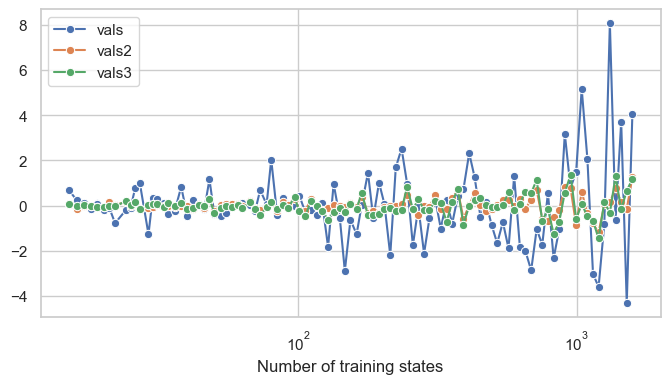

In [65]:
d = 2
# povm = random_rank1_povm(dim=2, num_outcomes=50)
povm = mub_povm()
def quantifier(matrix): return matrix[0, 4]
vals = []; vals2 = []; vals3 = []
n_states_list = np.logspace(1.2, 3.2, num=100, dtype=int)
for n_states in tqdm(n_states_list, leave=False):
    states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
    train_stat = 100
    true_P = states.measure_povm(povm=povm, statistics=np.inf)
    realizations = []; realizations2 = []; realizations3 = []
    for _ in tqdm(range(1), leave=False):
        dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
        mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
        realizations.append(quantifier(mb.pi_im @ mb.X @ mb.X.T))
        rhobar = states.todm().data.sum(axis=0) / len(states)
        diagmuterm = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), rhobar).real)
        diagmuterm2 = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), np.eye(2) / 2).real)
        realizations2.append(quantifier(mb.pi_im @ diagmuterm - true_P @ true_P.T))
        realizations3.append(quantifier(mb.pi_im @ diagmuterm2 - true_P @ true_P.T))
    vals.append(np.mean(realizations)); vals2.append(np.mean(realizations2)); vals3.append(np.mean(realizations3))
vals = np.array(vals); vals2 = np.array(vals2); vals3 = np.array(vals3)
plt.figure(figsize=(8, 4))
sns.lineplot(x=n_states_list, y=vals, marker="o", label="vals")
sns.lineplot(x=n_states_list, y=vals2, marker="o", label="vals2")
sns.lineplot(x=n_states_list, y=vals3, marker="o", label="vals3")
plt.xscale("log");
# plt.yscale("log");
plt.legend(); plt.xlabel("Number of training states");

Same as above but random rank-1 POVM. In this case sometimes we see a scaling with $n_{\rm tr}$ and sometimes one with $-n_{\rm tr}$. Porbably depending on the random choice of POVM

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

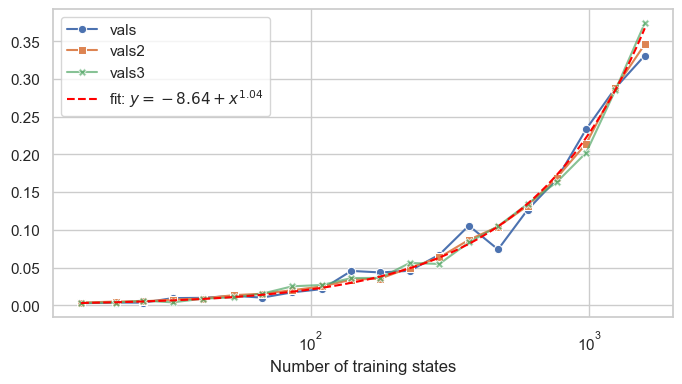

In [35]:
d = 2
povm = random_rank1_povm(dim=2, num_outcomes=50)
# povm = mub_povm()
def quantifier(matrix): return matrix[0, 4]
vals = []; vals2 = []; vals3 = []
n_states_list = np.logspace(1.2, 3.2, num=20, dtype=int)
for n_states in tqdm(n_states_list, leave=False):
    states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
    train_stat = 100
    true_P = states.measure_povm(povm=povm, statistics=np.inf)
    realizations = []; realizations2 = []; realizations3 = []
    for _ in tqdm(range(90), leave=False):
        dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
        mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
        realizations.append(quantifier(mb.pi_im @ mb.X @ mb.X.T))
        rhobar = states.todm().data.sum(axis=0) / len(states)
        diagmuterm = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), rhobar).real)
        diagmuterm2 = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), np.eye(2) / 2).real)
        realizations2.append(quantifier(mb.pi_im @ diagmuterm - true_P @ true_P.T))
        realizations3.append(quantifier(mb.pi_im @ diagmuterm2 - true_P @ true_P.T))
    vals.append(np.mean(realizations)); vals2.append(np.mean(realizations2)); vals3.append(np.mean(realizations3))
vals = np.array(vals); vals2 = np.array(vals2); vals3 = np.array(vals3)
plt.figure(figsize=(8, 4))
sns.lineplot(x=n_states_list, y=vals, marker="o", label="vals")
sns.lineplot(x=n_states_list, y=vals2, marker="s", label="vals2")
sns.lineplot(x=n_states_list, y=vals3, marker="X", label="vals3", alpha=0.7)
logfit_and_plot(n_states_list, vals)
plt.xscale("log");
# plt.yscale("log");
plt.legend(); plt.xlabel("Number of training states");

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Error fitting: SVD did not converge in Linear Least Squares


C:\Users\lukei\AppData\Local\Temp\ipykernel_30280\3071932364.py:70: RuntimeWarning: invalid value encountered in log
  a, b = np.polyfit(np.log(x), np.log(y), deg=1)


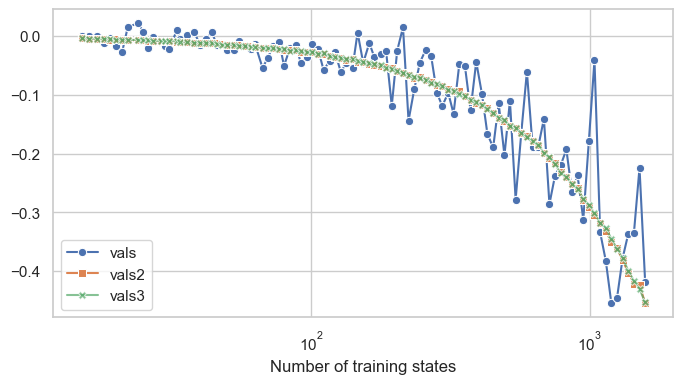

In [66]:
d = 2
povm = random_rank1_povm(dim=2, num_outcomes=50)
# povm = mub_povm()
def quantifier(matrix): return matrix[0, 4]
vals = []; vals2 = []; vals3 = []
n_states_list = np.logspace(1.2, 3.2, num=100, dtype=int)
for n_states in tqdm(n_states_list, leave=False):
    states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
    train_stat = 100
    true_P = states.measure_povm(povm=povm, statistics=np.inf)
    realizations = []; realizations2 = []; realizations3 = []
    for _ in tqdm(range(1), leave=False):
        dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
        mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
        realizations.append(quantifier(mb.pi_im @ mb.X @ mb.X.T))
        rhobar = states.todm().data.sum(axis=0) / len(states)
        diagmuterm = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), rhobar).real)
        diagmuterm2 = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), np.eye(2) / 2).real)
        realizations2.append(quantifier(mb.pi_im @ diagmuterm - true_P @ true_P.T))
        realizations3.append(quantifier(mb.pi_im @ diagmuterm2 - true_P @ true_P.T))
    vals.append(np.mean(realizations)); vals2.append(np.mean(realizations2)); vals3.append(np.mean(realizations3))
vals = np.array(vals); vals2 = np.array(vals2); vals3 = np.array(vals3)
plt.figure(figsize=(8, 4))
sns.lineplot(x=n_states_list, y=vals, marker="o", label="vals")
sns.lineplot(x=n_states_list, y=vals2, marker="s", label="vals2")
sns.lineplot(x=n_states_list, y=vals3, marker="X", label="vals3", alpha=0.7)
logfit_and_plot(n_states_list, vals)
plt.xscale("log");
# plt.yscale("log");
plt.legend(); plt.xlabel("Number of training states");

## $\mathbb E[\Pi_{\rm im}\hat{\bf X}\hat{\bf X}^T(I - \Pi_{\rm im})]$

Let's now try to investigate $\mathbb E[\Pi_{\rm im}\hat{\bf X}\hat{\bf X}^T(I-\Pi_{\rm im})]$ instead

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

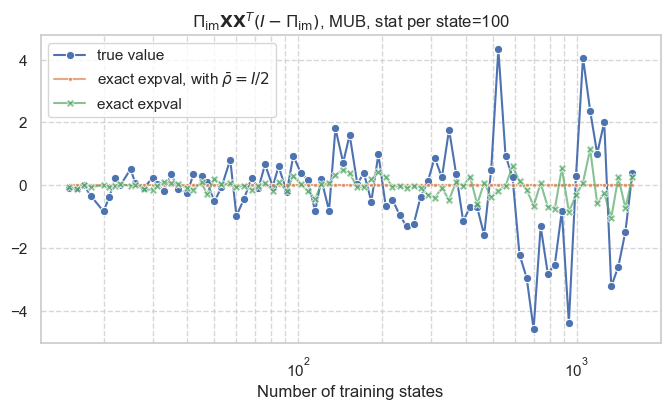

In [ ]:
d = 2
# povm = random_rank1_povm(dim=2, num_outcomes=50)
povm = mub_povm()
def quantifier(matrix): return matrix[0, 4]
vals = []; vals2 = []; vals3 = []
n_states_list = np.logspace(1.2, 3.2, num=80, dtype=int)
for n_states in tqdm(n_states_list, leave=False):
    states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
    train_stat = 100
    true_P = states.measure_povm(povm=povm, statistics=np.inf)
    realizations = []; realizations2 = []; realizations3 = []
    for _ in tqdm(range(1), leave=False):
        dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
        mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
        realizations.append(quantifier(mb.pi_im @ mb.X @ mb.X.T @ (mb.I_im - mb.pi_im)))
        rhobar = states.todm().data.sum(axis=0) / len(states)
        diagmuterm = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), rhobar).real)
        diagmuterm2 = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), np.eye(2) / 2).real)
        realizations2.append(quantifier(mb.pi_im @ diagmuterm2 @ (mb.I_im - mb.pi_im)))
        realizations3.append(quantifier(mb.pi_im @ diagmuterm @ (mb.I_im - mb.pi_im)))
        # realizations3.append(quantifier(mb.pi_im @ diagmuterm2 - true_P @ true_P.T))
    vals.append(np.mean(realizations)); vals2.append(np.mean(realizations2)); vals3.append(np.mean(realizations3))
vals = np.array(vals); vals2 = np.array(vals2); vals3 = np.array(vals3)
plt.figure(figsize=(8, 4));
plt.title(fr'$\Pi_{{\rm im}}{{\bf XX}}^T(I-\Pi_{{\rm im}})$, MUB, stat per state={train_stat}')
sns.lineplot(x=n_states_list, y=vals, marker="o", label="true value")
sns.lineplot(x=n_states_list, y=vals2, marker=".", label=r"exact expval, with $\bar\rho=I/2$", alpha=0.7)
sns.lineplot(x=n_states_list, y=vals3, marker="X", label="exact expval", alpha=0.7)
plt.xscale("log");
# plt.yscale("log");
plt.grid(True, which='both', ls='--', alpha=0.8)
plt.legend(); plt.xlabel("Number of training states");

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

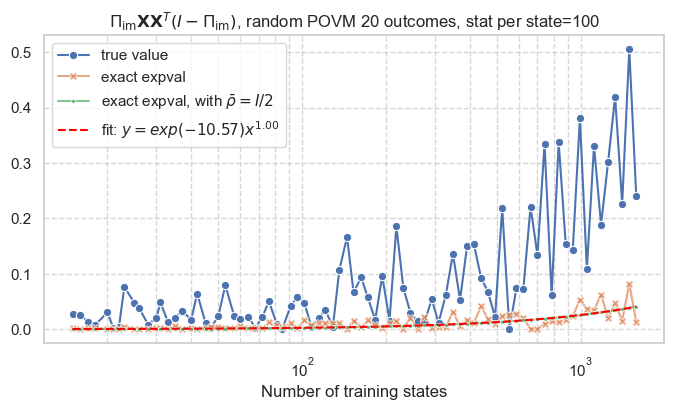

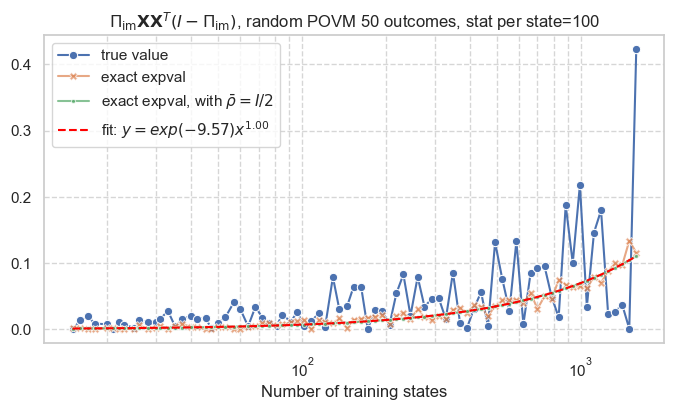

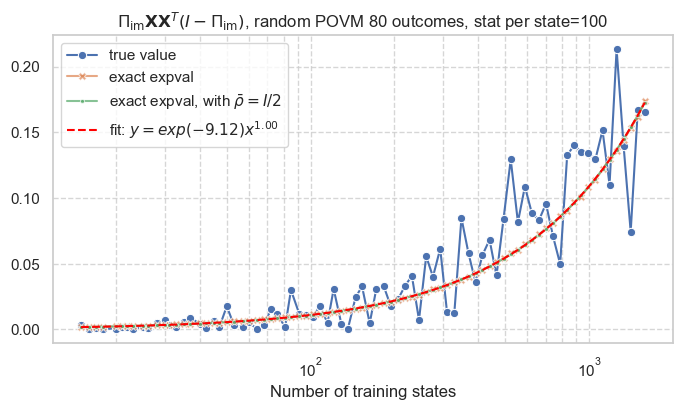

In [171]:
def _(num_outcomes):
    d = 2
    povm = random_rank1_povm(dim=2, num_outcomes=num_outcomes)
    # povm = mub_povm()
    def quantifier(matrix): return np.abs(matrix[0, 4])
    vals = []; vals2 = []; vals3 = []
    n_states_list = np.logspace(1.2, 3.2, num=80, dtype=int)
    for n_states in tqdm(n_states_list, leave=False):
        states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
        train_stat = 100
        true_P = states.measure_povm(povm=povm, statistics=np.inf)
        realizations = []; realizations2 = []; realizations3 = []
        for _ in tqdm(range(1), leave=False):
            dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
            mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
            realizations.append(quantifier(mb.pi_im @ mb.X @ mb.X.T @ (mb.I_im - mb.pi_im)))
            rhobar = states.todm().data.sum(axis=0) / len(states)
            diagmuterm = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), rhobar).real)
            diagmuterm2 = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), np.eye(2) / 2).real)
            realizations2.append(quantifier(mb.pi_im @ diagmuterm2 @ (mb.I_im - mb.pi_im)))
            realizations3.append(quantifier(mb.pi_im @ diagmuterm @ (mb.I_im - mb.pi_im)))
        vals.append(np.mean(realizations)); vals2.append(np.mean(realizations2)); vals3.append(np.mean(realizations3))
    vals = np.array(vals); vals2 = np.array(vals2); vals3 = np.array(vals3)
    plt.figure(figsize=(8, 4));
    plt.title(fr'$\Pi_{{\rm im}}{{\bf XX}}^T(I-\Pi_{{\rm im}})$, random POVM {num_outcomes} outcomes, stat per state={train_stat}')
    sns.lineplot(x=n_states_list, y=vals, marker="o", label="true value")
    sns.lineplot(x=n_states_list, y=vals3, marker="X", label="exact expval", alpha=0.7)
    sns.lineplot(x=n_states_list, y=vals2, marker=".", label=r"exact expval, with $\bar\rho=I/2$", alpha=0.7)
    logfit_and_plot(n_states_list, vals2)
    plt.xscale("log");
    # plt.yscale("log");
    plt.grid(True, which='both', ls='--', alpha=0.8)
    plt.legend(); plt.xlabel("Number of training states");
_(20)
_(50)
_(80)

## (X22 X22^T)^{-1}

$\mathbb E[(\hat{\bf X}_{22}\hat{\bf X}_{22}^T)^{-1}]$

This term seems the source of instabilities when $n_{\rm tr}\simeq n_{\rm out}$:

In [88]:
states = QuantumKetsBatch(random_kets(dim=2, num_kets=50))
povm = random_rank1_povm(dim=2, num_outcomes=50)
true_P = states.measure_povm(povm=povm, statistics=np.inf)
dirty_P = states.measure_povm(povm=povm, statistics=100)
mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=100)
rhobar = states.todm().data.sum(axis=0) / len(states)
diagmuterm = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), rhobar).real)
print(svdvals(diagmuterm - true_P @ true_P.T))
print(svdvals(pinv(diagmuterm - true_P @ true_P.T)))

[3.34506327e+00 2.95543229e+00 2.63707844e+00 2.37731711e+00
 2.13547487e+00 2.01110425e+00 1.78442088e+00 1.67169164e+00
 1.54849205e+00 1.46636724e+00 1.40120289e+00 1.33433621e+00
 1.27101624e+00 1.17801069e+00 1.14229606e+00 1.06979117e+00
 1.01676554e+00 1.00004483e+00 9.76741888e-01 9.29243786e-01
 8.82185220e-01 8.43861927e-01 8.35570520e-01 8.14485453e-01
 7.88028199e-01 7.82979646e-01 7.62591499e-01 7.40140217e-01
 6.89878550e-01 6.35534712e-01 6.16049431e-01 5.52284277e-01
 5.34042660e-01 5.23016427e-01 5.01403486e-01 4.90655783e-01
 4.60128426e-01 4.11683525e-01 3.98244279e-01 3.66276751e-01
 3.46448526e-01 3.19951727e-01 2.83549839e-01 2.61310377e-01
 2.54746724e-01 1.43316701e-01 1.35691215e-01 1.24422227e-01
 9.07785164e-02 7.02562552e-17]
[1.10158222e+01 8.03714919e+00 7.36967387e+00 6.97755385e+00
 3.92546755e+00 3.82686677e+00 3.52671686e+00 3.12547149e+00
 2.88643168e+00 2.73017602e+00 2.51102163e+00 2.42905033e+00
 2.17330629e+00 2.03808868e+00 1.99440177e+00 1.91198

In [89]:
states = QuantumKetsBatch(random_kets(dim=2, num_kets=50))
povm = random_rank1_povm(dim=2, num_outcomes=50)
true_P = states.measure_povm(povm=povm, statistics=np.inf)
dirty_P = states.measure_povm(povm=povm, statistics=100)
mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=100)
rhobar = states.todm().data.sum(axis=0) / len(states)
diagmuterm = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), rhobar).real)
print(svdvals(mb.X @ mb.X.T))
print(svdvals(pinv(mb.X @ mb.X.T)))

[4.49696382e+00 3.64012734e+00 3.33678766e+00 3.07881051e+00
 2.74147242e+00 2.69051342e+00 2.28006826e+00 2.12187020e+00
 2.01505713e+00 1.80905667e+00 1.53326394e+00 1.42628937e+00
 1.36803843e+00 1.31301319e+00 1.19278442e+00 1.14190894e+00
 1.03461190e+00 9.49918729e-01 8.92765543e-01 8.75911378e-01
 7.17833698e-01 6.49622832e-01 6.01708207e-01 5.06693874e-01
 4.95794401e-01 4.31011613e-01 3.64251045e-01 3.53551370e-01
 3.05860861e-01 2.83849670e-01 2.43944951e-01 2.29391187e-01
 1.98146641e-01 1.44576749e-01 1.38012965e-01 1.01644632e-01
 9.46941209e-02 8.21055325e-02 6.06302568e-02 4.12795504e-02
 3.48849290e-02 2.76579042e-02 2.23642172e-02 1.87127798e-02
 1.31268618e-02 8.82796623e-03 6.27382738e-03 1.70158406e-03
 8.15347132e-04 1.61494068e-16]
[1.22647148e+03 5.87687686e+02 1.59392336e+02 1.13276374e+02
 7.61796701e+01 5.34394148e+01 4.47142857e+01 3.61560296e+01
 2.86656739e+01 2.42250701e+01 1.64934152e+01 1.21794472e+01
 1.05603177e+01 9.83819785e+00 7.24569606e+00 6.91674

In [86]:
svdvals(mb.X[:, :50])**2

array([4.25657148e+00, 4.14608646e+00, 3.86976026e+00, 3.10072354e+00,
       2.82049290e+00, 2.80824777e+00, 2.54016331e+00, 2.35279256e+00,
       2.14034121e+00, 1.89984146e+00, 1.81660178e+00, 1.74432218e+00,
       1.40982245e+00, 1.36341560e+00, 1.16365726e+00, 1.11329918e+00,
       1.05879963e+00, 8.81548983e-01, 7.78217984e-01, 6.80296185e-01,
       6.43073355e-01, 5.66767481e-01, 5.37371464e-01, 4.97248596e-01,
       4.61150257e-01, 4.35548623e-01, 3.94341704e-01, 3.62809981e-01,
       3.31480444e-01, 3.12663175e-01, 2.55004604e-01, 2.35452966e-01,
       2.00992375e-01, 1.66631792e-01, 1.37335371e-01, 1.30079435e-01,
       1.01684814e-01, 7.11148297e-02, 6.56108875e-02, 5.45145014e-02,
       4.66468780e-02, 4.00311512e-02, 3.28394707e-02, 2.04985864e-02,
       1.56014700e-02, 1.07733066e-02, 5.38004519e-03, 9.09573114e-04,
       1.61925897e-04, 1.09469389e-32])

In [132]:
states = QuantumKetsBatch(random_kets(dim=2, num_kets=60))
povm = random_rank1_povm(dim=2, num_outcomes=50)
true_P = states.measure_povm(povm=povm, statistics=np.inf)
dirty_P = states.measure_povm(povm=povm, statistics=100)
mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=100)
print(svdvals(mb.X22 @ mb.X22.T))
print(svdvals(pinv(mb.X22 @ mb.X22.T))[:10])

[5.09151254e+00 4.33411243e+00 4.10782138e+00 3.48399484e+00
 3.10021889e+00 2.93590431e+00 2.52712719e+00 2.31798210e+00
 2.18952568e+00 1.87587420e+00 1.80635828e+00 1.56899276e+00
 1.43149726e+00 1.39336019e+00 1.22816532e+00 1.03663807e+00
 9.73876541e-01 9.33882939e-01 8.75337488e-01 8.36086742e-01
 7.70360974e-01 6.77368444e-01 5.95737181e-01 4.94493556e-01
 4.46286521e-01 4.28962659e-01 3.94885216e-01 3.75753201e-01
 3.36258165e-01 2.89485049e-01 2.31592473e-01 2.14521603e-01
 1.74878213e-01 1.39638024e-01 1.37381117e-01 1.11528031e-01
 1.01345304e-01 7.38385158e-02 6.34372944e-02 4.64331645e-02
 4.42602845e-02 2.90390238e-02 2.69760493e-02 1.71440543e-02
 6.66859787e-03 5.63908012e-03 7.43900191e-16 3.87159847e-16
 2.58755284e-16 1.24088767e-16]
[177.33388743 149.95656056  58.32926002  37.06992041  34.43641933
  22.59361887  21.53633102  15.76359788  13.54306745   9.8672554 ]


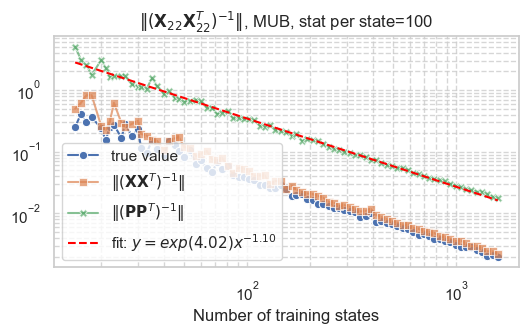

In [70]:
def _():
    d = 2
    # povm = random_rank1_povm(dim=2, num_outcomes=num_outcomes)
    povm = mub_povm()
    def quantifier(matrix): return np.linalg.norm(matrix, ord=2)
    vals = []; vals2 = []; vals3 = []
    n_states_list = np.logspace(1.2, 3.2, num=80, dtype=int)
    for n_states in n_states_list:
        states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
        train_stat = 100
        true_P = states.measure_povm(povm=povm, statistics=np.inf)
        realizations = [0]; realizations2 = [0]; realizations3 = [0]
        for _ in range(1):
            dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
            mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
            realizations.append(quantifier(pinv(mb.X22 @ mb.X22.T)))
            realizations2.append(quantifier(pinv(mb.X @ mb.X.T)))
            realizations3.append(quantifier(truncated_pinv(mb.true_P @ mb.true_P.T, 4)))
            # realizations2.append(quantifier(mb.pi_im @ diagmuterm @ (mb.I_im - mb.pi_im)))
            # realizations3.append(quantifier(mb.pi_im @ diagmuterm @ (mb.I_im - mb.pi_im)))
        vals.append(np.mean(realizations)); vals2.append(np.mean(realizations2)); vals3.append(np.mean(realizations3))
    vals = np.array(vals); vals2 = np.array(vals2); vals3 = np.array(vals3)
    plt.figure(figsize=(6, 3))
    plt.title(fr'$\|(\mathbf{{X}}_{{22}}\mathbf{{X}}_{{22}}^T)^{{-1}}\|$, MUB, stat per state={train_stat}')
    sns.lineplot(x=n_states_list, y=vals, marker="o", label='true value')
    sns.lineplot(x=n_states_list, y=vals2, marker="s", label=r"$\|({\bf XX}^T)^{-1}\|$", alpha=0.7)
    sns.lineplot(x=n_states_list, y=vals3, marker="X", label=r"$\|({\bf PP}^T)^{-1}\|$", alpha=0.7)
    logfit_and_plot(n_states_list, vals3)
    plt.xscale("log"); plt.yscale("log");
    plt.grid(True, which='both', ls='--', alpha=0.8)
    plt.legend(); plt.xlabel("Number of training states");
    plt.show()
_()

In [ ]:
def _(num_outcomes):
    d = 2
    povm = random_rank1_povm(dim=2, num_outcomes=num_outcomes)
    # povm = mub_povm()
    def quantifier(matrix): return np.linalg.norm(matrix, ord=2)
    vals = []; vals2 = []; vals3 = []; vals4 = []
    n_states_list = np.logspace(1.2, 3.2, num=80, dtype=int)
    for n_states in n_states_list:
        states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
        train_stat = 100
        true_P = states.measure_povm(povm=povm, statistics=np.inf)
        realizations = [0]; realizations2 = [0]; realizations3 = [0]; realizations4 = [0]
        for _ in range(1):
            dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
            mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
            realizations.append(quantifier(pinv(mb.X22 @ mb.X22.T)))
            realizations2.append(quantifier(pinv(mb.X @ mb.X.T)))
            realizations3.append(quantifier(truncated_pinv(mb.true_P @ mb.true_P.T, 4)))
            diagmuterm2inv = 1 / len(states) * np.diag(1 / np.einsum('ijk,jk->i', povm.data.conj(), np.eye(2) / 2).real)
            realizations4.append(quantifier((mb.I_im - mb.pi_im) @ diagmuterm2inv @ (mb.I_im - mb.pi_im)))
        vals.append(np.mean(realizations)); vals2.append(np.mean(realizations2)); vals3.append(np.mean(realizations3)); vals4.append(np.mean(realizations4))
    vals = np.array(vals); vals2 = np.array(vals2); vals3 = np.array(vals3); vals4 = np.array(vals4)
    plt.figure(figsize=(8, 4))
    plt.title(fr'random POVM {num_outcomes} outcomes, stat per state={train_stat}')
    logfit_and_plot(n_states_list, vals4)
    sns.lineplot(x=n_states_list, y=vals, marker="o", label=r'$\|(\mathbf{{X}}_{{22}}\mathbf{{X}}_{{22}}^T)^{{-1}}\|$')
    sns.lineplot(x=n_states_list, y=vals2, marker="s", label=r"$\|({\bf XX}^T)^{-1}\|$", alpha=0.7)
    sns.lineplot(x=n_states_list, y=vals3, marker="X", label=r"$\|({\bf PP}^T)^{-1}\|$", alpha=0.7)
    sns.lineplot(x=n_states_list, y=vals4, marker="P", label=r"$\|(\mathbf{I}-\mathbf{\Pi}_{\rm im})\frac{\mathrm{diag}(\operatorname{Tr}(\boldsymbol{\mu}\bar\rho)^{-1})}{n_{\rm tr}}(\mathbf{I}-\mathbf{\Pi}_{\rm im})\|$", alpha=0.7)
    plt.xscale("log"); plt.yscale("log");
    plt.grid(True, which='both', ls='--', alpha=0.8)
    plt.legend(); plt.xlabel("Number of training states");
    plt.show()
_(num_outcomes=10)
_(num_outcomes=20)
_(num_outcomes=40)
_(num_outcomes=80)

In [36]:
svdvals(pinv(np.diag([2, 3, 1, 0])))[0]
norm(pinv(np.diag([2, 3, 1, 0])), ord=2)

1.0

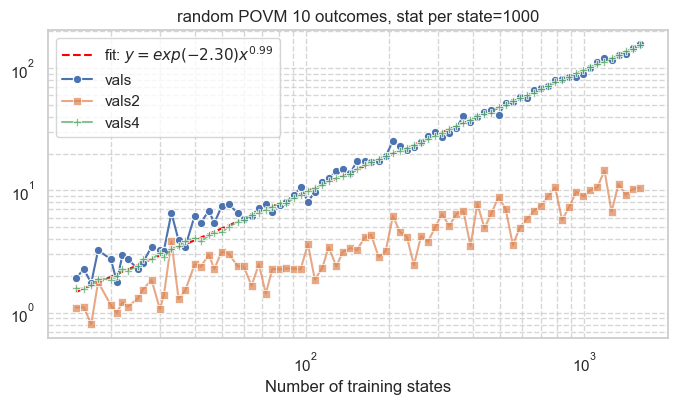

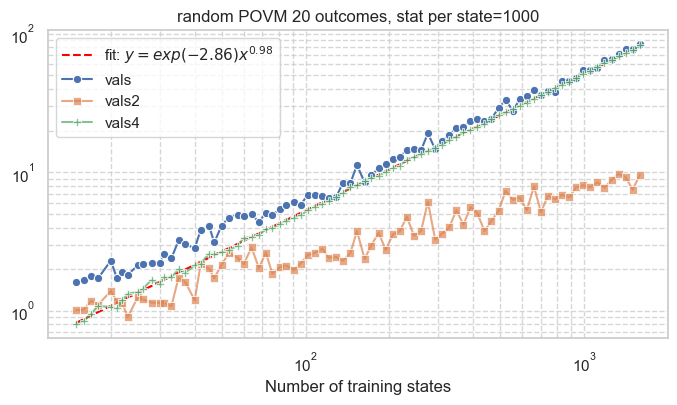

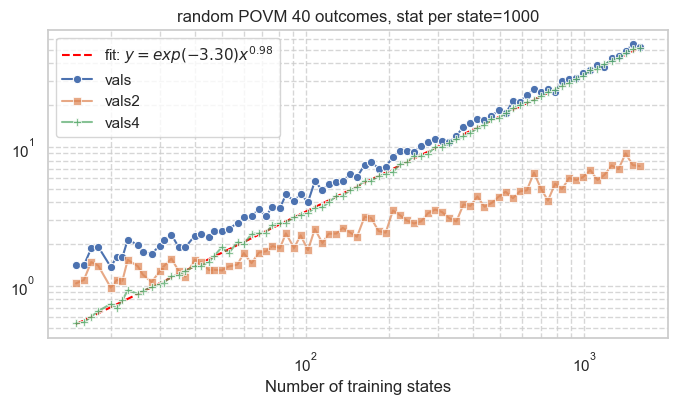

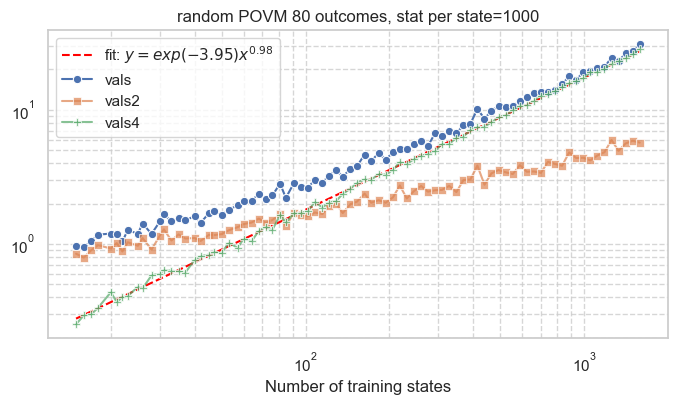

In [55]:
def _(num_outcomes):
    d = 2
    povm = random_rank1_povm(dim=2, num_outcomes=num_outcomes)
    # povm = mub_povm()
    # def quantifier(matrix): return norm(pinv(matrix), ord=2)
    def quantifier(matrix): return norm(matrix, ord=2)
    vals = []; vals2 = []; vals3 = []; vals4 = []
    n_states_list = np.logspace(1.2, 3.2, num=80, dtype=int)
    for n_states in n_states_list:
        states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
        train_stat = 1000
        true_P = states.measure_povm(povm=povm, statistics=np.inf)
        realizations = [0]; realizations2 = [0]; realizations3 = [0]; realizations4 = [0]
        for _ in range(1):
            dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
            mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
            rhobar = states.todm().data.sum(axis=0) / len(states)
            diagmuterm = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), rhobar).real)
            realizations.append(quantifier(mb.X @ mb.X.T))
            realizations2.append(quantifier((mb.X @ mb.X.T - (diagmuterm - true_P @ true_P.T))))
            realizations4.append(quantifier(diagmuterm - true_P @ true_P.T))
        vals.append(np.mean(realizations)); vals2.append(np.mean(realizations2)); vals3.append(np.mean(realizations3)); vals4.append(np.mean(realizations4))
    vals = np.array(vals); vals2 = np.array(vals2); vals3 = np.array(vals3); vals4 = np.array(vals4)
    plt.figure(figsize=(8, 4))
    plt.title(fr'random POVM {num_outcomes} outcomes, stat per state={train_stat}')
    logfit_and_plot(n_states_list, vals4)
    sns.lineplot(x=n_states_list, y=vals, marker="o", label=r'vals')
    sns.lineplot(x=n_states_list, y=vals2, marker="s", label=r"vals2", alpha=0.7)
    sns.lineplot(x=n_states_list, y=vals4, marker="P", label=r"vals4", alpha=0.7)
    plt.xscale("log");
    plt.yscale("log");
    plt.grid(True, which='both', ls='--', alpha=0.8)
    plt.legend(); plt.xlabel("Number of training states");
    plt.show()
_(num_outcomes=10)
_(num_outcomes=20)
_(num_outcomes=40)
_(num_outcomes=80)

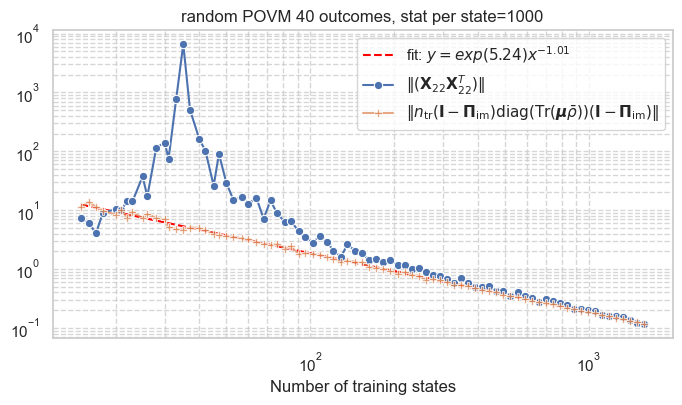

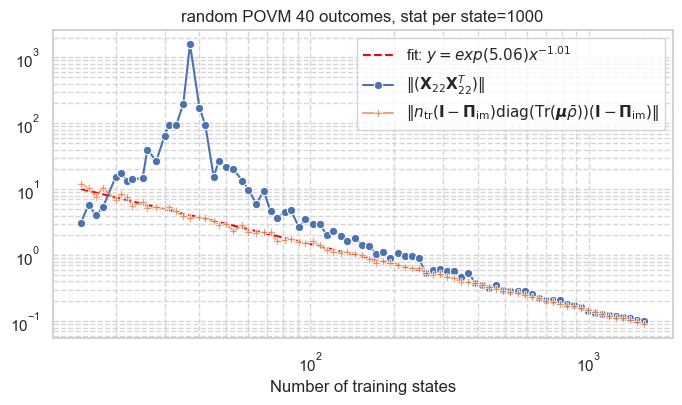

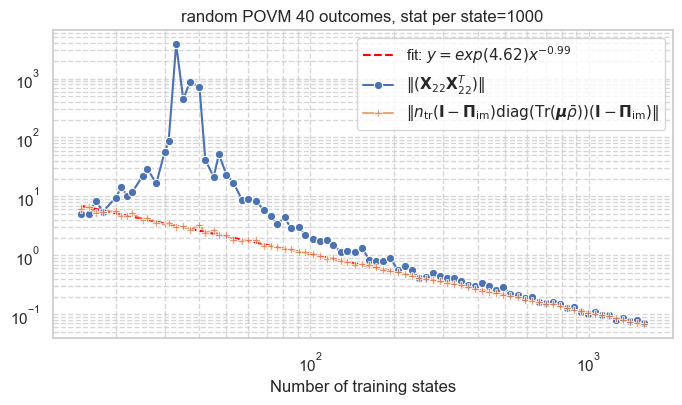

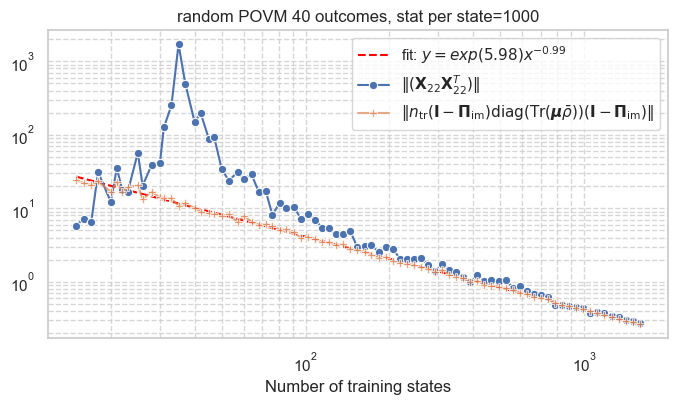

In [108]:
def _(num_outcomes):
    d = 2
    povm = random_rank1_povm(dim=2, num_outcomes=num_outcomes)
    # povm = mub_povm()
    def quantifier(matrix): return norm(pinv(matrix), ord=2)
    vals = []; vals2 = []; vals3 = []; vals4 = []
    n_states_list = np.logspace(1.2, 3.2, num=80, dtype=int)
    for n_states in n_states_list:
        states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
        train_stat = 1000
        true_P = states.measure_povm(povm=povm, statistics=np.inf)
        realizations = [0]; realizations2 = [0]; realizations3 = [0]; realizations4 = [0]
        for _ in range(1):
            dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
            mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
            realizations.append(quantifier((mb.I_im - mb.pi_im) @ mb.X @ mb.X.T @ (mb.I_im - mb.pi_im)))
            # realizations2.append(quantifier((mb.X @ mb.X.T)))
            rhobar = states.todm().data.sum(axis=0) / len(states)
            diagmuterm = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), rhobar).real)
            realizations4.append(quantifier((mb.I_im - mb.pi_im) @ diagmuterm @ (mb.I_im - mb.pi_im)))
        vals.append(np.mean(realizations)); vals2.append(np.mean(realizations2)); vals3.append(np.mean(realizations3)); vals4.append(np.mean(realizations4))
    vals = np.array(vals); vals2 = np.array(vals2); vals3 = np.array(vals3); vals4 = np.array(vals4)
    plt.figure(figsize=(8, 4))
    plt.title(fr'random POVM {num_outcomes} outcomes, stat per state={train_stat}')
    logfit_and_plot(n_states_list, vals4)
    sns.lineplot(x=n_states_list, y=vals, marker="o", label=r'$\|(\mathbf{{X}}_{{22}}\mathbf{{X}}_{{22}}^T)\|$')
    # sns.lineplot(x=n_states_list, y=vals2, marker="s", label=r"$\|({\bf XX}^T)\|$", alpha=0.7)
    sns.lineplot(x=n_states_list, y=vals4, marker="P", label=r"$\|n_{\rm tr}(\mathbf{I}-\mathbf{\Pi}_{\rm im})\mathrm{diag}(\operatorname{Tr}(\boldsymbol{\mu}\bar\rho))(\mathbf{I}-\mathbf{\Pi}_{\rm im})\|$", alpha=0.7)
    plt.xscale("log");
    plt.yscale("log");
    plt.grid(True, which='both', ls='--', alpha=0.8)
    plt.legend(); plt.xlabel("Number of training states");
    plt.show()
_(num_outcomes=40)
_(num_outcomes=40)
_(num_outcomes=40)
_(num_outcomes=40)

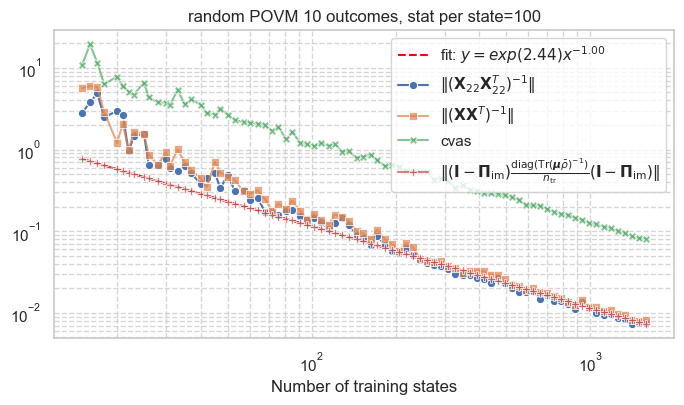

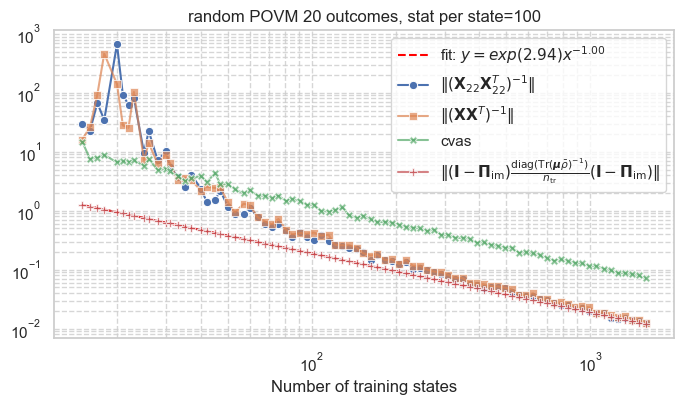

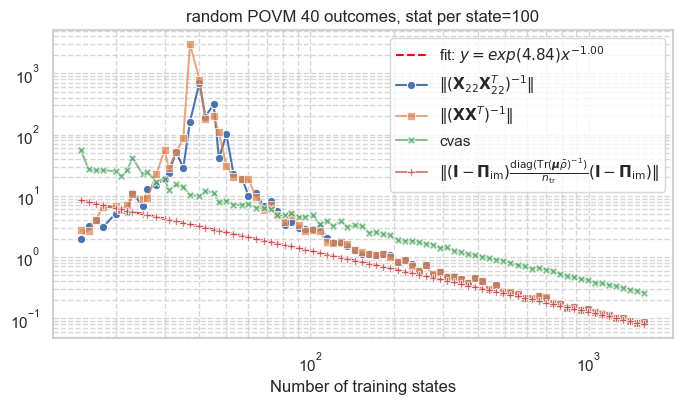

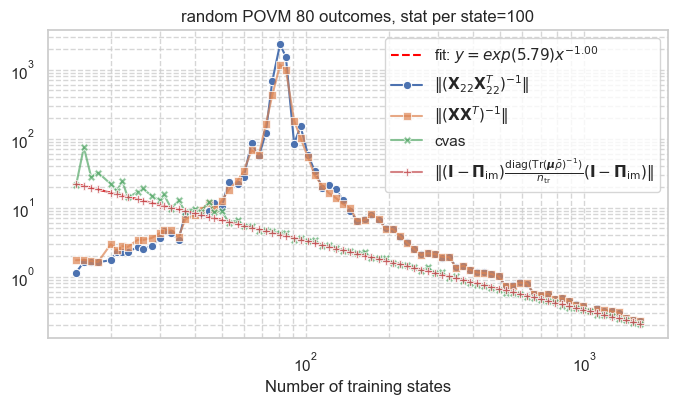

In [62]:
def _(num_outcomes):
    d = 2
    povm = random_rank1_povm(dim=2, num_outcomes=num_outcomes)
    # povm = mub_povm()
    def quantifier(matrix): return np.linalg.norm(matrix, ord=2)
    vals = []; vals2 = []; vals3 = []; vals4 = []
    n_states_list = np.logspace(1.2, 3.2, num=80, dtype=int)
    for n_states in n_states_list:
        states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
        train_stat = 100
        true_P = states.measure_povm(povm=povm, statistics=np.inf)
        realizations = [0]; realizations2 = [0]; realizations3 = [0]; realizations4 = [0]
        for _ in range(1):
            dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
            mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
            realizations.append(quantifier(pinv(mb.X22 @ mb.X22.T)))
            realizations2.append(quantifier(pinv(mb.X @ mb.X.T)))
            realizations3.append(quantifier(pinv(true_P @ mb.true_P.T)))
            diagmuterm2inv = 1 / len(states) * np.diag(1 / np.einsum('ijk,jk->i', povm.data.conj(), np.eye(2) / 2).real)
            realizations4.append(quantifier((mb.I_im - mb.pi_im) @ diagmuterm2inv @ (mb.I_im - mb.pi_im)))
        vals.append(np.mean(realizations)); vals2.append(np.mean(realizations2)); vals3.append(np.mean(realizations3)); vals4.append(np.mean(realizations4))
    vals = np.array(vals); vals2 = np.array(vals2); vals3 = np.array(vals3); vals4 = np.array(vals4)
    plt.figure(figsize=(8, 4))
    plt.title(fr'random POVM {num_outcomes} outcomes, stat per state={train_stat}')
    logfit_and_plot(n_states_list, vals4)
    sns.lineplot(x=n_states_list, y=vals, marker="o", label=r'$\|(\mathbf{{X}}_{{22}}\mathbf{{X}}_{{22}}^T)^{{-1}}\|$')
    sns.lineplot(x=n_states_list, y=vals2, marker="s", label=r"$\|({\bf XX}^T)^{-1}\|$", alpha=0.7)
    sns.lineplot(x=n_states_list, y=vals3, marker="X", label=r"cvas", alpha=0.7)
    sns.lineplot(x=n_states_list, y=vals4, marker="P", label=r"$\|(\mathbf{I}-\mathbf{\Pi}_{\rm im})\frac{\mathrm{diag}(\operatorname{Tr}(\boldsymbol{\mu}\bar\rho)^{-1})}{n_{\rm tr}}(\mathbf{I}-\mathbf{\Pi}_{\rm im})\|$", alpha=0.7)
    plt.xscale("log"); plt.yscale("log");
    plt.grid(True, which='both', ls='--', alpha=0.8)
    plt.legend(); plt.xlabel("Number of training states");
    plt.show()
_(num_outcomes=10)
_(num_outcomes=20)
_(num_outcomes=40)
_(num_outcomes=80)

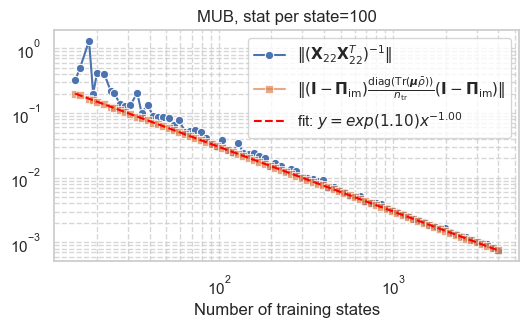

In [6]:
def _():
    d = 2
    # povm = random_rank1_povm(dim=2, num_outcomes=num_outcomes)
    povm = mub_povm()
    def quantifier(matrix): return np.linalg.norm(matrix, ord=2)
    vals = []; vals2 = []; vals3 = []
    n_states_list = np.logspace(1.2, 3.6, num=80, dtype=int)
    for n_states in tqdm(n_states_list, leave=False, disable=True):
        states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
        train_stat = 100
        true_P = states.measure_povm(povm=povm, statistics=np.inf)
        realizations = [0]; realizations2 = [0]; realizations3 = [0]
        for _ in tqdm(range(1), leave=False, disable=True):
            dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
            mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
            realizations.append(quantifier(pinv(mb.X22 @ mb.X22.T)))
            rhobar = states.todm().data.sum(axis=0) / len(states)
            diagmuterm = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), rhobar).real)
            diagmuterm2inv = 1 / len(states) * np.diag(1 / np.einsum('ijk,jk->i', povm.data.conj(), np.eye(2) / 2).real)
            realizations2.append(quantifier((mb.I_im - mb.pi_im) @ diagmuterm2inv @ (mb.I_im - mb.pi_im)))
            # realizations2.append(quantifier(pinv(mb.X @ mb.X.T)))
            # realizations3.append(quantifier(mb.X11))
            # realizations2.append(quantifier(mb.pi_im @ diagmuterm @ (mb.I_im - mb.pi_im)))
            # realizations3.append(quantifier(mb.pi_im @ diagmuterm @ (mb.I_im - mb.pi_im)))
        vals.append(np.mean(realizations)); vals2.append(np.mean(realizations2)); vals3.append(np.mean(realizations3))
    vals = np.array(vals); vals2 = np.array(vals2); vals3 = np.array(vals3)
    plt.figure(figsize=(6, 3))
    plt.title(fr'MUB, stat per state={train_stat}')
    sns.lineplot(x=n_states_list, y=vals, marker="o", label=fr'$\|(\mathbf{{X}}_{{22}}\mathbf{{X}}_{{22}}^T)^{{-1}}\|$')
    sns.lineplot(x=n_states_list, y=vals2, marker="s", label=r"$\|(\mathbf{I}-\mathbf{\Pi}_{\rm im})\frac{\mathrm{diag}(\operatorname{Tr}(\boldsymbol{\mu}\bar\rho))}{n_{\rm tr}}(\mathbf{I}-\mathbf{\Pi}_{\rm im})\|$", alpha=0.7)
    # sns.lineplot(x=n_states_list, y=vals3, marker="X", label=r"$\|({\bf PP}^T)^{-1}\|$", alpha=0.7)
    logfit_and_plot(n_states_list, vals2)
    plt.xscale("log"); plt.yscale("log");
    plt.grid(True, which='both', ls='--', alpha=0.8)
    plt.legend(); plt.xlabel("Number of training states");
    plt.show()
_()

In [92]:
np.logspace(1.2, 3.2, num=80, dtype=int)
(1-np.sqrt(40 / np.logspace(1.2, 3.2, num=80, dtype=int)))**2

array([4.00680343e-01, 3.37722340e-01, 2.85081221e-01, 2.40798252e-01,
       1.71572875e-01, 1.44499667e-01, 1.21382368e-01, 1.01608541e-01,
       7.01778719e-02, 5.77668467e-02, 3.81142099e-02, 2.39322566e-02,
       1.84752437e-02, 1.01936819e-02, 4.76720756e-03, 1.58010144e-03,
       0.00000000e+00, 5.80806484e-04, 3.27080572e-03, 6.00141373e-03,
       1.11456180e-02, 1.72280101e-02, 2.63387528e-02, 3.36735048e-02,
       4.38611699e-02, 5.43053164e-02, 6.48435706e-02, 7.53632893e-02,
       8.83704226e-02, 9.85995542e-02, 1.13573351e-01, 1.25672218e-01,
       1.39708281e-01, 1.53209131e-01, 1.68290438e-01, 1.80659363e-01,
       1.96385427e-01, 2.09465358e-01, 2.25410606e-01, 2.38817923e-01,
       2.54643964e-01, 2.68072495e-01, 2.83530071e-01, 2.98032349e-01,
       3.12869459e-01, 3.26780365e-01, 3.40909795e-01, 3.55143270e-01,
       3.69381613e-01, 3.82684474e-01, 3.96753091e-01, 4.09867075e-01,
       4.23520924e-01, 4.36879025e-01, 4.49914686e-01, 4.62608769e-01,
      

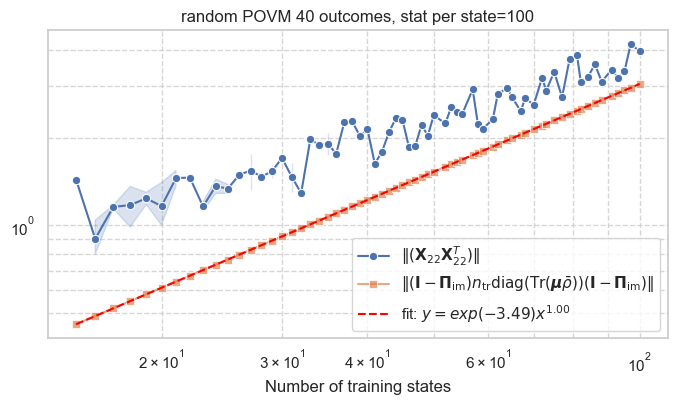

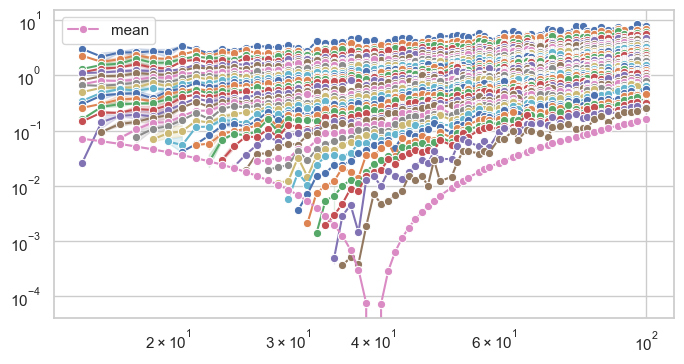

In [ ]:
def _(num_outcomes):
    d = 2
    povm = random_rank1_povm(dim=2, num_outcomes=num_outcomes)
    # povm = mub_povm()
    def quantifier(matrix): return norm(matrix, ord=2)
    vals = []; vals2 = []; vals3 = []
    n_states_list = np.logspace(1.2, 2, num=80, dtype=int)
    svals = np.zeros(shape=(len(n_states_list), len(povm) - d**2))
    for idx, n_states in enumerate(n_states_list):
        states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
        train_stat = 100
        true_P = states.measure_povm(povm=povm, statistics=np.inf)
        realizations = [0]; realizations2 = [0]; realizations3 = [0]
        rhobar = states.todm().data.sum(axis=0) / len(states)
        diagmuterm2 = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), np.eye(2) / 2).real)
        sigma2 = np.trace(diagmuterm2 - true_P @ true_P.T) / (len(povm))
        dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
        mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
        G = (mb.X22 @ mb.X22.T)
        approx_term = (mb.I_im - mb.pi_im) @ diagmuterm2 @ (mb.I_im - mb.pi_im)
        svals[idx] = svdvals((mb.I_im - mb.pi_im) @ mb.X @ mb.X.T @ (mb.I_im - mb.pi_im))[:svals.shape[1]]
        # svals[idx] = svdvals(approx_term)[:svals.shape[1]]
        realizations.append(quantifier(G))
        realizations2.append(quantifier(approx_term))
        realizations3.append(sigma2)
        # realizations2.append(quantifier(pinv(mb.X @ mb.X.T)))
        # realizations3.append(quantifier(mb.X11))
        # realizations2.append(quantifier(mb.pi_im @ diagmuterm @ (mb.I_im - mb.pi_im)))
        # realizations3.append(quantifier(mb.pi_im @ diagmuterm @ (mb.I_im - mb.pi_im)))
        vals.append(np.mean(realizations)); vals2.append(np.mean(realizations2)); vals3.append(np.mean(realizations3))
    vals = np.array(vals); vals2 = np.array(vals2); vals3 = np.array(vals3)
    plt.figure(figsize=(8, 4))
    plt.title(fr'random POVM {num_outcomes} outcomes, stat per state={train_stat}')
    sns.lineplot(x=n_states_list, y=vals, marker="o", label=fr'$\|(\mathbf{{X}}_{{22}}\mathbf{{X}}_{{22}}^T)\|$')
    sns.lineplot(x=n_states_list, y=vals2, marker="s", label=r"$\|(\mathbf{I}-\mathbf{\Pi}_{\rm im})n_{\rm tr}\mathrm{diag}(\operatorname{Tr}(\boldsymbol{\mu}\bar\rho))(\mathbf{I}-\mathbf{\Pi}_{\rm im})\|$", alpha=0.7)
    # sns.lineplot(x=n_states_list, y=vals3, marker="X", label=r"$\|({\bf PP}^T)^{-1}\|$", alpha=0.7)
    logfit_and_plot(n_states_list, vals2)
    plt.xscale("log"); plt.yscale("log");
    plt.grid(True, which='both', ls='--', alpha=0.8)
    plt.legend(); plt.xlabel("Number of training states");
    plt.show()
    plt.figure(figsize=(8, 4))
    plt.xscale("log"); plt.yscale("log");
    svals[svals < 1e-10] = np.nan
    for i in range(svals.shape[1]):
        sns.lineplot(x=n_states_list, y=svals[:, i], marker="o")
    sns.lineplot(x=n_states_list, y=vals3 * (1-np.sqrt(len(povm) / n_states_list))**2, marker="o", label="mean")
# _(num_outcomes=10)
# _(num_outcomes=20)
# _(num_outcomes=30)
_(num_outcomes=40)

## X12 X22^+

Focus on $\mathbb E[\mathbf X_{12}\mathbf X_{22}^+]$.

In [3]:
states = QuantumKetsBatch(random_kets(dim=2, num_kets=10**3))
povm = random_rank1_povm(dim=2, num_outcomes=10)
true_P = states.measure_povm(povm, statistics=np.inf)
dirty_P = states.measure_povm(povm, statistics=100)
mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=100)
print(svdvals(mb.X22))
print(svdvals(pinv(mb.X22)))

[1.08461499e+01 1.02773692e+01 8.64834380e+00 7.65856190e+00
 6.55487929e+00 5.94614008e+00 1.72302824e-14 8.67649036e-15
 6.13613599e-15 4.69448362e-15]
[6.56365127e+13 1.68393368e-01 1.52626069e-01 1.30557782e-01
 1.15649374e-01 9.80325308e-02 9.21922515e-02 7.45513784e-03
 1.83340108e-03 6.30466390e-04]


In [6]:
mb.X21.shape

(10, 1000)

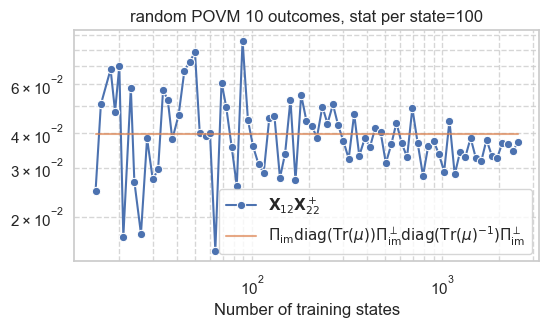

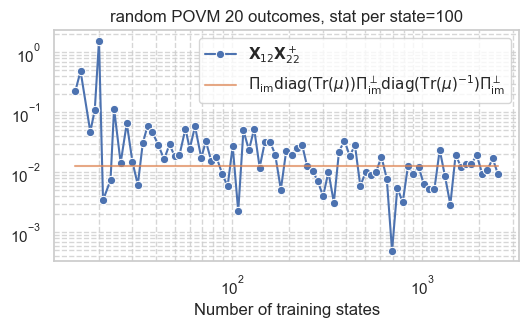

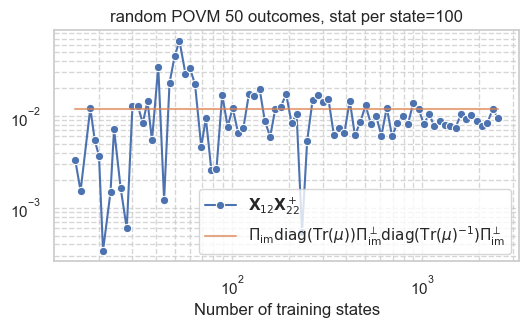

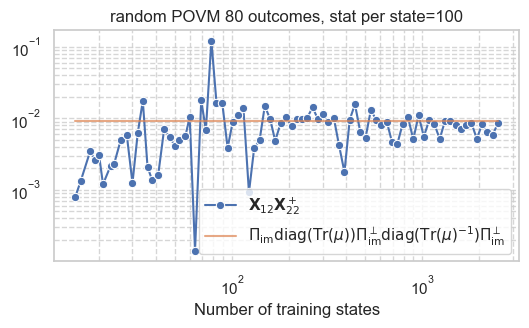

In [57]:
def _(num_outcomes):
    d = 2
    povm = random_rank1_povm(dim=2, num_outcomes=num_outcomes)
    # povm = mub_povm()
    def quantifier(matrix): return abs(matrix)[2, 2]
    vals = []; vals2 = []; vals3 = []; vals4 = []
    n_states_list = np.logspace(1.2, 3.4, num=80, dtype=int)
    for n_states in n_states_list:
        states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
        train_stat = 100
        true_P = states.measure_povm(povm=povm, statistics=np.inf)
        realizations = [0]; realizations2 = [0]; realizations3 = [0]; realizations4 = [0]
        for _ in range(1):
            dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
            mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
            X22pinv = truncated_pinv(mb.X22, num_outcomes - d**2)
            realizations.append(quantifier(mb.X12 @ X22pinv))
            rhobar = states.todm().data.sum(axis=0) / len(states)
            diagmuterm = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), rhobar).real)
            diagmuterm2 = len(states) * np.diag(np.einsum('ijk,jk->i', povm.data.conj(), np.eye(2) / 2).real)
            diagmuterm2inv = 1 / len(states) * np.diag(1 / np.einsum('ijk,jk->i', povm.data.conj(), np.eye(2) / 2).real)
            normPPTinv = norm(truncated_pinv(mb.true_P @ mb.true_P.T, 4), ord=2)
            realizations2.append(quantifier(mb.pi_im @ diagmuterm2 @ (mb.I_im - mb.pi_im) @ diagmuterm2inv @ (mb.I_im - mb.pi_im)))
            # realizations2.append(quantifier(pinv(mb.X @ mb.X.T)))
            realizations3.append(quantifier(mb.X11))
            realizations4.append(quantifier(mb.X12 @ X22pinv @ mb.X21))
            # realizations2.append(quantifier(mb.pi_im @ diagmuterm @ (mb.I_im - mb.pi_im)))
            # realizations3.append(quantifier(mb.pi_im @ diagmuterm @ (mb.I_im - mb.pi_im)))
        vals.append(np.mean(realizations)); vals2.append(np.mean(realizations2)); vals3.append(np.mean(realizations3)); vals4.append(np.mean(realizations4))
    vals = np.array(vals); vals2 = np.array(vals2); vals3 = np.array(vals3); vals4 = np.array(vals4)
    plt.figure(figsize=(6, 3))
    plt.title(fr'random POVM {num_outcomes} outcomes, stat per state={train_stat}')
    sns.lineplot(x=n_states_list, y=vals, marker="o", label=r'$\mathbf{X}_{12} \mathbf{X}_{22}^+$')
    # sns.lineplot(x=n_states_list, y=vals4, marker="o", label=r'$\mathbf{X}_{12} \mathbf{X}_{22}^+ \mathbf{X}_{21}$')
    sns.lineplot(x=n_states_list, y=vals2, marker="", label=r"$\Pi_{\rm im} \operatorname{diag}(\operatorname{Tr}(\mu)) \Pi_{\rm im}^\perp \operatorname{diag}(\operatorname{Tr}(\mu)^{-1})\Pi_{\rm im}^\perp$", alpha=0.7)
    # sns.lineplot(x=n_states_list, y=vals3, marker="X", label=r"${\bf X}_{11}$", alpha=0.7)
    # logfit_and_plot(n_states_list, vals3)
    plt.xscale("log");
    plt.yscale("log");
    plt.grid(True, which='both', ls='--', alpha=0.8)
    plt.legend(); plt.xlabel("Number of training states");
    plt.show()
_(num_outcomes=10)
_(num_outcomes=20)
_(num_outcomes=50)
_(num_outcomes=80)

## X12 X22^+ X21

Focus on $\mathbb E[\mathbf X_{12}\mathbf X_{22}^+\mathbf X_{21}]$.

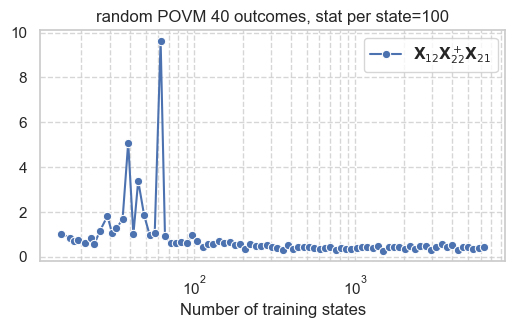

In [8]:
def _(num_outcomes):
    d = 2
    train_stat = 100
    povm = random_rank1_povm(dim=2, num_outcomes=num_outcomes)
    # povm = mub_povm()
    def quantifier(matrix): return norm(matrix)
    all_results = []
    n_states_list = np.logspace(1.2, 3.8, num=80, dtype=int)
    for n_states in n_states_list:
        states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
        true_P = states.measure_povm(povm=povm, statistics=np.inf)
        realizations = []
        for _ in range(1):
            metrics = []
            dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
            mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
            X22pinv = truncated_pinv(mb.X22, num_outcomes - d**2)
            metrics.append(quantifier(mb.X12 @ X22pinv @ mb.X21))
            realizations.append(metrics)
        all_results.append(np.array(realizations).mean(axis=0))
    all_results = np.array(all_results)
    plt.figure(figsize=(6, 3))
    plt.title(fr'random POVM {num_outcomes} outcomes, stat per state={train_stat}')
    # Plot each metric
    labels = [r'$\mathbf{X}_{12} \mathbf{X}_{22}^+ \mathbf{X}_{21}$']
    markers = ["o"]
    alphas = [1.0]
    for i in range(all_results.shape[1]):
        sns.lineplot(x=n_states_list, y=all_results[:, i], marker=markers[i], label=labels[i], alpha=alphas[i])
    # logfit_and_plot(n_states_list, all_results[:, 0])
    plt.xscale("log");
    # plt.yscale("log");
    plt.grid(True, which='both', ls='--', alpha=0.8)
    plt.legend(); plt.xlabel("Number of training states");
    plt.show()
# _(num_outcomes=10)
_(num_outcomes=40)

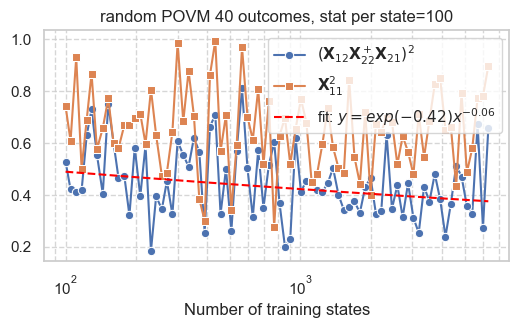

In [46]:
def _(num_outcomes):
    d = 2
    train_stat = 100
    povm = random_rank1_povm(dim=2, num_outcomes=num_outcomes)
    # povm = mub_povm()
    def quantifier(matrix): return norm(matrix, ord=2)
    all_results = []
    n_states_list = np.logspace(2, 3.8, num=80, dtype=int)
    for n_states in n_states_list:
        states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
        true_P = states.measure_povm(povm=povm, statistics=np.inf)
        realizations = []
        for _ in range(1):
            metrics = []
            dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
            mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
            X22pinv = truncated_pinv(mb.X22, num_outcomes - d**2)
            metrics.append(quantifier(mb.X12 @ X22pinv @ mb.X21))
            metrics.append(quantifier(mb.X11))
            realizations.append(metrics)
        all_results.append(np.array(realizations).mean(axis=0))
    all_results = np.array(all_results)
    plt.figure(figsize=(6, 3))
    plt.title(fr'random POVM {num_outcomes} outcomes, stat per state={train_stat}')
    # Plot each metric
    labels = [r'$(\mathbf{X}_{12} \mathbf{X}_{22}^+ \mathbf{X}_{21})^2$', r'$\mathbf{X}_{11}^2$']
    markers = ["o", "s"]
    alphas = [1.0, 1.0]
    for i in range(all_results.shape[1]):
        sns.lineplot(x=n_states_list, y=all_results[:, i], marker=markers[i], label=labels[i], alpha=alphas[i])
    logfit_and_plot(n_states_list, all_results[:, 0])
    plt.xscale("log");
    # plt.yscale("log");
    plt.grid(True, which='both', ls='--', alpha=0.8)
    plt.legend(); plt.xlabel("Number of training states");
    plt.show()
# _(num_outcomes=10)
_(num_outcomes=40)

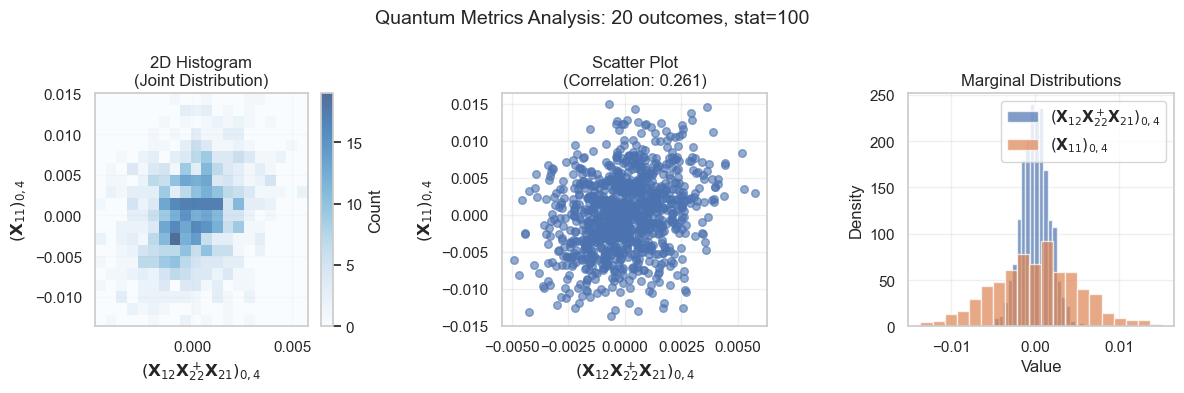

Summary Statistics:
Metric 1 - Mean: -0.0000, Std: 0.0017
Metric 2 - Mean: 0.0001, Std: 0.0051
Correlation coefficient: 0.2614


In [52]:
def _(num_outcomes):
    d = 2
    train_stat = 100
    povm = random_rank1_povm(dim=2, num_outcomes=num_outcomes)
    # povm = mub_povm()
    def quantifier(matrix): return (matrix)[0, 4]
    n_states = 10**3
    states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
    true_P = states.measure_povm(povm=povm, statistics=np.inf)
    realizations = []
    for _ in range(1000):
        metrics = []
        dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
        mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
        X22pinv = truncated_pinv(mb.X22, num_outcomes - d**2)
        metrics.append(quantifier(mb.X12 @ X22pinv @ mb.X21))
        metrics.append(quantifier(mb.X11))
        realizations.append(metrics)
    realizations = np.array(realizations)
    
    # Create 2D histogram to show distributions and correlation
    plt.figure(figsize=(12, 4))
    
    # Plot 1: 2D histogram
    plt.subplot(1, 3, 1)
    plt.hist2d(realizations[:, 0], realizations[:, 1], bins=20, cmap='Blues', alpha=0.7)
    plt.colorbar(label='Count')
    plt.xlabel(r'$(\mathbf{X}_{12} \mathbf{X}_{22}^+ \mathbf{X}_{21})_{0,4}$')
    plt.ylabel(r'$(\mathbf{X}_{11})_{0,4}$')
    plt.title('2D Histogram\n(Joint Distribution)')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Scatter plot with correlation
    plt.subplot(1, 3, 2)
    plt.scatter(realizations[:, 0], realizations[:, 1], alpha=0.6, s=30)
    plt.xlabel(r'$(\mathbf{X}_{12} \mathbf{X}_{22}^+ \mathbf{X}_{21})_{0,4}$')
    plt.ylabel(r'$(\mathbf{X}_{11})_{0,4}$')
    
    # Calculate and display correlation
    correlation = np.corrcoef(realizations[:, 0], realizations[:, 1])[0, 1]
    plt.title(f'Scatter Plot\n(Correlation: {correlation:.3f})')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Marginal distributions
    plt.subplot(1, 3, 3)
    plt.hist(realizations[:, 0], bins=20, alpha=0.7, label=r'$(\mathbf{X}_{12} \mathbf{X}_{22}^+ \mathbf{X}_{21})_{0,4}$', density=True)
    plt.hist(realizations[:, 1], bins=20, alpha=0.7, label=r'$(\mathbf{X}_{11})_{0,4}$', density=True)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Marginal Distributions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'Quantum Metrics Analysis: {num_outcomes} outcomes, stat={train_stat}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Summary Statistics:")
    print(f"Metric 1 - Mean: {np.mean(realizations[:, 0]):.4f}, Std: {np.std(realizations[:, 0]):.4f}")
    print(f"Metric 2 - Mean: {np.mean(realizations[:, 1]):.4f}, Std: {np.std(realizations[:, 1]):.4f}")
    print(f"Correlation coefficient: {correlation:.4f}")
    
    return realizations, correlation

# _(num_outcomes=10)
realizations, corr = _(num_outcomes=20)

C:\Users\lukei\AppData\Local\Temp\ipykernel_4040\143309721.py:71: RuntimeWarning: invalid value encountered in log
  a, b = np.polyfit(np.log(x), np.log(y), deg=1)


Error fitting: SVD did not converge in Linear Least Squares


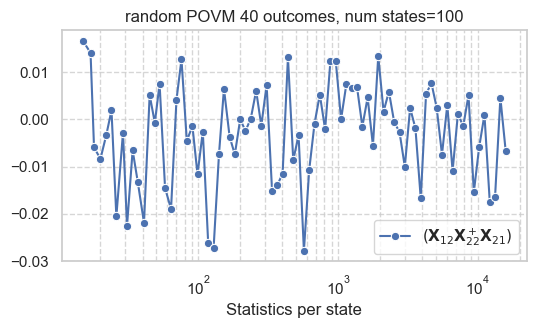

In [31]:
def _(num_outcomes):
    d = 2
    povm = random_rank1_povm(dim=2, num_outcomes=num_outcomes)
    # povm = mub_povm()
    def quantifier(matrix): return matrix[0, 4]
    all_results = []
    n_states = 100
    train_stat_list = np.logspace(1.2, 4.2, num=80, dtype=int)
    for train_stat in train_stat_list:
        states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
        true_P = states.measure_povm(povm=povm, statistics=np.inf)
        realizations = []
        for _ in range(1):
            metrics = []
            dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
            mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
            X22pinv = truncated_pinv(mb.X22, num_outcomes - d**2)
            metrics.append(quantifier(mb.X12 @ X22pinv @ mb.X21))
            realizations.append(metrics)
        all_results.append(np.array(realizations).mean(axis=0))
    all_results = np.array(all_results)
    plt.figure(figsize=(6, 3))
    plt.title(fr'random POVM {num_outcomes} outcomes, num states={n_states}')
    # Plot each metric
    labels = [r'$(\mathbf{X}_{12} \mathbf{X}_{22}^+ \mathbf{X}_{21})$']
    markers = ["o"]
    alphas = [1.0]
    for i in range(all_results.shape[1]):
        sns.lineplot(x=train_stat_list, y=all_results[:, i], marker=markers[i], label=labels[i], alpha=alphas[i])
    logfit_and_plot(train_stat_list, all_results[:, 0])
    plt.xscale("log");
    # plt.yscale("log");
    plt.grid(True, which='both', ls='--', alpha=0.8)
    plt.legend(); plt.xlabel("Statistics per state");
    plt.show()
# _(num_outcomes=10)
_(num_outcomes=40)

In [ ]:
def _(num_outcomes):
    d = 2
    train_stat = 100
    povm = random_rank1_povm(dim=2, num_outcomes=num_outcomes)
    # povm = mub_povm()
    def quantifier(matrix): return norm(matrix, ord=2)
    all_results = []
    n_states_list = np.logspace(1, 3.8, num=100, dtype=int)
    for n_states in n_states_list:
        states = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
        true_P = states.measure_povm(povm=povm, statistics=np.inf)
        realizations = []
        for _ in range(100):
            metrics = []
            dirty_P = states.measure_povm(povm=povm, statistics=train_stat)
            mb = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P, train_stat=train_stat)
            X22pinv = truncated_pinv(mb.X22, num_outcomes - d**2)
            metrics.append(quantifier(mb.X12 @ X22pinv @ mb.X21))
            metrics.append(quantifier(mb.X11))
            metrics.append(quantifier(mb.X11 - mb.X12 @ X22pinv @ mb.X21))
            realizations.append(metrics)
        all_results.append(np.array(realizations).mean(axis=0))
    all_results = np.array(all_results)
    plt.figure(figsize=(10, 5))
    plt.title(fr'random POVM {num_outcomes} outcomes, stat per state={train_stat}')
    # Plot each metric
    labels = [
        r'$\mathbf{X}_{12} \mathbf{X}_{22}^+ \mathbf{X}_{21}$',
        r"${\bf X}_{11}$", 
        r"${\bf X}_{11} - \mathbf{X}_{12} \mathbf{X}_{22}^+ \mathbf{X}_{21}$"]
    markers = ["o", "X", "."]
    alphas = [1.0, 0.7, 0.7]
    for i in range(all_results.shape[1]):
        sns.lineplot(x=n_states_list, y=all_results[:, i], marker=markers[i], label=labels[i], alpha=alphas[i])
    # logfit_and_plot(n_states_list, vals3)
    plt.xscale("log");
    plt.yscale("log");
    plt.grid(True, which='both', ls='--', alpha=0.8)
    plt.legend(); plt.xlabel("Number of training states");
    plt.show()
# _(num_outcomes=10)
_(num_outcomes=32)

100%|██████████| 30/30 [00:01<00:00, 15.42it/s] 


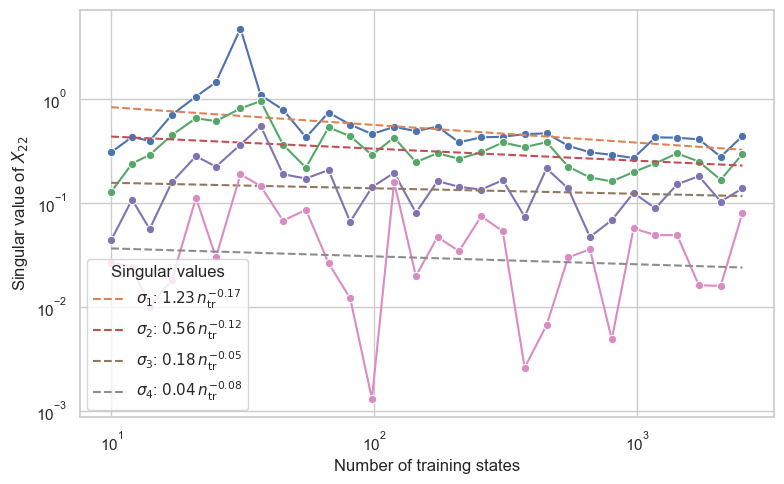

In [ ]:
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set_theme(style="whitegrid")

povm = random_rank1_povm(dim=2, num_outcomes=30)
# povm = mub_povm()
singular_vals = []
n_states_list = np.logspace(1, 3.4, num=30, dtype=int)
for n_states in tqdm(n_states_list):
    states      = QuantumKetsBatch(random_kets(dim=2, num_kets=n_states))
    train_stat  = 200
    true_P      = states.measure_povm(povm=povm, statistics=np.inf)
    dirty_P     = states.measure_povm(povm=povm, statistics=train_stat)
    mb          = MatrixBlocksExtractor(true_P=true_P, dirty_P=dirty_P,
                                        train_stat=train_stat)
    X22inv = scipy.linalg.pinv(mb.X22, atol=1e-10)
    s = np.linalg.svd(mb.X12 @ X22inv @ mb.X21, compute_uv=False)
    # eliminate singular values that are too small
    s = s[s > 1e-10]  # threshold to avoid numerical noise
    singular_vals.append(s)

# --------------- convert & power-law fit ------------------------------------
singular_vals = np.array(singular_vals)           # shape = (N_sizes, k)
num_sing      = singular_vals.shape[1]

# store (slope, intercept) for each σ_j
fits = [np.polyfit(np.log(n_states_list),
                   np.log(singular_vals[:, j]), deg=1)
        for j in range(num_sing)]

# --------------- plot -------------------------------------------------------
plt.figure(figsize=(8, 5))

for j, (a, b) in enumerate(fits, start=1):
    sns.lineplot(x=n_states_list, y=singular_vals[:, j-1], marker="o")

    # fitted curve
    x_fit = np.logspace(np.log10(n_states_list.min()),
                        np.log10(n_states_list.max()), num=200)
    y_fit = np.exp(b + a * np.log(x_fit))
    fit_label = fr"$\sigma_{j}$: ${np.exp(b):.2f} \,n_{{\rm tr}}^{{{a:.2f}}}$"
    plt.plot(x_fit, y_fit, "--", label=fit_label)

plt.xscale("log");  plt.yscale("log")
plt.xlabel("Number of training states")
plt.ylabel("Singular value of $X_{22}$")
plt.legend(title="Singular values")
plt.tight_layout();  plt.show()


In [ ]:
np.polyfit(np.log10(n_states_list), np.log10(vals), deg=1)

array([ 0.55972956, -0.33790224])

# Roba pdf autovalori?

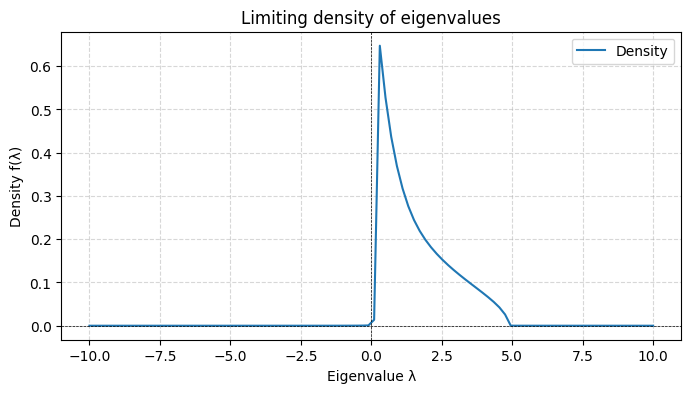

In [7]:
def limiting_density(Sigmas, counts, gamma, lam_grid,
                     eta=1e-3, tol=1e-8, maxit=500):
    """
    Sigmas : list of k (p×p) covariances Σ^{(ℓ)}
    counts : list of k proportions c_ℓ summing to 1
    gamma  : p / n
    lam_grid : iterable of λ where to evaluate the density
    returns: list of f(λ)
    """
    p = Sigmas[0].shape[0]
    k = len(Sigmas)
    I = np.eye(p)
    dens = []

    for lam in lam_grid:
        z = -lam + 1j*eta
        delta = np.zeros(k)
        for _ in range(maxit):
            # build Σ_δ(z)
            Sigma_delta = sum(
                counts[l] * Sigmas[l] / (1 + delta[l])
                for l in range(k)
            )
            Q = np.linalg.inv(Sigma_delta + z*I)
            new_delta = np.array([
                counts[l] * np.trace(Sigmas[l] @ Q) / p
                for l in range(k)
            ])
            if np.linalg.norm(new_delta - delta, ord=np.inf) < tol:
                break
            delta = new_delta

        m = np.trace(Q) / p
        dens.append(m.imag / np.pi)   # (1/π)·Im m(–λ+iη)

    return dens
import numpy as np
pdf = limiting_density(
    Sigmas=[np.diag([1, 2]), np.diag([1, 2])],
    counts=[0.5, 0.5],
    gamma=0.1,
    lam_grid=np.linspace(-10, 10, 100)
)
# plot the density
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(-10, 10, 100), -np.array(pdf), label='Density')
plt.title('Limiting density of eigenvalues')
plt.xlabel('Eigenvalue λ')
plt.ylabel('Density f(λ)')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
